In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [13]:
options(repr.plot.width = 15, repr.plot.height = 10)

AB test was running on logged-in users between Jan 5 2022, 8:34 PM and Mon, Jan 31, 8:24 PM. We will use data of logged-in users between 2021-01-06 and 2021-01-30 in analysis. The analyzed users are all accessed from desktop

This feature targets users who want to click the links on the top header, our analysis focus on the sessions who click at least once on the user links. 

The experiment wikis are: (22 in total)

bnwiki
fawiki
foundationwiki
hewiki
ptwikinews
ptwikiversity
srwiki
thwiki
vecwiki
viwiki
viwikibooks
dewikivoyage
euwiki
kowiki
plwikinews
trwiki
arywiki
frwiki
frwikiquote
frwiktionary
incubatorwiki
ptwiki


Project page: https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Sticky_Header
Prototype: https://di-toc-phase2.web.app/Hokusai

### New Feature  
Enabled with skin version vector 2022  
__At the top of the page__  
<img src="Figures/new1.png" width="800" height="600" align="center"/>
__In the middle of the page__. 
<img src="Figures/new2.png" width="800" height="600" align="center"/>

### Old Feature
Enabled with skin version vector legacy 2010

<img src="Figures/old.png" width="800" height="600" align="center"/>


# Question: Does the sticky header decrease the need to stroll to the top of the page?

### Data Exploration

__check bucketing__

In [337]:
query <- 
"
WITH t_ab AS (
SELECT 
 web_session_id,
 year, month, day, wiki,meta.domain AS domain,
 `group` AS test_group,
 min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id,
 year, month, day, wiki,meta.domain,
 `group`
)
SELECT TO_DATE(t2.meta.dt) AS date_time,t_ab.wiki,  t_ab.test_group,
COUNT(1) AS scrolls,  count(distinct t2.web_session_id) AS scrolled_sessions
FROM t_ab
LEFT JOIN event.mediawiki_web_ui_scroll AS t2 
ON t_ab.domain=t2.meta.domain AND t2.web_session_id = t_ab.web_session_id
WHERE t2.year=2022 and t2.month=1 and t2.day BETWEEN 6 AND 30
AND t_ab.session_dt <= t2.meta.dt
AND t2.action='scroll-to-top'
GROUP BY TO_DATE(t2.meta.dt),t_ab.wiki,t_ab.test_group
"

In [338]:
df_scrolls <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [341]:
filter(df_scrolls, wiki=='arywiki')

date_time  wiki    test_group           scrolls scrolled_sessions
1  2022-01-20 arywiki stickyHeaderDisabled 1       1                
2  2022-01-21 arywiki stickyHeaderDisabled 1       1                
3  2022-01-21 arywiki stickyHeaderEnabled  1       1                
4  2022-01-22 arywiki stickyHeaderDisabled 1       1                
5  2022-01-22 arywiki stickyHeaderEnabled  1       1                
6  2022-01-23 arywiki stickyHeaderEnabled  2       2                
7  2022-01-24 arywiki stickyHeaderDisabled 1       1                
8  2022-01-24 arywiki stickyHeaderEnabled  1       1                
9  2022-01-25 arywiki stickyHeaderDisabled 1       1                
10 2022-01-27 arywiki stickyHeaderEnabled  1       1                
11 2022-01-29 arywiki stickyHeaderDisabled 1       1                
12 2022-01-29 arywiki stickyHeaderEnabled  1       1

In [175]:
query_pv <- "
SELECT  CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) AS event_date, wiki, `group`,
  COUNT(1) AS pageviews, count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki') 
AND year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  year, month, day, wiki, `group`
"

In [176]:
df_pv <- wmfdata::query_hive(query_pv)

Don't forget to authenticate with Kerberos using kinit



In [342]:
df_scrolls <-  merge(df_scrolls , df_pv, by.x=c("wiki", "date_time","test_group"), by.y=c("wiki","event_date","group"), all.x = TRUE)


In [344]:
filter(df_scrolls, wiki=='viwiki')

wiki   date_time  test_group           scrolls scrolled_sessions pageviews
1  viwiki 2022-01-19 stickyHeaderDisabled    9      2                 47     
2  viwiki 2022-01-19 stickyHeaderEnabled     9      3                 96     
3  viwiki 2022-01-20 stickyHeaderDisabled  951    155               2843     
4  viwiki 2022-01-20 stickyHeaderEnabled  1203    163               4165     
5  viwiki 2022-01-21 stickyHeaderDisabled 1020    143               2351     
6  viwiki 2022-01-21 stickyHeaderEnabled  1129    153               3123     
7  viwiki 2022-01-22 stickyHeaderDisabled 1399    146               3283     
8  viwiki 2022-01-22 stickyHeaderEnabled  1272    140               2529     
9  viwiki 2022-01-23 stickyHeaderDisabled 1594    136               3650     
10 viwiki 2022-01-23 stickyHeaderEnabled  1223    131               2636     
11 viwiki 2022-01-24 stickyHeaderDisabled 1725    157               2840     
12 viwiki 2022-01-24 stickyHeaderEnabled  2092    159               4574     
13 viwiki 2022-01-25 stickyHeaderDisabled 2181    145               3823     
14 viwiki 2022-01-25 stickyHeaderEnabled  2040    162               4798     
15 viwiki 2022-01-26 stickyHeaderDisabled 2090    142               2828     
16 viwiki 2022-01-26 stickyHeaderEnabled  2045    169               5905     
17 viwiki 2022-01-27 stickyHeaderDisabled 1664    147               3088     
18 viwiki 2022-01-27 stickyHeaderEnabled  1610    164               5281     
19 viwiki 2022-01-28 stickyHeaderDisabled 2444    134               2816     
20 viwiki 2022-01-28 stickyHeaderEnabled  1577    115               2661     
21 viwiki 2022-01-29 stickyHeaderDisabled 1028    112               2571     
22 viwiki 2022-01-29 stickyHeaderEnabled   894    101               2594     
23 viwiki 2022-01-30 stickyHeaderDisabled 2068     99               3118     
24 viwiki 2022-01-30 stickyHeaderEnabled  1576    114               3110     
   sessions
1   16     
2   22     
3  307     
4  307     
5  284     
6  301     
7  285     
8  276     
9  270     
10 271     
11 263     
12 313     
13 277     
14 330     
15 284     
16 349     
17 287     
18 342     
19 286     
20 277     
21 243     
22 232     
23 198     
24 222

In [228]:
filter(df_scrolls, wiki=='viwiki')

wiki   date_time  test_group           scrolls scrolled_sessions pageviews
1  viwiki 2022-01-19 stickyHeaderDisabled    9      2                 47     
2  viwiki 2022-01-19 stickyHeaderEnabled     9      3                 96     
3  viwiki 2022-01-20 stickyHeaderDisabled  951    155               2843     
4  viwiki 2022-01-20 stickyHeaderEnabled  1203    163               4165     
5  viwiki 2022-01-21 stickyHeaderDisabled 1020    143               2351     
6  viwiki 2022-01-21 stickyHeaderEnabled  1129    153               3123     
7  viwiki 2022-01-22 stickyHeaderDisabled 1399    146               3283     
8  viwiki 2022-01-22 stickyHeaderEnabled  1272    140               2529     
9  viwiki 2022-01-23 stickyHeaderDisabled 1594    136               3650     
10 viwiki 2022-01-23 stickyHeaderEnabled  1223    131               2636     
11 viwiki 2022-01-24 stickyHeaderDisabled 1725    157               2840     
12 viwiki 2022-01-24 stickyHeaderEnabled  2092    159               4574     
13 viwiki 2022-01-25 stickyHeaderDisabled 2181    145               3823     
14 viwiki 2022-01-25 stickyHeaderEnabled  2040    162               4798     
15 viwiki 2022-01-26 stickyHeaderDisabled 2090    142               2828     
16 viwiki 2022-01-26 stickyHeaderEnabled  2045    169               5905     
17 viwiki 2022-01-27 stickyHeaderDisabled 1664    147               3088     
18 viwiki 2022-01-27 stickyHeaderEnabled  1610    164               5281     
19 viwiki 2022-01-28 stickyHeaderDisabled 2444    134               2816     
20 viwiki 2022-01-28 stickyHeaderEnabled  1577    115               2661     
21 viwiki 2022-01-29 stickyHeaderDisabled 1028    112               2571     
22 viwiki 2022-01-29 stickyHeaderEnabled   894    101               2594     
23 viwiki 2022-01-30 stickyHeaderDisabled 2068     99               3118     
24 viwiki 2022-01-30 stickyHeaderEnabled  1576    114               3110     
   sessions
1   16     
2   22     
3  307     
4  307     
5  284     
6  301     
7  285     
8  276     
9  270     
10 271     
11 263     
12 313     
13 277     
14 330     
15 284     
16 349     
17 287     
18 342     
19 286     
20 277     
21 243     
22 232     
23 198     
24 222

In [229]:
write_csv(df_scrolls, "scroll.csv")

Note: event.mediawiki_web_ui_scroll does not have skin version field. 

In [345]:
df_scrolls$date_time <- as.Date(df_scrolls$date_time )

In [346]:
tail(df_scrolls)

wiki        date_time  test_group          scrolls scrolled_sessions
820 viwikibooks 2022-01-25 stickyHeaderEnabled 11      2                
821 viwikibooks 2022-01-26 stickyHeaderEnabled  3      1                
822 viwikibooks 2022-01-27 stickyHeaderEnabled  1      1                
823 viwikibooks 2022-01-28 stickyHeaderEnabled 42      4                
824 viwikibooks 2022-01-29 stickyHeaderEnabled 47      3                
825 viwikibooks 2022-01-30 stickyHeaderEnabled 17      3                
    pageviews sessions
820  99       3       
821  50       2       
822  10       1       
823 294       6       
824 174       5       
825  96       6

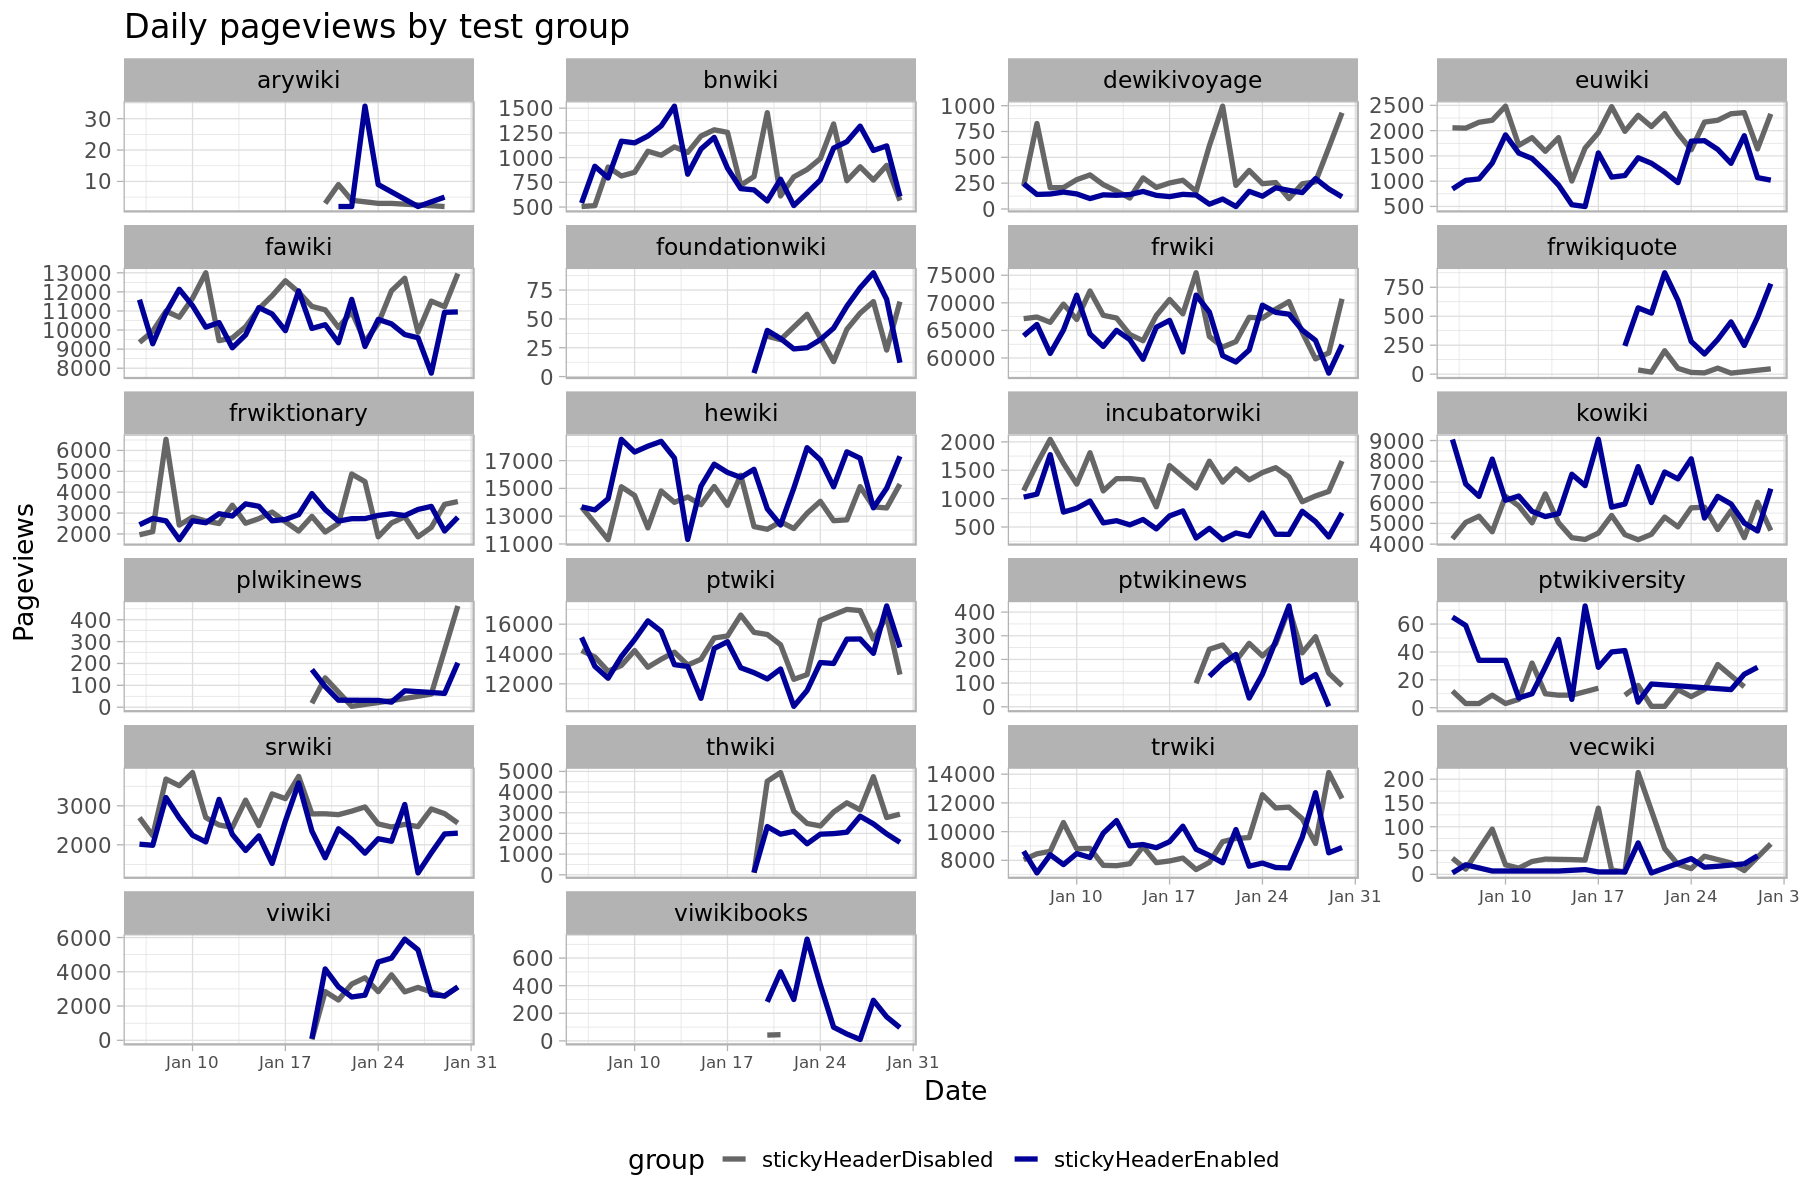

In [232]:
g_pv <- ggplot(data=df_scrolls, 
                                mapping=aes(x=date_time, y=pageviews, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily pageviews by test group',
     x = 'Date',
     y = 'Pageviews') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_pv

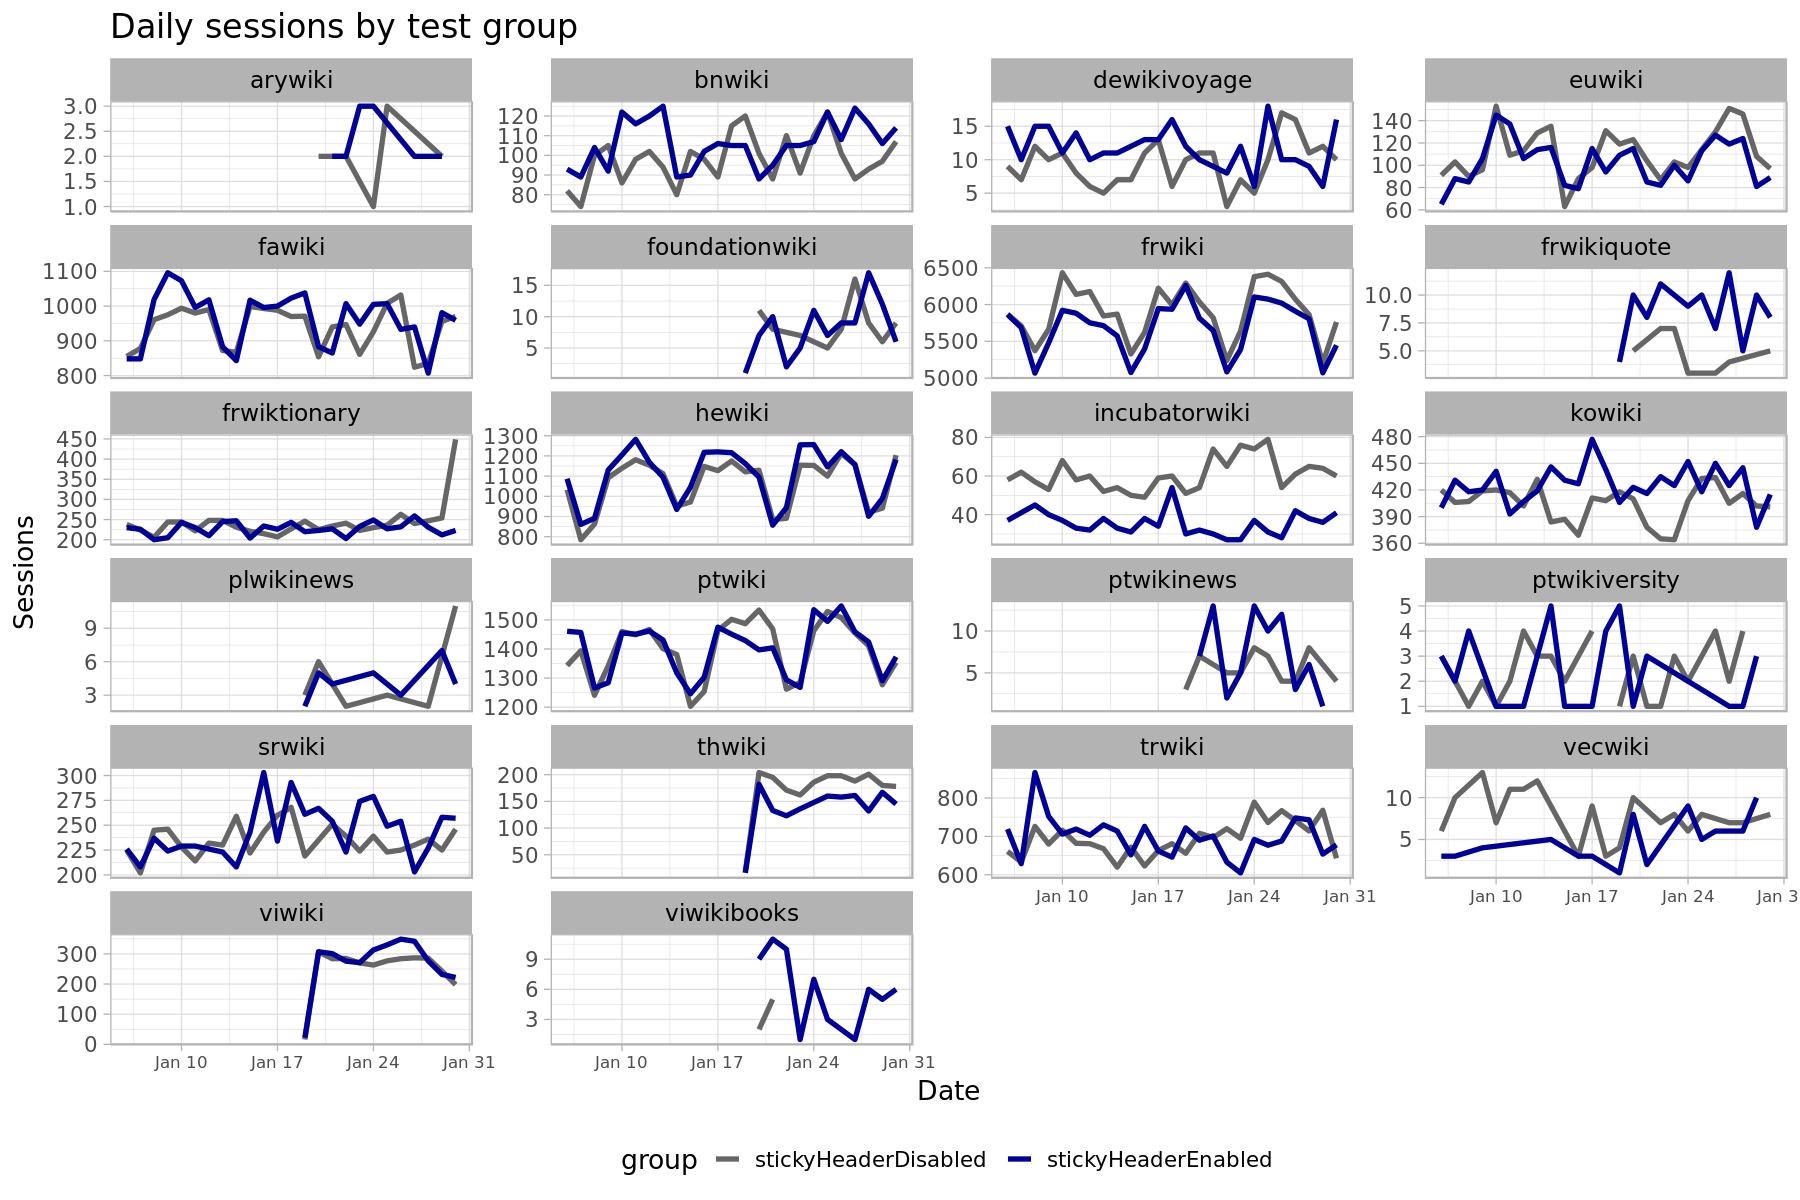

In [233]:
g_session <- ggplot(data=df_scrolls, 
                                mapping=aes(x=date_time, y=sessions, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily sessions by test group',
     x = 'Date',
     y = 'Sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_session

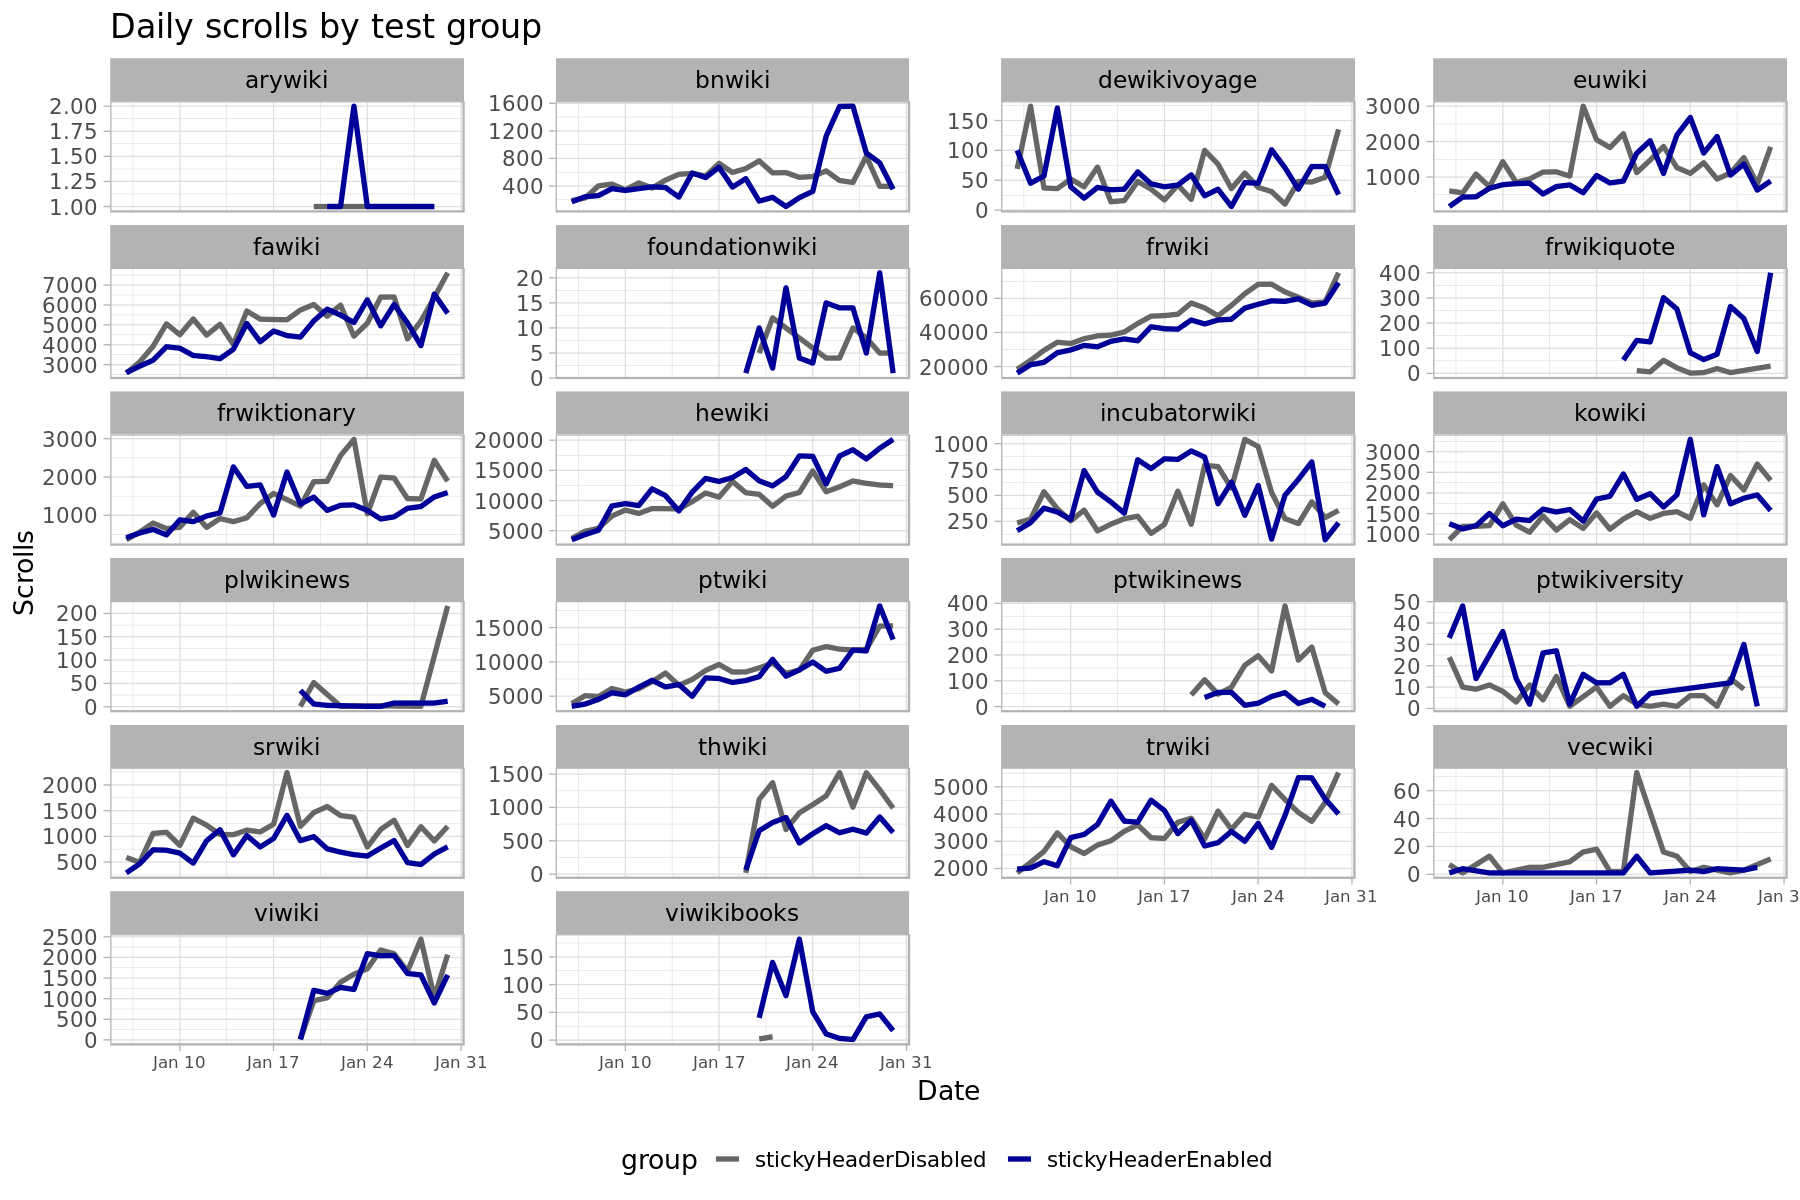

In [333]:
g_scroll <- ggplot(data=df_scrolls, 
                                mapping=aes(x=date_time, y=scrolls, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily scrolls by test group',
     x = 'Date',
     y = 'Scrolls') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_scroll

__Note:__  

- The sessions in AB testing are not distributed evenly between control and treatment groups on all wikis.   
- Same for pageviews. Pageviews in AB testing are not distributed evenly between control and treatment groups on all wikis.    
- To eliminate the impact of uneven distribution, in the following AB testing analysis, we will use clicks/pageviews as the measurement metric, instead of the number of clicks. 
- arywiki, viwikibooks, plwikinews, ptwikinews, ptwikiversity have too few data points. will be excluded them in analysis


__How scrolls distributed by skinversion__

In [697]:
query_skin_version <- "
WITH t_ab AS (
SELECT 
 distinct web_session_id,
 wiki, `group` AS test_group
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
)
SELECT t1.event.token AS web_session_id, t1.event.skinversion, t1.wiki, test_group, min(TO_DATE(t1.dt)) AS init_date
FROM event.DesktopWebUIActionsTracking AS t1
INNER JOIN t_ab ON t_ab.wiki=t1.wiki AND t_ab.web_session_id=t1.event.token
WHERE t1.wiki NOT IN ('testwiki','test2wiki') 
and t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
AND t1.event.action='init' AND NOT t1.event.isAnon
GROUP BY t1.event.token , t1.event.skinversion, t1.wiki, test_group
"

In [698]:
df_skin_version<- wmfdata::query_hive(query_skin_version)

Don't forget to authenticate with Kerberos using kinit



In [699]:
df_skin_version

web_session_id       skinversion wiki         test_group          
1      00000a8e323211c481c8 2           frwiki       stickyHeaderDisabled
2      00001880ed7963ac3291 2           ptwiki       stickyHeaderEnabled 
3      00003865ffbaa4f8aadc 2           frwiki       stickyHeaderDisabled
4      00004089d59109654f03 2           trwiki       stickyHeaderEnabled 
5      00007ae27d125152cf65 2           frwiki       stickyHeaderEnabled 
6      00007df8050e6636a40b 2           frwiki       stickyHeaderEnabled 
7      00008648a95cca2bf98e 2           fawiki       stickyHeaderDisabled
8      000088f8c89f9bc6a834 2           frwiki       stickyHeaderDisabled
9      0000be8841ff206386d5 2           frwiki       stickyHeaderEnabled 
10     0000c885c58ba0503daf 2           frwiki       stickyHeaderEnabled 
11     0001033c39ece061e638 2           ptwiki       stickyHeaderDisabled
12     00013c395144a3fb521c 2           frwiki       stickyHeaderEnabled 
13     00015882535503d0d430 2           frwiki       stickyHeaderDisabled
14     000165e8d597592537ca 2           frwiki       stickyHeaderEnabled 
15     00019a5ec20cd8f36a71 2           frwiki       stickyHeaderEnabled 
16     00020ccc214902726195 2           hewiki       stickyHeaderDisabled
17     00021527f4085b976a7d 2           fawiki       stickyHeaderDisabled
18     000215c839e0fe3bd3ea 2           frwiki       stickyHeaderDisabled
19     00022b0cd24c17c13157 2           fawiki       stickyHeaderDisabled
20     00023d5328b60d3a095b 2           frwiki       stickyHeaderEnabled 
21     0002430391d25d47377c 2           kowiki       stickyHeaderEnabled 
22     00024b80d00db29c2876 2           frwiki       stickyHeaderDisabled
23     0002515536531ce9625b 2           ptwiki       stickyHeaderEnabled 
24     0002a91bdef0fb8f0ef5 2           trwiki       stickyHeaderDisabled
25     0002d35abf7bdc3c0c7a 2           frwiki       stickyHeaderDisabled
26     000316cf86ab1ac3a954 2           frwiki       stickyHeaderDisabled
27     00039ceb6490733efcf7 2           trwiki       stickyHeaderDisabled
28     0003a6a7a0af80da6702 2           kowiki       stickyHeaderDisabled
29     0003ca28b1e5a42c6b24 2           frwiki       stickyHeaderEnabled 
30     0003e36d300799fa759e 2           hewiki       stickyHeaderDisabled
⋮      ⋮                    ⋮           ⋮            ⋮                   
435277 fffb055e97001d120f6c 2           frwiki       stickyHeaderEnabled 
435278 fffbbb799ef17890c639 2           bnwiki       stickyHeaderDisabled
435279 fffbe1b2ff30861ea34a 2           fawiki       stickyHeaderEnabled 
435280 fffc0334a77e2e99341b 2           ptwiki       stickyHeaderDisabled
435281 fffc05e086dad9e039b7 2           hewiki       stickyHeaderEnabled 
435282 fffc3a9a43ba80abf2c4 2           frwiki       stickyHeaderDisabled
435283 fffc577ad41b4a2fb6f9 2           frwiki       stickyHeaderEnabled 
435284 fffc8668eebfe7238a71 2           frwiki       stickyHeaderDisabled
435285 fffca1fc6d303ac65446 2           fawiki       stickyHeaderEnabled 
435286 fffca943862a1b1b7777 2           frwiki       stickyHeaderEnabled 
435287 fffcdbbd9ff1497a5727 2           frwiki       stickyHeaderEnabled 
435288 fffd3de4f006caa2e447 2           frwiki       stickyHeaderDisabled
435289 fffd83bee3c2e67d2bbd 2           frwiki       stickyHeaderEnabled 
435290 fffd84dc6f3fbceaa593 2           frwiki       stickyHeaderEnabled 
435291 fffdc3b06c4ba30b9cc4 2           frwiki       stickyHeaderEnabled 
435292 fffdf920b62d7deaca04 2           hewiki       stickyHeaderDisabled
435293 fffe4294b7e942245bb5 2           frwiki       stickyHeaderDisabled
435294 fffe6fdbcc50de148a9b 2           frwiki       stickyHeaderDisabled
435295 fffed63a46c5c5bfc859 2           frwiki       stickyHeaderEnabled 
435296 fffefc53341260683b3b 2           frwiktionary stickyHeaderEnabled 
435297 ffff448f39ccacbf543f 2           frwiki       stickyHeaderDisabled
435298 ffff6a66293009ec0aeb 2           kowiki       stickyHeaderDisabled
435299 ffff

In [701]:
write_csv(df_skin_version, "Data_out/ab_skin.csv")

Count unique web_session_id by test group and skin verion



|test_group	|skinverion=1	|skinverion=2|
|-----|----|-----|
|stickyHeaderDisabled	|613	|218680|
|stickyHeaderEnabled	|624	|215389|

In [95]:
query_check_duplicate <- "

SELECT  web_session_id, wiki, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id, wiki
HAVING groups>1

"

In [96]:
df_duplicate <- wmfdata::query_hive(query_check_duplicate)

Don't forget to authenticate with Kerberos using kinit



In [97]:
df_duplicate

web_session_id       wiki         groups session_dt              
1   00cfc910b70ceec0463a fawiki       2      2022-01-10T09:21:33.644Z
2   0105cd44b20d27066f67 frwiki       2      2022-01-18T11:06:40.368Z
3   0171d4de96f876923ccb viwiki       2      2022-01-24T15:10:42.399Z
4   01f7270d18b53ed2f299 frwiki       2      2022-01-18T05:29:14.538Z
5   04142e73c82c23ca29fc hewiki       2      2022-01-09T12:02:35.247Z
6   053d05829c15e7ee8114 frwiki       2      2022-01-15T08:45:36.985Z
7   05afa07eb3221803ef4b hewiki       2      2022-01-23T09:52:54.307Z
8   05cde26a92372dd3603c frwiki       2      2022-01-21T09:05:48.715Z
9   06a159c884d5740c2708 frwiki       2      2022-01-28T13:15:00.128Z
10  08218b739e9f50d85f49 fawiki       2      2022-01-06T07:39:24.000Z
11  0b0eb2bd0e9dd0a0716c fawiki       2      2022-01-26T09:32:11.029Z
12  0b949e81d32cfea29a2d ptwiki       2      2022-01-13T12:37:30.103Z
13  0d0c5657e08ee5d8b788 frwiki       2      2022-01-26T12:17:35.771Z
14  0f60103183f2d490d7a6 euwiki       2      2022-01-18T15:49:59.146Z
15  0f88cdcbb37cef7b8f40 ptwiki       2      2022-01-23T16:04:46.563Z
16  10e3241fb1c6f6c63f5a fawiki       2      2022-01-06T17:38:56.411Z
17  11161e7a8f1da983c482 frwiki       2      2022-01-12T07:54:19.329Z
18  12d62dad102deb1d9a47 frwiktionary 2      2022-01-13T14:24:03.347Z
19  1325e28a9dddb6591d42 ptwiki       2      2022-01-09T20:46:54.814Z
20  13b7096b0e5df728a95d frwiktionary 2      2022-01-09T21:23:43.346Z
21  144a8522fbb2f0523ce1 fawiki       2      2022-01-11T11:25:43.087Z
22  14e3d31f03b8d0c7e7ad trwiki       2      2022-01-14T23:29:31.650Z
23  1506f63615b82c91ee07 trwiki       2      2022-01-24T13:10:51.424Z
24  164f83356a6ac82f20e4 euwiki       2      2022-01-21T11:53:37.098Z
25  167858294b1746630860 ptwiki       2      2022-01-15T17:10:53.091Z
26  1680b3f24000d365c7a5 fawiki       2      2022-01-11T08:19:27.712Z
27  16914056959b2dac59ac fawiki       2      2022-01-10T07:46:16.360Z
28  17844f3889e533cb65e7 frwiki       2      2022-01-11T16:45:10.101Z
29  17e3bf2446edd5571ed6 frwiki       2      2022-01-28T19:26:28.799Z
30  18ee3948cf801fe8cd1a frwiki       2      2022-01-19T19:32:01.287Z
⋮   ⋮                    ⋮            ⋮      ⋮                       
780 e7c6ad1d1e52cf3ed342 trwiki       2      2022-01-09T17:50:48.039Z
781 e7e5edabdda6e51486d4 frwiki       2      2022-01-24T13:32:17.112Z
782 e8ab578b4ad18a892cb2 hewiki       2      2022-01-30T02:35:59.779Z
783 edc780435ee00612703e fawiki       2      2022-01-28T16:34:12.605Z
784 ee42b55a0cb5a3f0f45d fawiki       2      2022-01-11T14:32:08.296Z
785 ee516e53d4210b0a00b3 srwiki       2      2022-01-26T13:37:50.275Z
786 ee94290943ccb5b27112 frwiki       2      2022-01-26T10:01:28.031Z
787 ef041f608fb694267f6f kowiki       2      2022-01-06T08:19:27.406Z
788 ef7c0c29fc452cf8c53b frwikiquote  2      2022-01-21T18:32:25.822Z
789 efad9ccde7fa89808476 fawiki       2      2022-01-20T07:58:45.318Z
790 f0336691888c709168c9 hewiki       2      2022-01-12T08:19:39.202Z
791 f12e7b8af31d682f2590 ptwiki       2      2022-01-10T14:10:13.434Z
792 f2771973565fad067aef frwiki       2      2022-01-30T01:59:49.827Z
793 f2d56a7b43b9cbcd1ed3 fawiki       2      2022-01-10T10:40:45.778Z
794 f2feee3f622aca7078f0 ptwiki       2      2022-01-15T14:19:21.389Z
795 f4faa509a8eaed2d4887 fawiki       2      2022-01-23T12:42:43.551Z
796 f57aa19056d6bcab73c7 frwiki       2      2022-01-29T13:29:28.296Z
797 f5edfaa07782e9bee8d3 frwiki       2      2022-01-14T12:52:28.948Z
798 f5fdbcc3ba8620c22d17 kowiki       2      2022-01-21T11:30:35.100Z
799 f84a71a1865179f731c0 frwiki       2      2022-01-20T13:29:51.472Z
800 f8bff79c47af1bc2b2d7 frwiki       2      2022-01-15T19:24:20.306Z
801 f90e5a0dc9d68f7181eb ptwiki       2      2022-01-07T02:22:21.238Z
802 fc16c8c4418d2f14e98a bnwiki       2      2022-01-11T13:12:11.150Z
803 fc25f4636cc053d62f86 frwiki       2      2022-01-28T19:50:40.266Z
804 fc3bd0e816ecb698487f frwiki       2      2022-01-07T07:50:34.149Z
805 fda30aaaab

In [99]:
write_csv(df_duplicate, "Data_out_try5/duplicated_session.csv")

__Note:__. 

809 sessions are assigned to both control and test groups. Need to be excluded in analysis


__How number of scrolls distributed by sessions__

In [5]:
query_scroll_click <- 
"
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  and t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
),
t_ab_skin_version AS (
SELECT t1.event.token AS web_session_id, t1.wiki,test_group, min(t1.event.skinversion) AS skinversion, 
min(TO_DATE(t1.dt)) AS init_date
FROM event.DesktopWebUIActionsTracking AS t1
INNER JOIN t_ab ON t_ab.wiki=t1.wiki AND t_ab.web_session_id=t1.event.token
WHERE t1.wiki NOT IN ('testwiki','test2wiki') 
and t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
AND t1.event.action='init' AND NOT t1.event.isAnon
GROUP BY t1.event.token , t1.wiki, test_group
),
-- clicks by session
t_c AS (
SELECT TO_DATE(t1.meta.dt) AS event_date, t_ab.wiki, 
t_ab.test_group,  t1.event.token AS event_token, count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t1
INNER JOIN t_ab 
ON  t1.wiki=t_ab.wiki AND t1.event.token = t_ab.web_session_id
WHERE t1.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
AND t_ab.session_dt <= t1.meta.dt
AND event.name in ( 
-- event name on top header
'ui.dropdown-p-personal','pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 
'pt-mycontris', 'pt-logout', 'ui.dropdown-p-lang',
'ca-history','ca-talk', 'pt-userpage',
-- event name on sticky header
'ui.dropdown-p-personal-sticky-header','pt-watchlist-sticky-header', 'pt-mytalk-sticky-header', 
'pt-sandbox-sticky-header','pt-preferences-sticky-header', 'pt-betafeatures-sticky-header', 
'pt-mycontris-sticky-header', 'pt-logout-sticky-header','ui.dropdown-p-lang-btn-sticky-header' ,
'history-sticky-header', 'talk-sticky-header', 'pt-userpage-sticky-header'
)
AND event.action='click' AND event.skinversion=2 and NOT event.isanon
GROUP BY TO_DATE(t1.meta.dt), t_ab.wiki,t_ab.test_group, t1.event.token
),
--scrolls by session
t_s AS (
SELECT  TO_DATE(t3.meta.dt) AS event_date,t_ab.wiki,   t_ab.test_group, t3.web_session_id, COUNT(1) AS scrolls 
FROM t_ab
LEFT JOIN event.mediawiki_web_ui_scroll AS t3 
ON t_ab.domain=t3.meta.domain AND t3.web_session_id = t_ab.web_session_id
AND t3.year=2022 and t3.month=1 and t3.day BETWEEN 6 AND 30
WHERE t_ab.session_dt <= t3.meta.dt
AND t3.action='scroll-to-top'
GROUP BY  TO_DATE(t3.meta.dt) , t_ab.wiki,   t_ab.test_group, t3.web_session_id
)
SELECT  t_s.event_date,t_s.wiki,   t_s.test_group, t_s.web_session_id, t4.skinversion, t_s.scrolls , t_c.clicks
FROM t_s
LEFT JOIN t_c ON t_s.web_session_id= t_c.event_token AND t_s.event_date= t_c.event_date 
      AND t_s.wiki=t_c.wiki AND t_s.test_group=t_c.test_group
LEFT JOIN t_ab_skin_version AS t4 ON t4.web_session_id= t_s.web_session_id 
     AND t4.wiki=t_s.wiki AND t4.test_group=t_s.test_group
"

In [6]:
df_scroll_click <- wmfdata::query_hive(query_scroll_click)

Don't forget to authenticate with Kerberos using kinit



In [7]:
df_scroll_click

event_date wiki       test_group           web_session_id      
1      2022-01-12 ptwiki     stickyHeaderEnabled  00001880ed7963ac3291
2      2022-01-19 frwiki     stickyHeaderDisabled 00003865ffbaa4f8aadc
3      2022-01-20 frwiki     stickyHeaderDisabled 00003865ffbaa4f8aadc
4      2022-01-28 frwiki     stickyHeaderEnabled  00007ae27d125152cf65
5      2022-01-27 frwiki     stickyHeaderEnabled  00007df8050e6636a40b
6      2022-01-24 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
7      2022-01-25 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
8      2022-01-15 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
9      2022-01-14 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
10     2022-01-30 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
11     2022-01-11 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
12     2022-01-29 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
13     2022-01-09 fawiki     stickyHeaderDisabled 00008648a95cca2bf98e
14     2022-01-10 frwiki     stickyHeaderDisabled 00015882535503d0d430
15     2022-01-17 frwiki     stickyHeaderEnabled  000165e8d597592537ca
16     2022-01-25 hewiki     stickyHeaderDisabled 00020ccc214902726195
17     2022-01-10 fawiki     stickyHeaderDisabled 00021527f4085b976a7d
18     2022-01-20 frwiki     stickyHeaderDisabled 000215c839e0fe3bd3ea
19     2022-01-26 frwiki     stickyHeaderEnabled  00023d5328b60d3a095b
20     2022-01-29 kowiki     stickyHeaderEnabled  0002430391d25d47377c
21     2022-01-28 ptwiki     stickyHeaderEnabled  0002515536531ce9625b
22     2022-01-24 trwiki     stickyHeaderDisabled 0002a91bdef0fb8f0ef5
23     2022-01-14 frwiki     stickyHeaderDisabled 0002d35abf7bdc3c0c7a
24     2022-01-29 frwiki     stickyHeaderDisabled 000316cf86ab1ac3a954
25     2022-01-06 trwiki     stickyHeaderDisabled 00039ceb6490733efcf7
26     2022-01-08 kowiki     stickyHeaderDisabled 0003a6a7a0af80da6702
27     2022-01-14 frwiki     stickyHeaderEnabled  0003ca28b1e5a42c6b24
28     2022-01-24 fawiki     stickyHeaderDisabled 00040948f8d316078aae
29     2022-01-07 frwiki     stickyHeaderDisabled 00047e0bc8f31d873ede
30     2022-01-19 frwiki     stickyHeaderDisabled 0004ecf2bcbaac39f4af
⋮      ⋮          ⋮          ⋮                    ⋮                   
277837 2022-01-25 frwiki     stickyHeaderEnabled  fff8473444a4ff98b673
277838 2022-01-12 ptwiki     stickyHeaderEnabled  fff88c71ff0b5802867d
277839 2022-01-26 frwiki     stickyHeaderEnabled  fff96b7aefdfc85f6b7d
277840 2022-01-25 trwiki     stickyHeaderDisabled fff976d0b1668feb823f
277841 2022-01-27 frwiki     stickyHeaderEnabled  fff98c59fde688c437ac
277842 2022-01-10 frwiki     stickyHeaderEnabled  fff9bd23c5a201dfdb78
277843 2022-01-28 ptwikinews stickyHeaderEnabled  fff9fead127dec394fef
277844 2022-01-16 frwiki     stickyHeaderDisabled fffa2e5bd1cbdaec96a1
277845 2022-01-24 frwiki     stickyHeaderEnabled  fffa3b75b205d7291645
277846 2022-01-17 euwiki     stickyHeaderEnabled  fffa4fe2d5c8f9f181ee
277847 2022-01-18 frwiki     stickyHeaderDisabled fffa62ba35bc5c03f7d1
277848 2022-01-29 fawiki     stickyHeaderEnabled  fffa7f66a3945831413b
277849 2022-01-24 hewiki     stickyHeaderDisabled fffa97d803314ae90429
277850 2022-01-18 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277851 2022-01-11 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277852 2022-01-09 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277853 2022-01-10 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277854 2022-01-20 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277855 2022-01-16 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277856 2022-01-13 hewiki     stickyHeaderEnabled  fffabaced01053666a1b
277857 2022-01-27 frwiki     stickyHeaderEnabled  fffb055e97001d120f6c
277858 2022-01-15 ptwiki     stickyHeaderDisabled fffc0334a77e2e99341b
277859 2022-01-06 frwiki     stickyHeaderEnabled  fffc577ad41b4a2fb6f9
277860 2022-01-21 frwiki     stickyHeaderDisabled fffc8668eebfe7238a71
277861 2022-01-20 frwiki     st

In [8]:
write_csv(df_scroll_click, "Data_out_try5/scroll_click.csv")

In [9]:
summary(df_scroll_click)

  event_date            wiki            test_group        web_session_id    
 Length:277866      Length:277866      Length:277866      Length:277866     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 skinversion           scrolls           clicks         
 Length:277866      Min.   :  1.000   Length:277866     
 Class :character   1st Qu.:  1.000   Class :character  
 Mode  :character   Median :  2.000   Mode  :character  
                    Mean   :  5.947                     
                    3rd Qu.:  5.000                     
                    Max.   :443.000                     

In [10]:
summary(filter(df_scroll_click, !((skinversion==1)&(test_group=='stickyHeaderEnabled'))))

  event_date            wiki            test_group        web_session_id    
 Length:277263      Length:277263      Length:277263      Length:277263     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 skinversion           scrolls           clicks         
 Length:277263      Min.   :  1.000   Length:277263     
 Class :character   1st Qu.:  1.000   Class :character  
 Mode  :character   Median :  2.000   Mode  :character  
                    Mean   :  5.946                     
                    3rd Qu.:  5.000                     
                    Max.   :443.000                     

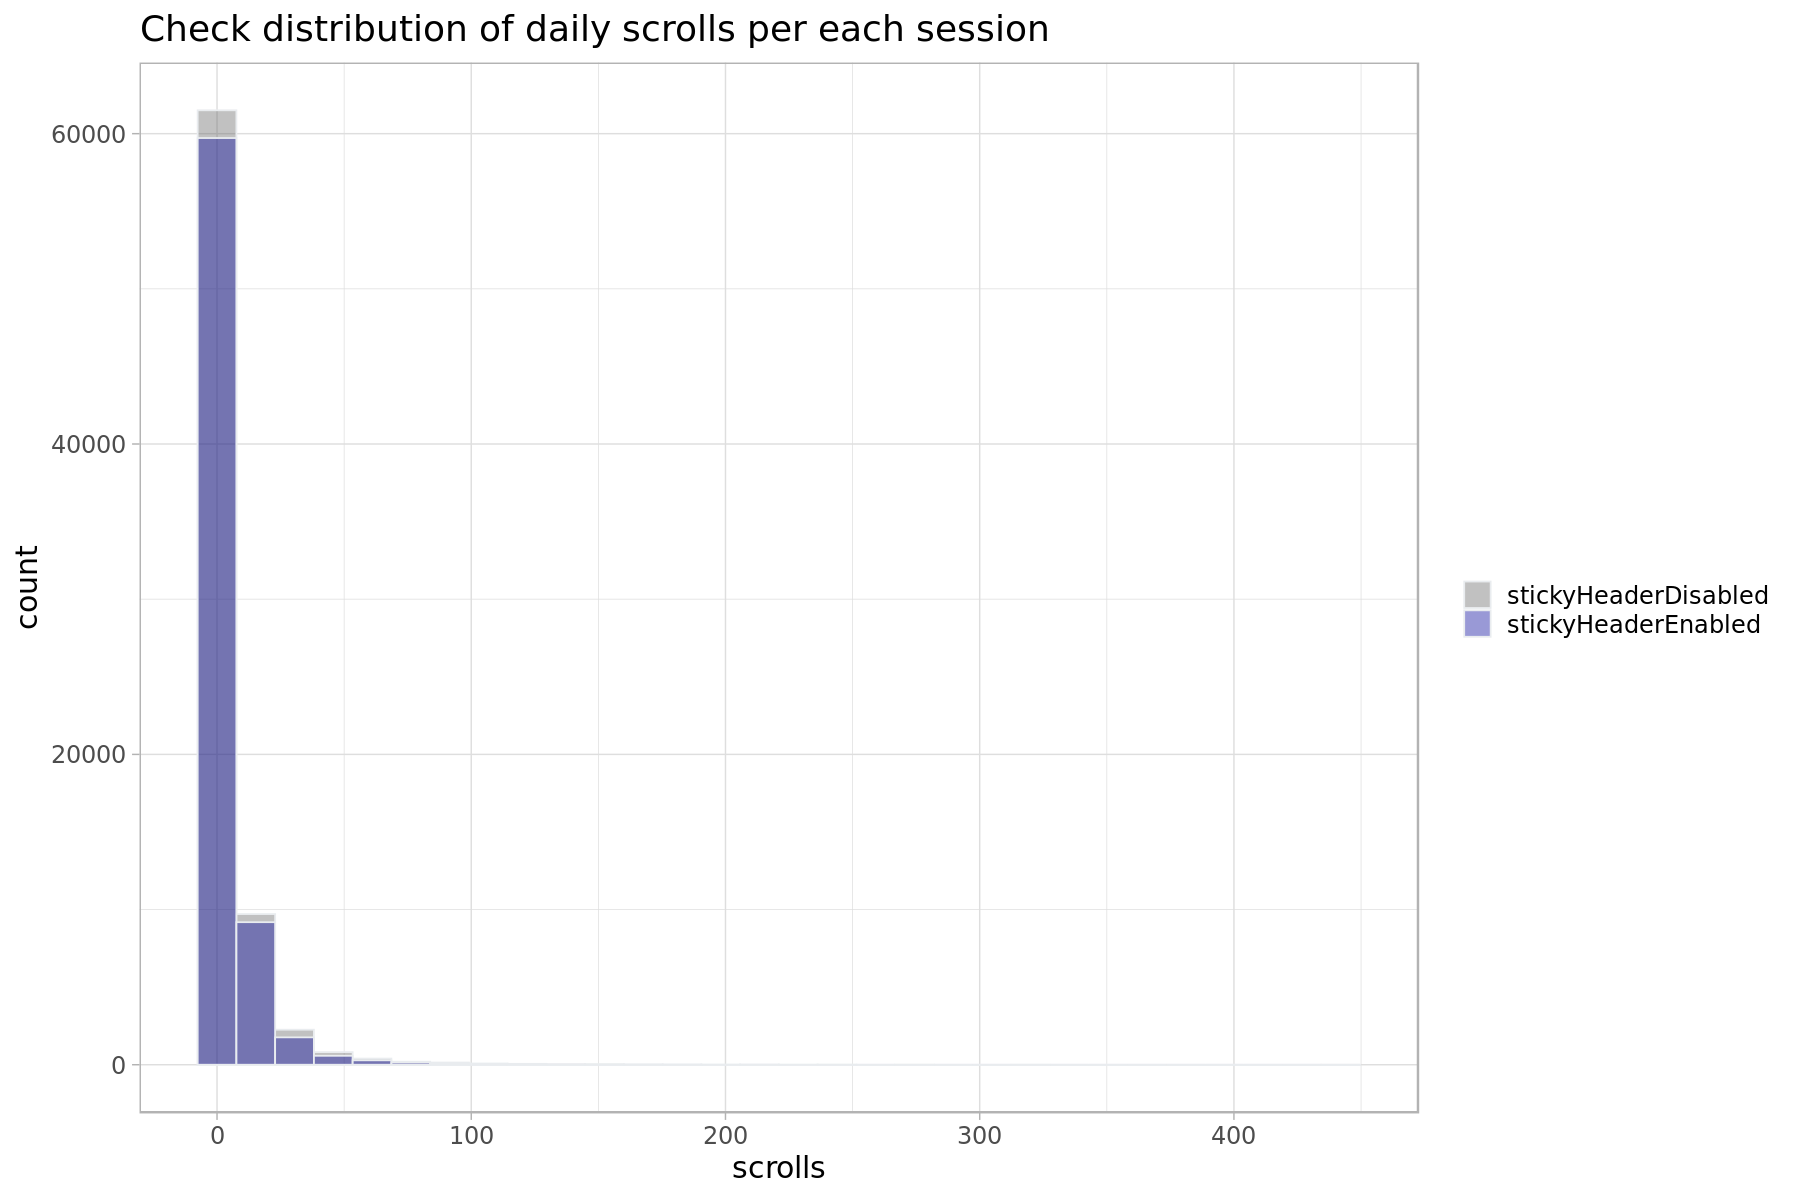

In [14]:
p <- df_scroll_click %>%
 filter((wiki=='frwiki')&( scrolls <=1000)) %>% 
 ggplot( aes(x=scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of daily scrolls per each session",
         fill="") +
    theme_light(base_size=18)
p


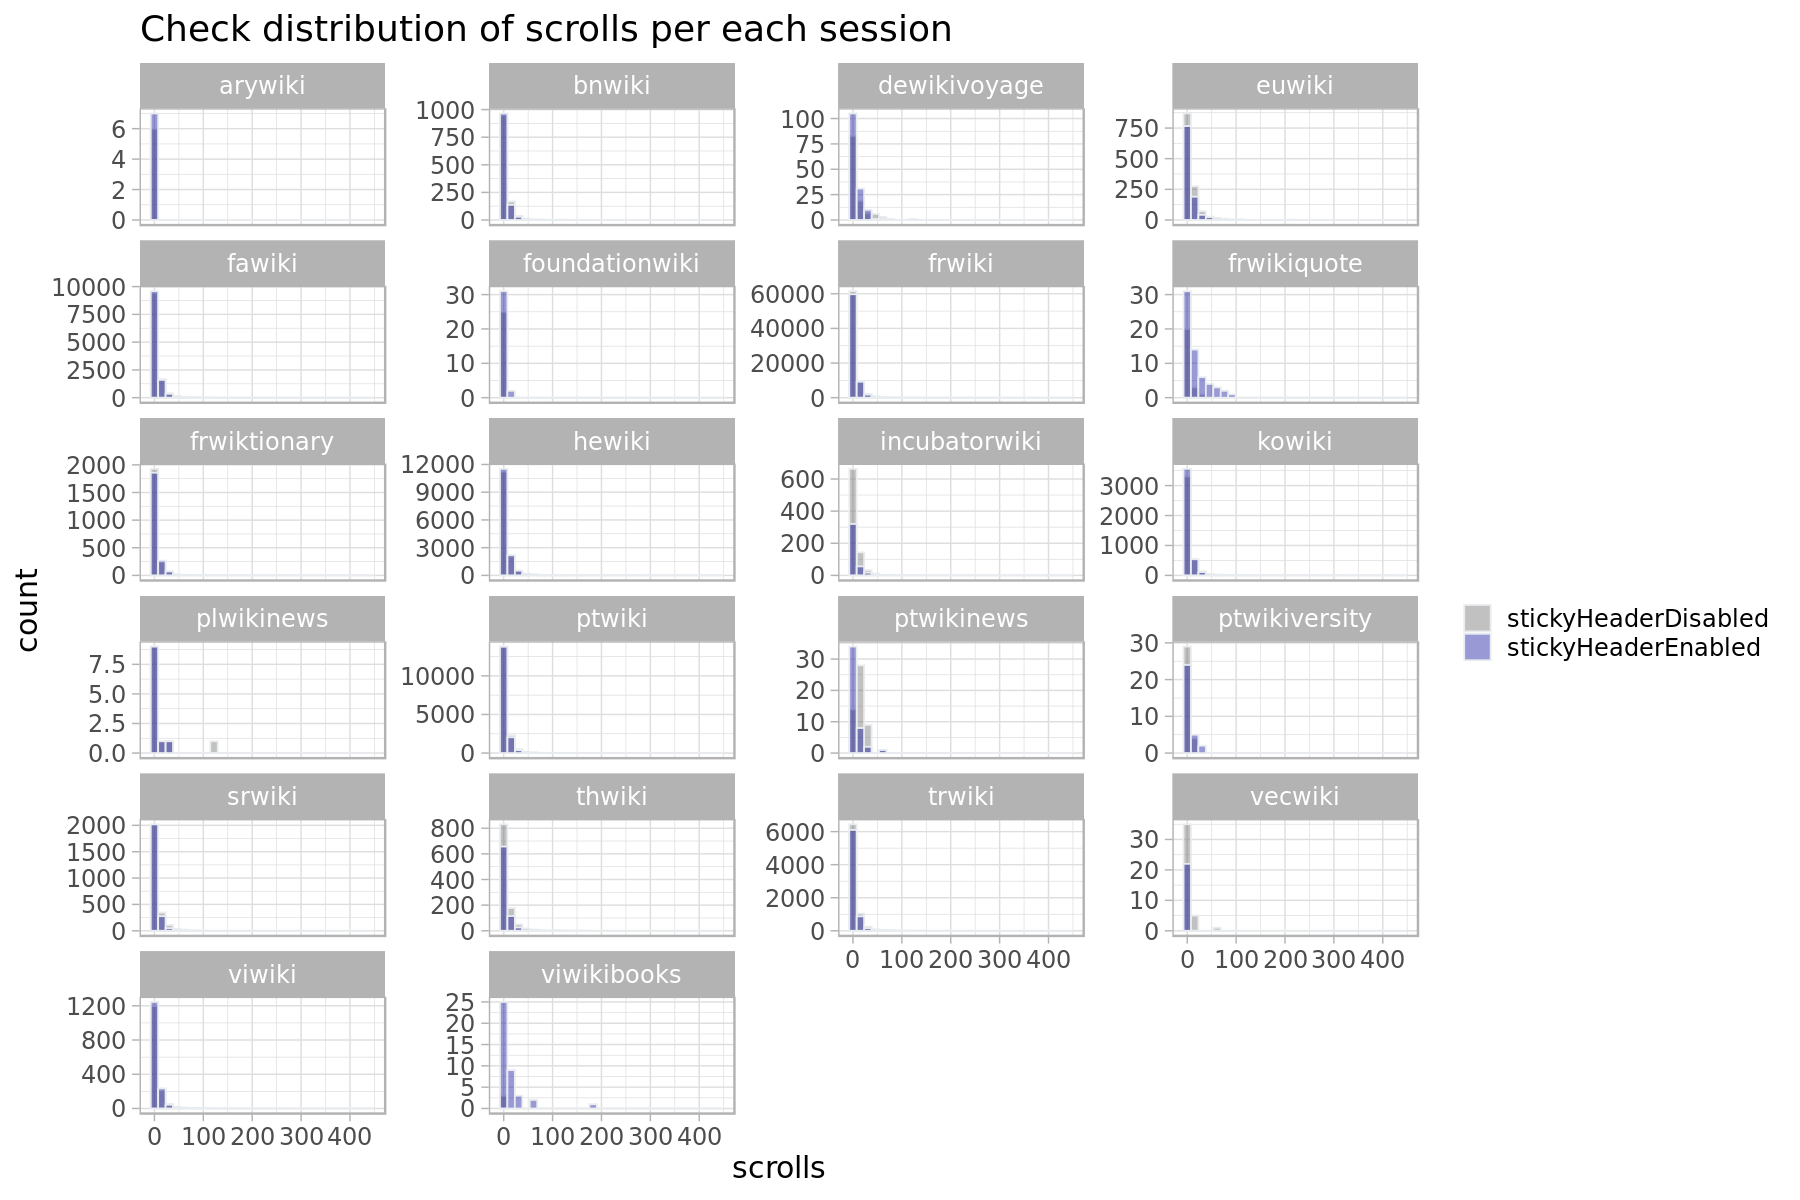

In [15]:
p <- df_scroll_click %>%
 ggplot( aes(x=scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
    facet_wrap(~wiki,nrow=6,scale = 'free_y')+
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of scrolls per each session",
         fill="") +
    theme_light(base_size=18)
p


In [17]:
query_pv_dis <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT  CONCAT(t1.year, '-', LPAD(t1.month,2,'0'),'-', LPAD(t1.day,2,'0')) AS event_date, wiki, `group`,web_session_id,
  COUNT(1) AS pageviews
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki') 
AND t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
GROUP BY  t1.year, t1.month, t1.day, t1.wiki, t1.`group`,t1.web_session_id
"

In [18]:
df_pv_dis <- wmfdata::query_hive(query_pv_dis)

Don't forget to authenticate with Kerberos using kinit



In [19]:
summary(df_pv_dis)

  event_date            wiki              group           web_session_id    
 Length:562181      Length:562181      Length:562181      Length:562181     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
   pageviews      
 Min.   :   1.00  
 1st Qu.:   1.00  
 Median :   3.00  
 Mean   :  11.65  
 3rd Qu.:   8.00  
 Max.   :5886.00  

In [20]:
filter(df_pv_dis, pageviews>=1000)

event_date wiki         group                web_session_id       pageviews
1   2022-01-06 fawiki       stickyHeaderEnabled  6fc072af46284be31f63 1005     
2   2022-01-06 frwiki       stickyHeaderDisabled ac2b6af9bdddd7069a0c 1677     
3   2022-01-06 frwiki       stickyHeaderEnabled  4c445ef30631fea2d1f9 1695     
4   2022-01-06 frwiki       stickyHeaderEnabled  cce62d355006655f70c7 1170     
5   2022-01-06 kowiki       stickyHeaderEnabled  5d175337034c1b4a667e 1007     
6   2022-01-07 frwiki       stickyHeaderDisabled 09c9b1db3d6a95473b83 1048     
7   2022-01-07 frwiki       stickyHeaderDisabled 1a7bd3d59601cbf63d16 1423     
8   2022-01-07 frwiki       stickyHeaderEnabled  4c445ef30631fea2d1f9 1142     
9   2022-01-07 frwiki       stickyHeaderEnabled  9f55739580cefee6777f 2662     
10  2022-01-07 frwiki       stickyHeaderEnabled  c4a63f71fa06e80d7317 1392     
11  2022-01-08 frwiki       stickyHeaderEnabled  4c445ef30631fea2d1f9 1185     
12  2022-01-08 frwiktionary stickyHeaderDisabled 82b416d832cc047c98e2 4067     
13  2022-01-08 ptwiki       stickyHeaderDisabled 023c98e915d905cbd724 1596     
14  2022-01-08 srwiki       stickyHeaderEnabled  2633357d3904bdb85efa 1117     
15  2022-01-08 trwiki       stickyHeaderDisabled bd15bd79f6f3c58f2d24 1316     
16  2022-01-09 frwiki       stickyHeaderDisabled 37e5e9a7fa520b95c664 1263     
17  2022-01-09 frwiki       stickyHeaderDisabled 95a27fbe63077de341bc 1034     
18  2022-01-09 trwiki       stickyHeaderDisabled 4f730d320f278a4d1206 1614     
19  2022-01-10 frwiki       stickyHeaderDisabled ea4bf8a830971fab9187 1021     
20  2022-01-10 frwiki       stickyHeaderEnabled  4473dd24e8d20837a8a7 1001     
21  2022-01-10 frwiki       stickyHeaderEnabled  fdf8525551197a2e32ed 1515     
22  2022-01-10 hewiki       stickyHeaderEnabled  a50ddd6469a3391c3960 1040     
23  2022-01-10 kowiki       stickyHeaderDisabled 9454796b3fa5250b3557 1043     
24  2022-01-10 trwiki       stickyHeaderDisabled 57426db043bcf9224a46 1565     
25  2022-01-11 frwiki       stickyHeaderDisabled 063fb38dc4040699f48d 5886     
26  2022-01-11 frwiki       stickyHeaderEnabled  ed7711df1b776b17d8ab 1011     
27  2022-01-11 trwiki       stickyHeaderDisabled 2498a1ffed81f137ffb3 1160     
28  2022-01-13 frwiki       stickyHeaderDisabled 3ad410b02ceb5daa4cf7 2541     
29  2022-01-13 frwiki       stickyHeaderEnabled  fac6153097968e67c9cf 1398     
30  2022-01-13 frwiktionary stickyHeaderDisabled fad615840bc9227aa6cc 1368     
⋮   ⋮          ⋮            ⋮                    ⋮                    ⋮        
71  2022-01-25 frwiki       stickyHeaderDisabled b71677e7c1f697ab5ddd 1028     
72  2022-01-25 frwiki       stickyHeaderDisabled f28bad19e3b0b61462ef 1007     
73  2022-01-25 trwiki       stickyHeaderDisabled 0be5cbcbd5fd7e0c9523 1038     
74  2022-01-25 viwiki       stickyHeaderEnabled  31fdb155986ff68c3139 1006     
75  2022-01-26 frwiki       stickyHeaderDisabled d97f81a2c56788be9ecc 1109     
76  2022-01-26 frwiki       stickyHeaderDisabled dcc4b97f6d5fb3e4d213 1344     
77  2022-01-26 frwiki       stickyHeaderEnabled  4c445ef30631fea2d1f9 1070     
78  2022-01-26 ptwiki       stickyHeaderDisabled c37c25f698786cc55037 1059     
79  2022-01-26 viwiki       stickyHeaderEnabled  b47e36b0fa0556bf232e 1452     
80  2022-01-27 frwiki       stickyHeaderDisabled f33b0caf7b2752c25843 1009     
81  2022-01-27 frwiki       stickyHeaderEnabled  4c445ef30631fea2d1f9 1139     
82  2022-01-27 frwiki       stickyHeaderEnabled  b476bd96ee829c580e9e 2099     
83  2022-01-27 trwiki       stickyHeaderDisabled c289d3c5fbaf8f4b7169 1142     
84  2022-01-28 fawiki       stickyHeaderDisabled ca030be86093e6728ae9 1198     
85  2022-01-28 frwiki       stickyHeaderDisabled 86f5ae404b871acba14d 1533     
86  2022-01-28 thwiki       stickyHeaderDisabled 2972eee4de3f383c3b46 1830     
87  2022-01-28 trwiki       stickyHeaderEnabled  971d1510249880bafaa5 1380     
88  2022-01-29 frwiki       stickyHeaderDisabled 8a69c53cc150cec90b4f 1785     
89  

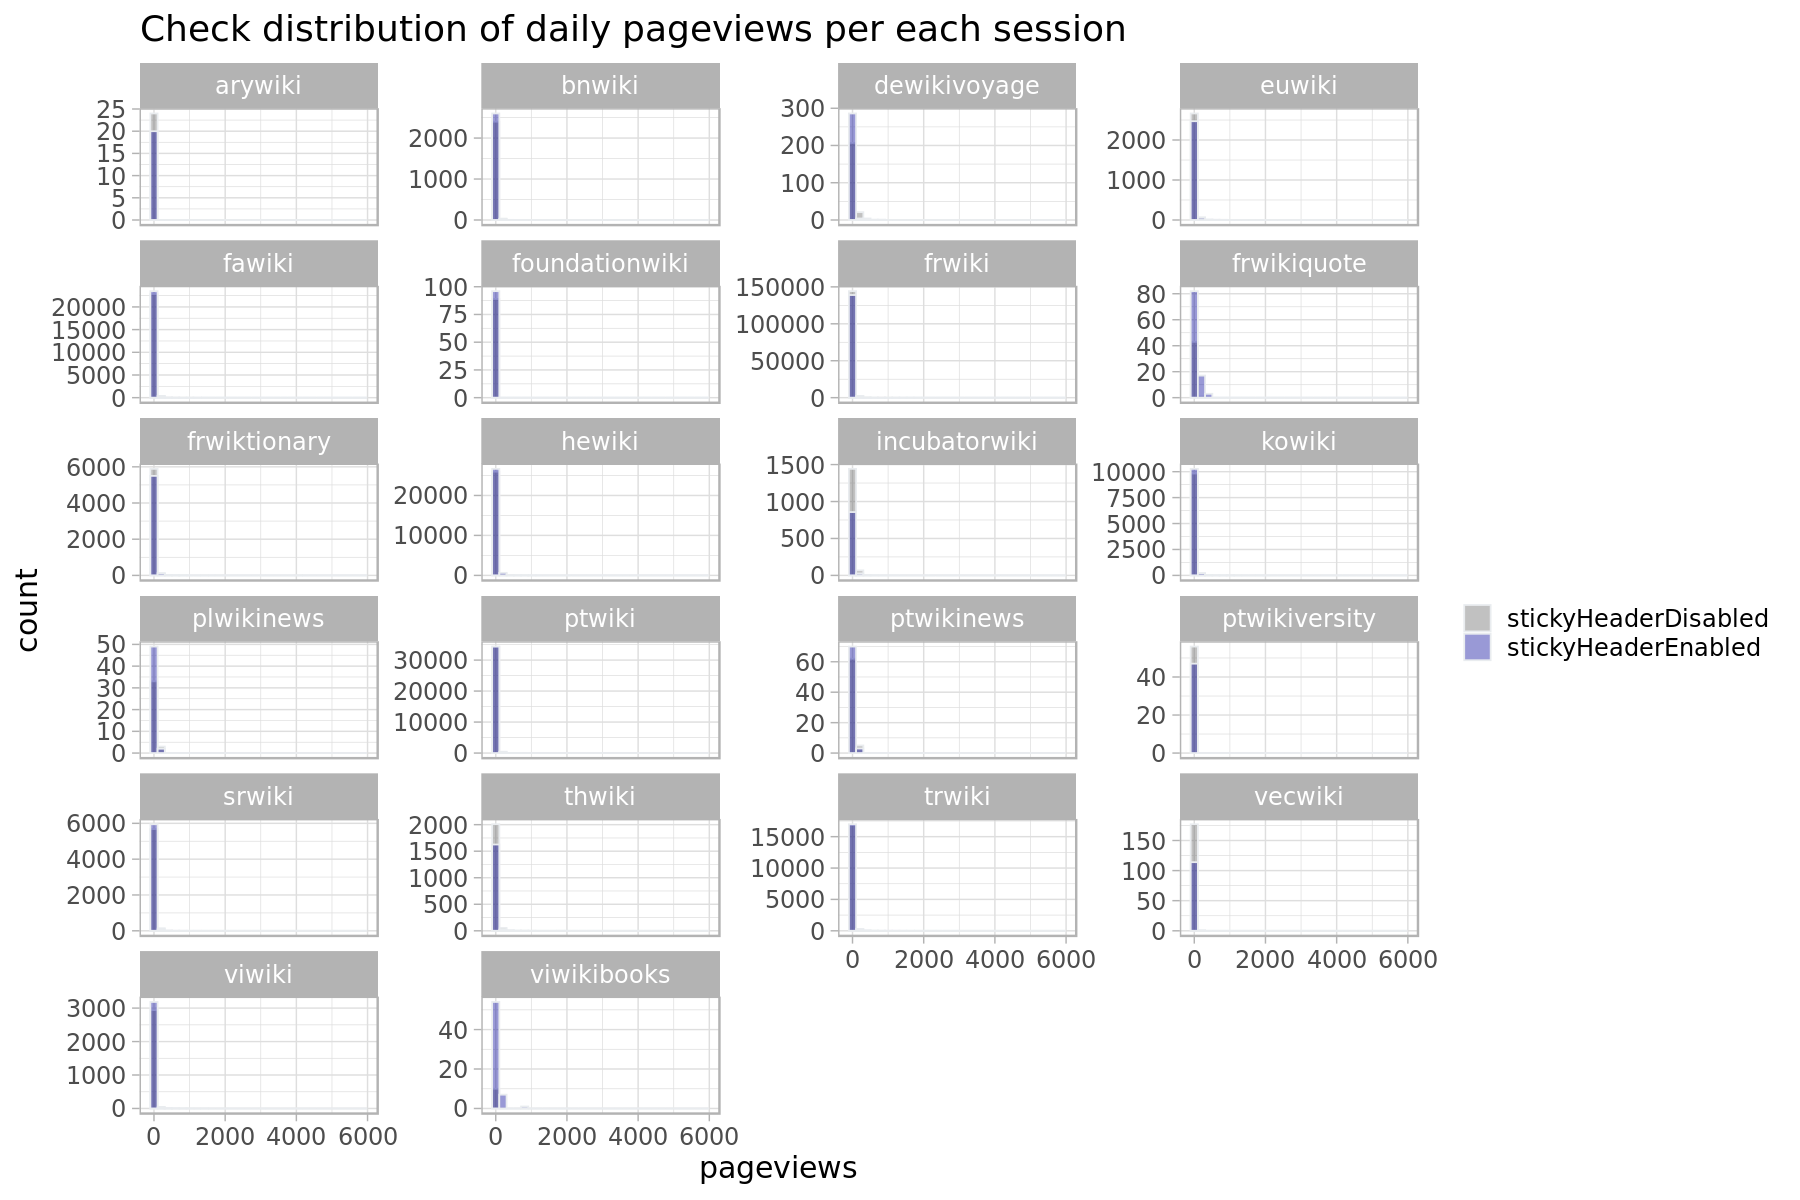

In [21]:
p <- df_pv_dis %>%
 ggplot( aes(x=pageviews, fill=group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
    facet_wrap(~wiki,nrow=6,scale = 'free_y')+
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of daily pageviews per each session",
         fill="") +
    theme_light(base_size=18)
p

In [16]:
head(df_scroll_click)

event_date wiki   test_group           web_session_id       skinversion
1 2022-01-12 ptwiki stickyHeaderEnabled  00001880ed7963ac3291 2          
2 2022-01-19 frwiki stickyHeaderDisabled 00003865ffbaa4f8aadc 2          
3 2022-01-20 frwiki stickyHeaderDisabled 00003865ffbaa4f8aadc 2          
4 2022-01-28 frwiki stickyHeaderEnabled  00007ae27d125152cf65 2          
5 2022-01-27 frwiki stickyHeaderEnabled  00007df8050e6636a40b 2          
6 2022-01-24 fawiki stickyHeaderDisabled 00008648a95cca2bf98e 2          
  scrolls clicks
1  1      NULL  
2 52      16    
3  5      3     
4  1      NULL  
5 10      3     
6  2      NULL

In [22]:
df_scrolls_click_raw <-  merge(df_pv_dis,df_scroll_click ,  by.x=c("wiki","event_date","group","web_session_id"),by.y=c("wiki", "event_date","test_group","web_session_id"),  all.x = TRUE)


In [23]:
df_scrolls_click_raw$clicks <- as.numeric(df_scrolls_click_raw$clicks) 

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [24]:
df_scrolls_click_raw

wiki        event_date group                web_session_id      
1      arywiki     2022-01-19 stickyHeaderDisabled 3ceffd1ac6e6bd09d9ef
2      arywiki     2022-01-19 stickyHeaderEnabled  bfb554b7202578d4d102
3      arywiki     2022-01-20 stickyHeaderDisabled cb0711fc69de1fda483c
4      arywiki     2022-01-20 stickyHeaderDisabled efcbcafbb421f47037cf
5      arywiki     2022-01-21 stickyHeaderDisabled c87fc31429b2131f17d7
6      arywiki     2022-01-21 stickyHeaderDisabled e37b0f25e314eb242dc6
7      arywiki     2022-01-21 stickyHeaderEnabled  674f681c0c08bd4e26ed
8      arywiki     2022-01-21 stickyHeaderEnabled  c424e49ee81ba55f8f7b
9      arywiki     2022-01-22 stickyHeaderDisabled 04446a37b8ccc1944f1c
10     arywiki     2022-01-22 stickyHeaderDisabled 16b118cd04b732bbe277
11     arywiki     2022-01-22 stickyHeaderEnabled  2ef0a1f1fb98a4ce5af5
12     arywiki     2022-01-22 stickyHeaderEnabled  6b7474cd45df2179614d
13     arywiki     2022-01-23 stickyHeaderDisabled 0b754144acacf24c7134
14     arywiki     2022-01-23 stickyHeaderDisabled 1ad24a8b059a654716ed
15     arywiki     2022-01-23 stickyHeaderDisabled 1e19437ae1d2204d2087
16     arywiki     2022-01-23 stickyHeaderDisabled 2608cd69e18cbb409c07
17     arywiki     2022-01-23 stickyHeaderDisabled 6024ba7ec9784fd098ae
18     arywiki     2022-01-23 stickyHeaderEnabled  5b5f8d99c6a3bd333f6c
19     arywiki     2022-01-23 stickyHeaderEnabled  8e0357cafbed524b5488
20     arywiki     2022-01-23 stickyHeaderEnabled  9b5c0ab86fd680f3a9aa
21     arywiki     2022-01-24 stickyHeaderDisabled a2a6f2e8b5d5f51db507
22     arywiki     2022-01-24 stickyHeaderEnabled  b619a4c23f27355201f4
23     arywiki     2022-01-24 stickyHeaderEnabled  df42f11df6224032b5ef
24     arywiki     2022-01-24 stickyHeaderEnabled  f955c1c0e2845fea70c8
25     arywiki     2022-01-25 stickyHeaderDisabled 0b2ba6c9289bc6a07abc
26     arywiki     2022-01-25 stickyHeaderDisabled 0fd662a91adc579e3eb9
27     arywiki     2022-01-25 stickyHeaderDisabled a0964b552e42d0578796
28     arywiki     2022-01-25 stickyHeaderEnabled  144141f10751fa367ec9
29     arywiki     2022-01-25 stickyHeaderEnabled  e547cef811ac2ccece6b
30     arywiki     2022-01-26 stickyHeaderDisabled 270640aa9358b62b843d
⋮      ⋮           ⋮          ⋮                    ⋮                   
562152 viwikibooks 2022-01-24 stickyHeaderEnabled  61013e5173c323e5ec06
562153 viwikibooks 2022-01-24 stickyHeaderEnabled  6415de5d742537995e6f
562154 viwikibooks 2022-01-24 stickyHeaderEnabled  afda5d8d30809fe12395
562155 viwikibooks 2022-01-24 stickyHeaderEnabled  b745cb1d18898d3295ae
562156 viwikibooks 2022-01-25 stickyHeaderDisabled 2ad86cd489fadeeb9d80
562157 viwikibooks 2022-01-25 stickyHeaderDisabled 36cb05868b622b7ae43b
562158 viwikibooks 2022-01-25 stickyHeaderDisabled cd9b183368afd2af3ea5
562159 viwikibooks 2022-01-25 stickyHeaderEnabled  4edee448261438461a51
562160 viwikibooks 2022-01-25 stickyHeaderEnabled  a8a8fc42acab2961e38b
562161 viwikibooks 2022-01-25 stickyHeaderEnabled  adac9d6196d714d95f4c
562162 viwikibooks 2022-01-26 stickyHeaderEnabled  6e01eacc0c1a8f015e0c
562163 viwikibooks 2022-01-26 stickyHeaderEnabled  cb615b058b00f70985d8
562164 viwikibooks 2022-01-27 stickyHeaderEnabled  32b7711c266e888c723a
562165 viwikibooks 2022-01-28 stickyHeaderEnabled  001ad24d92354c435565
562166 viwikibooks 2022-01-28 stickyHeaderEnabled  57c8ae0281bb0d199289
562167 viwikibooks 2022-01-28 stickyHeaderEnabled  859691224f4349a21bfa
562168 viwikibooks 2022-01-28 stickyHeaderEnabled  9190ee59d26c3fca4afb
562169 viwikibooks 2022-01-28 stickyHeaderEnabled  ba123d2c8046b735d01a
562170 viwikibooks 2022-01-28 stickyHeaderEnabled  c783fcc4ce21079efd67
562171 viwikibooks 2022-01-29 stickyHeaderEnabled  04192d9540d86b31452d
562172 viwikibooks 2022-01-29 stickyHeaderEnabled  9190ee59d26c3fca4afb
562173 viwikibooks 2022-01-29 stickyHeaderEnabled  e2c24a90433042bddbcc
562174 viwikibooks 2022-01-29 stickyHeaderEnabled  edea8c46c322f34947d1
562175 viwikibooks 2022-01-29 stickyHeaderEnabl

In [25]:
df_scrolls_click_raw[is.na(df_scrolls_click_raw)] <- 0

In [26]:
summary(df_scrolls_click_raw)

     wiki            event_date           group           web_session_id    
 Length:562181      Length:562181      Length:562181      Length:562181     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
   pageviews       skinversion           scrolls            clicks        
 Min.   :   1.00   Length:562181      Min.   :  0.000   Min.   :  0.0000  
 1st Qu.:   1.00   Class :character   1st Qu.:  0.000   1st Qu.:  0.0000  
 Median :   3.00   Mode  :character   Median :  0.000   Median :  0.0000  
 Mean   :  11.65                      Mean   :  2.932   Mean   :  0.4683  
 3rd Qu.:   8.00                      3rd Qu.:  2.000   3rd Qu.:  0.0000  
 Max.   :58

In [92]:
write_csv(df_scrolls_click_raw, "Data_out_try5/scroll_click_raw.csv")

In [28]:
filter(df_scrolls_click_raw, (skinversion==1)&(group=='stickyHeaderEnabled'))

wiki           event_date group               web_session_id      
1   bnwiki         2022-01-07 stickyHeaderEnabled b2c536a1022537baefbf
2   bnwiki         2022-01-12 stickyHeaderEnabled 833a7d691ea33bfe0910
3   bnwiki         2022-01-18 stickyHeaderEnabled 323c31bd693fa17ab545
4   bnwiki         2022-01-18 stickyHeaderEnabled 3be89cb84ce92de133bb
5   bnwiki         2022-01-29 stickyHeaderEnabled 42446378b9c8c9f01abd
6   euwiki         2022-01-10 stickyHeaderEnabled 0b6c93a1f47439599a09
7   euwiki         2022-01-11 stickyHeaderEnabled 0b6c93a1f47439599a09
8   euwiki         2022-01-24 stickyHeaderEnabled 2da32f0a198e8ddfec78
9   euwiki         2022-01-25 stickyHeaderEnabled 0b6c93a1f47439599a09
10  euwiki         2022-01-25 stickyHeaderEnabled acc22aee5c89882c9051
11  euwiki         2022-01-29 stickyHeaderEnabled 11b4f42eec852ff94a2e
12  fawiki         2022-01-06 stickyHeaderEnabled 82465df8c5cde8a7eb43
13  fawiki         2022-01-09 stickyHeaderEnabled cefb2dde2fe0e30b12a4
14  fawiki         2022-01-11 stickyHeaderEnabled 4ae3b54b0ab9688c28ca
15  fawiki         2022-01-14 stickyHeaderEnabled 186d489550ec22745114
16  fawiki         2022-01-14 stickyHeaderEnabled a99dd3c1d416845ac36f
17  fawiki         2022-01-15 stickyHeaderEnabled 38d642c774df53f6a176
18  fawiki         2022-01-15 stickyHeaderEnabled e66d24c00cf29f9059bf
19  fawiki         2022-01-17 stickyHeaderEnabled 16770e822fb7d458e816
20  fawiki         2022-01-17 stickyHeaderEnabled bc1a8b5725d818fc0b92
21  fawiki         2022-01-18 stickyHeaderEnabled be6dd6ca85c1e16a65f7
22  fawiki         2022-01-25 stickyHeaderEnabled c9668d36070e68bd7680
23  fawiki         2022-01-29 stickyHeaderEnabled 306951b4588a5f38604e
24  fawiki         2022-01-29 stickyHeaderEnabled c59ad5a4a308abd0db7b
25  fawiki         2022-01-30 stickyHeaderEnabled 186d489550ec22745114
26  foundationwiki 2022-01-19 stickyHeaderEnabled d4e154531cc13b6f13df
27  foundationwiki 2022-01-20 stickyHeaderEnabled b623c419a8ba2add7ea8
28  foundationwiki 2022-01-22 stickyHeaderEnabled b623c419a8ba2add7ea8
29  foundationwiki 2022-01-25 stickyHeaderEnabled 6b2f8312247ac3a9b766
30  foundationwiki 2022-01-25 stickyHeaderEnabled b623c419a8ba2add7ea8
⋮   ⋮              ⋮          ⋮                   ⋮                   
558 viwiki         2022-01-28 stickyHeaderEnabled 9358e650b7f0c6dae035
559 viwiki         2022-01-28 stickyHeaderEnabled a21ddae6c943442c61cb
560 viwiki         2022-01-28 stickyHeaderEnabled c21701c6e88abe355c59
561 viwiki         2022-01-28 stickyHeaderEnabled c9696c675554907b7aad
562 viwiki         2022-01-28 stickyHeaderEnabled cfd74d5c71c03b744539
563 viwiki         2022-01-29 stickyHeaderEnabled 1c48fd1cb1458e16568c
564 viwiki         2022-01-29 stickyHeaderEnabled 335fd70e4c1035ea39c2
565 viwiki         2022-01-29 stickyHeaderEnabled 598437d920eee7bc09fc
566 viwiki         2022-01-29 stickyHeaderEnabled 656e9177880a9bf7f76e
567 viwiki         2022-01-29 stickyHeaderEnabled 6ed1b463865cd25d7467
568 viwiki         2022-01-29 stickyHeaderEnabled 9358e650b7f0c6dae035
569 viwiki         2022-01-29 stickyHeaderEnabled 969d3db04654a297af84
570 viwiki         2022-01-29 stickyHeaderEnabled adae7765550aa4825b4a
571 viwiki         2022-01-29 stickyHeaderEnabled ba22e5760a880b5d8ddc
572 viwiki         2022-01-29 stickyHeaderEnabled c21701c6e88abe355c59
573 viwiki         2022-01-29 stickyHeaderEnabled f5d8315a6970e616bdea
574 viwiki         2022-01-30 stickyHeaderEnabled 07220670a6f431410c42
575 viwiki         2022-01-30 stickyHeaderEnabled 085fe7d45508642e123a
576 viwiki         2022-01-30 stickyHeaderEnabled 378134d93ceba1a14a59
577 viwiki         2022-01-30 stickyHeaderEnabled 43d47071bd2c52795797
578 viwiki         2022-01-30 stickyHeaderEnabled 5244bd8ee79fb944a0e9
579 viwiki         2022-01-30 stickyHeaderEnabled 656e9177880a9bf7f76e
580 viwiki         2022-01-30 stickyHeaderEnabled 6ed1b463865cd25d7467
581 viwiki         2022-01-30 stickyHeaderEnabled 704f36fd705675008bfa
582 viwiki         2022-01-3

__Note:__  

587 sessions in stikyHeaderEnabled group has skin 1 version. They will only see the old feature. Exclude them in treatment group (stikyHeaderEnabled).

In [29]:
df <- df_scrolls_click_raw %>%
  # only test the scrolls which has click intention
  filter(clicks>0) %>%
  filter(((skinversion==2)&(group=='stickyHeaderEnabled'))|(group=='stickyHeaderDisabled'))

In [90]:
head(df)

wiki    event_date group                web_session_id       pageviews
1 arywiki 2022-01-23 stickyHeaderEnabled  8e0357cafbed524b5488  5       
2 bnwiki  2022-01-06 stickyHeaderDisabled 3722c70221a2a18fc06b  5       
3 bnwiki  2022-01-06 stickyHeaderDisabled 4d7cd5f0b509933e958c 11       
4 bnwiki  2022-01-06 stickyHeaderDisabled 612b77d2a4bce0168040 14       
5 bnwiki  2022-01-06 stickyHeaderDisabled 626317f33d59e4a85945  4       
6 bnwiki  2022-01-06 stickyHeaderDisabled 6f8ec06eb8105cf51dbd 19       
  skinversion scrolls clicks
1 2           1       1     
2 2           2       3     
3 2           2       1     
4 2           5       2     
5 2           3       3     
6 2           5       2

In [91]:
summary(df)

     wiki            event_date           group           web_session_id    
 Length:58971       Length:58971       Length:58971       Length:58971      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
   pageviews       skinversion           scrolls          clicks       
 Min.   :   1.00   Length:58971       Min.   :  1.0   Min.   :  1.000  
 1st Qu.:  11.00   Class :character   1st Qu.:  2.0   1st Qu.:  1.000  
 Median :  25.00   Mode  :character   Median :  6.0   Median :  2.000  
 Mean   :  57.78                      Mean   : 13.9   Mean   :  4.444  
 3rd Qu.:  60.00                      3rd Qu.: 16.0   3rd Qu.:  4.000  
 Max.   :5886.00             

In [32]:
df_scrolls_tmp <- df %>%
   group_by(wiki, group) %>%
   summarize( pageviews=sum(pageviews), scrolls=sum(scrolls), clicks=sum(clicks), sessions=n_distinct(web_session_id),.groups='drop') 


In [33]:
head(df_scrolls_tmp)

wiki         group                pageviews scrolls clicks sessions
1 arywiki      stickyHeaderEnabled      5        1       1     1     
2 bnwiki       stickyHeaderDisabled 14278     3957     991   325     
3 bnwiki       stickyHeaderEnabled  13492     4382    1170   360     
4 dewikivoyage stickyHeaderDisabled  4554      645      93    35     
5 dewikivoyage stickyHeaderEnabled   1864      532     115    52     
6 euwiki       stickyHeaderDisabled 31404     7765    1321   421

In [34]:
df_scrolls<-rename(df_scrolls_tmp, test_group=group)

In [35]:
write_csv(df_scrolls, "Data_out_try5/scrolls.csv")

### Data Analaysis

In [36]:
head(df_scrolls)

wiki         test_group           pageviews scrolls clicks sessions
1 arywiki      stickyHeaderEnabled      5        1       1     1     
2 bnwiki       stickyHeaderDisabled 14278     3957     991   325     
3 bnwiki       stickyHeaderEnabled  13492     4382    1170   360     
4 dewikivoyage stickyHeaderDisabled  4554      645      93    35     
5 dewikivoyage stickyHeaderEnabled   1864      532     115    52     
6 euwiki       stickyHeaderDisabled 31404     7765    1321   421

In [37]:
df_scrolls <- df_scrolls %>%
 mutate(scrolls_per_pv=round(scrolls/pageviews , 4))

In [38]:
df_scrolls <- df_scrolls %>%
 mutate(scrolls_per_session=round(scrolls/sessions , 4))

In [39]:
head(df_scrolls)

wiki         test_group           pageviews scrolls clicks sessions
1 arywiki      stickyHeaderEnabled      5        1       1     1     
2 bnwiki       stickyHeaderDisabled 14278     3957     991   325     
3 bnwiki       stickyHeaderEnabled  13492     4382    1170   360     
4 dewikivoyage stickyHeaderDisabled  4554      645      93    35     
5 dewikivoyage stickyHeaderEnabled   1864      532     115    52     
6 euwiki       stickyHeaderDisabled 31404     7765    1321   421     
  scrolls_per_pv scrolls_per_session
1 0.2000          1.0000            
2 0.2771         12.1754            
3 0.3248         12.1722            
4 0.1416         18.4286            
5 0.2854         10.2308            
6 0.2473         18.4442

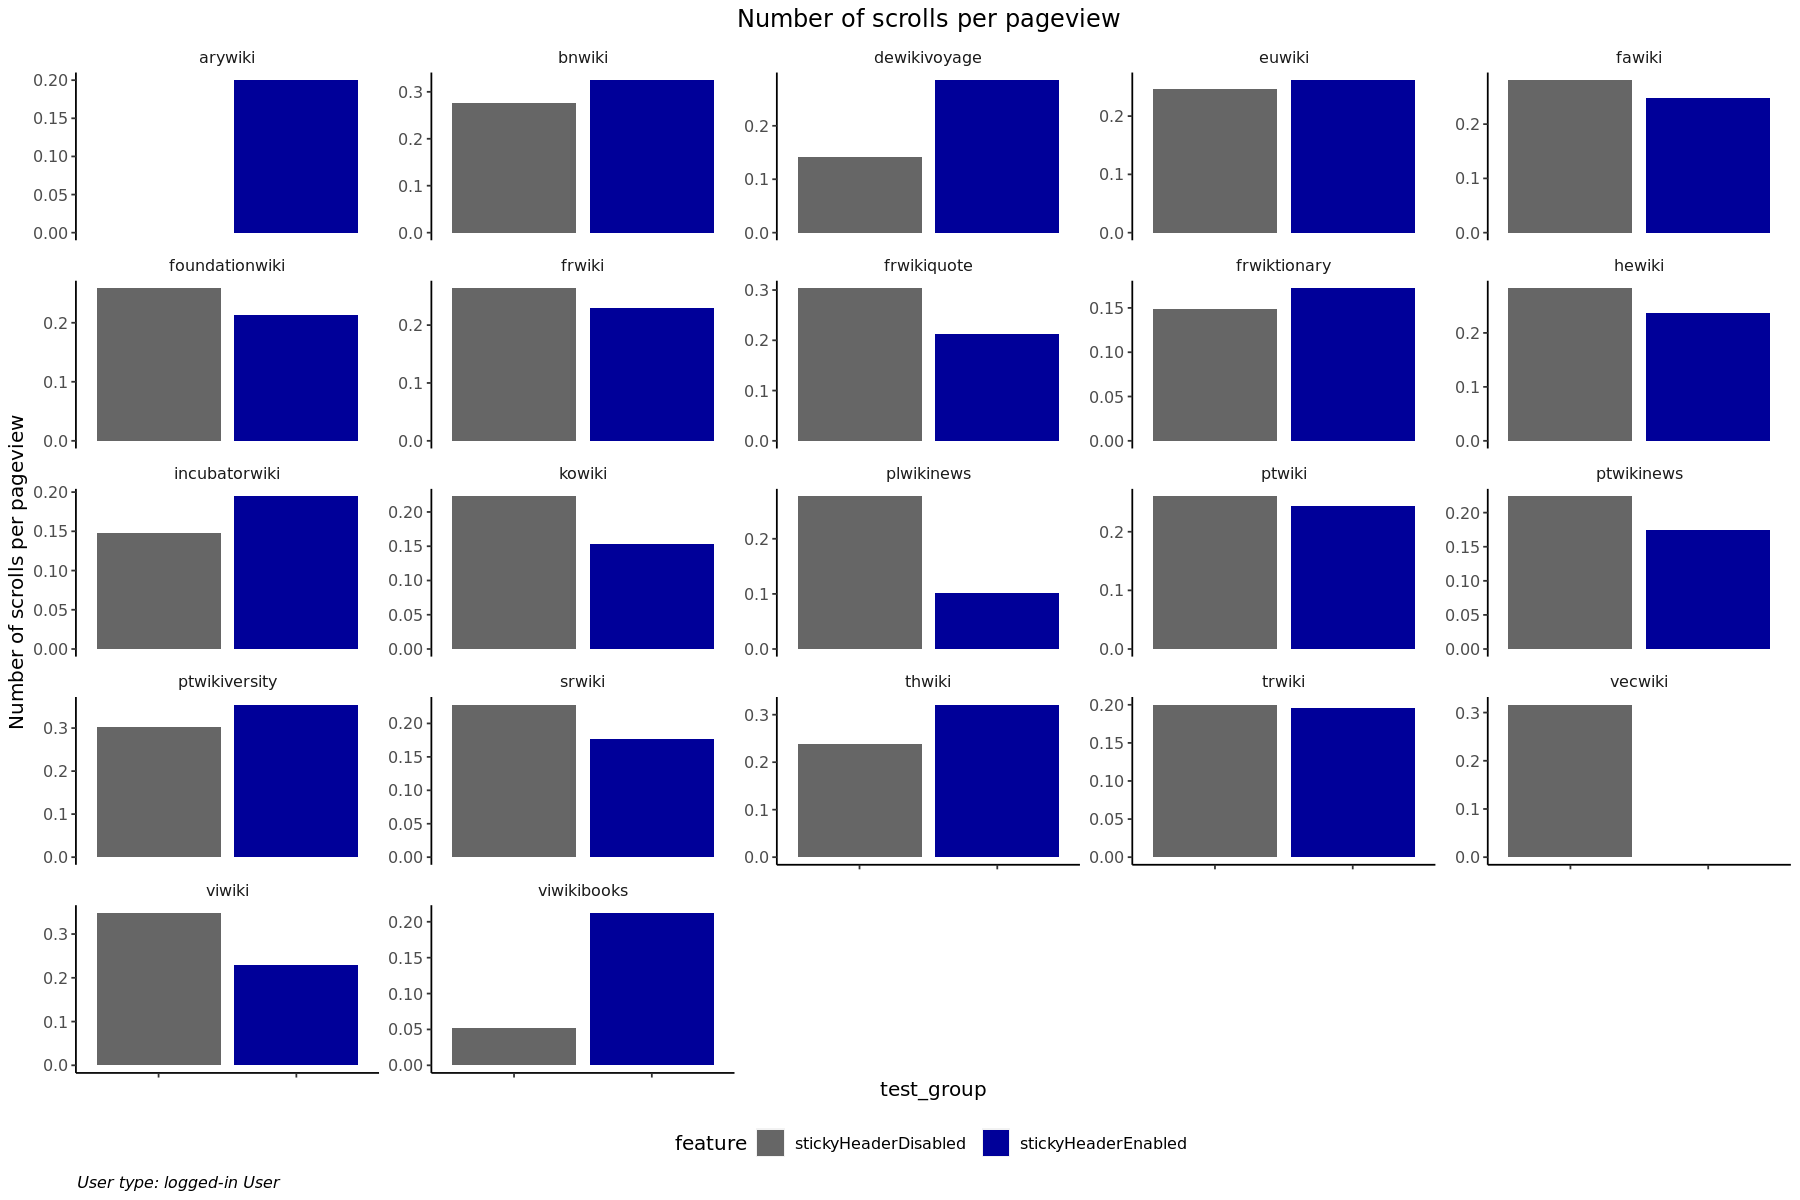

In [48]:
barchart_scroll_per_pv_overall  <- df_scrolls  %>%
        select(wiki, test_group, scrolls_per_pv) %>%
        ggplot(aes(x = test_group, y= scrolls_per_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls per pageview" ,
             title = "Number of scrolls per pageview " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scroll_per_pv_overall

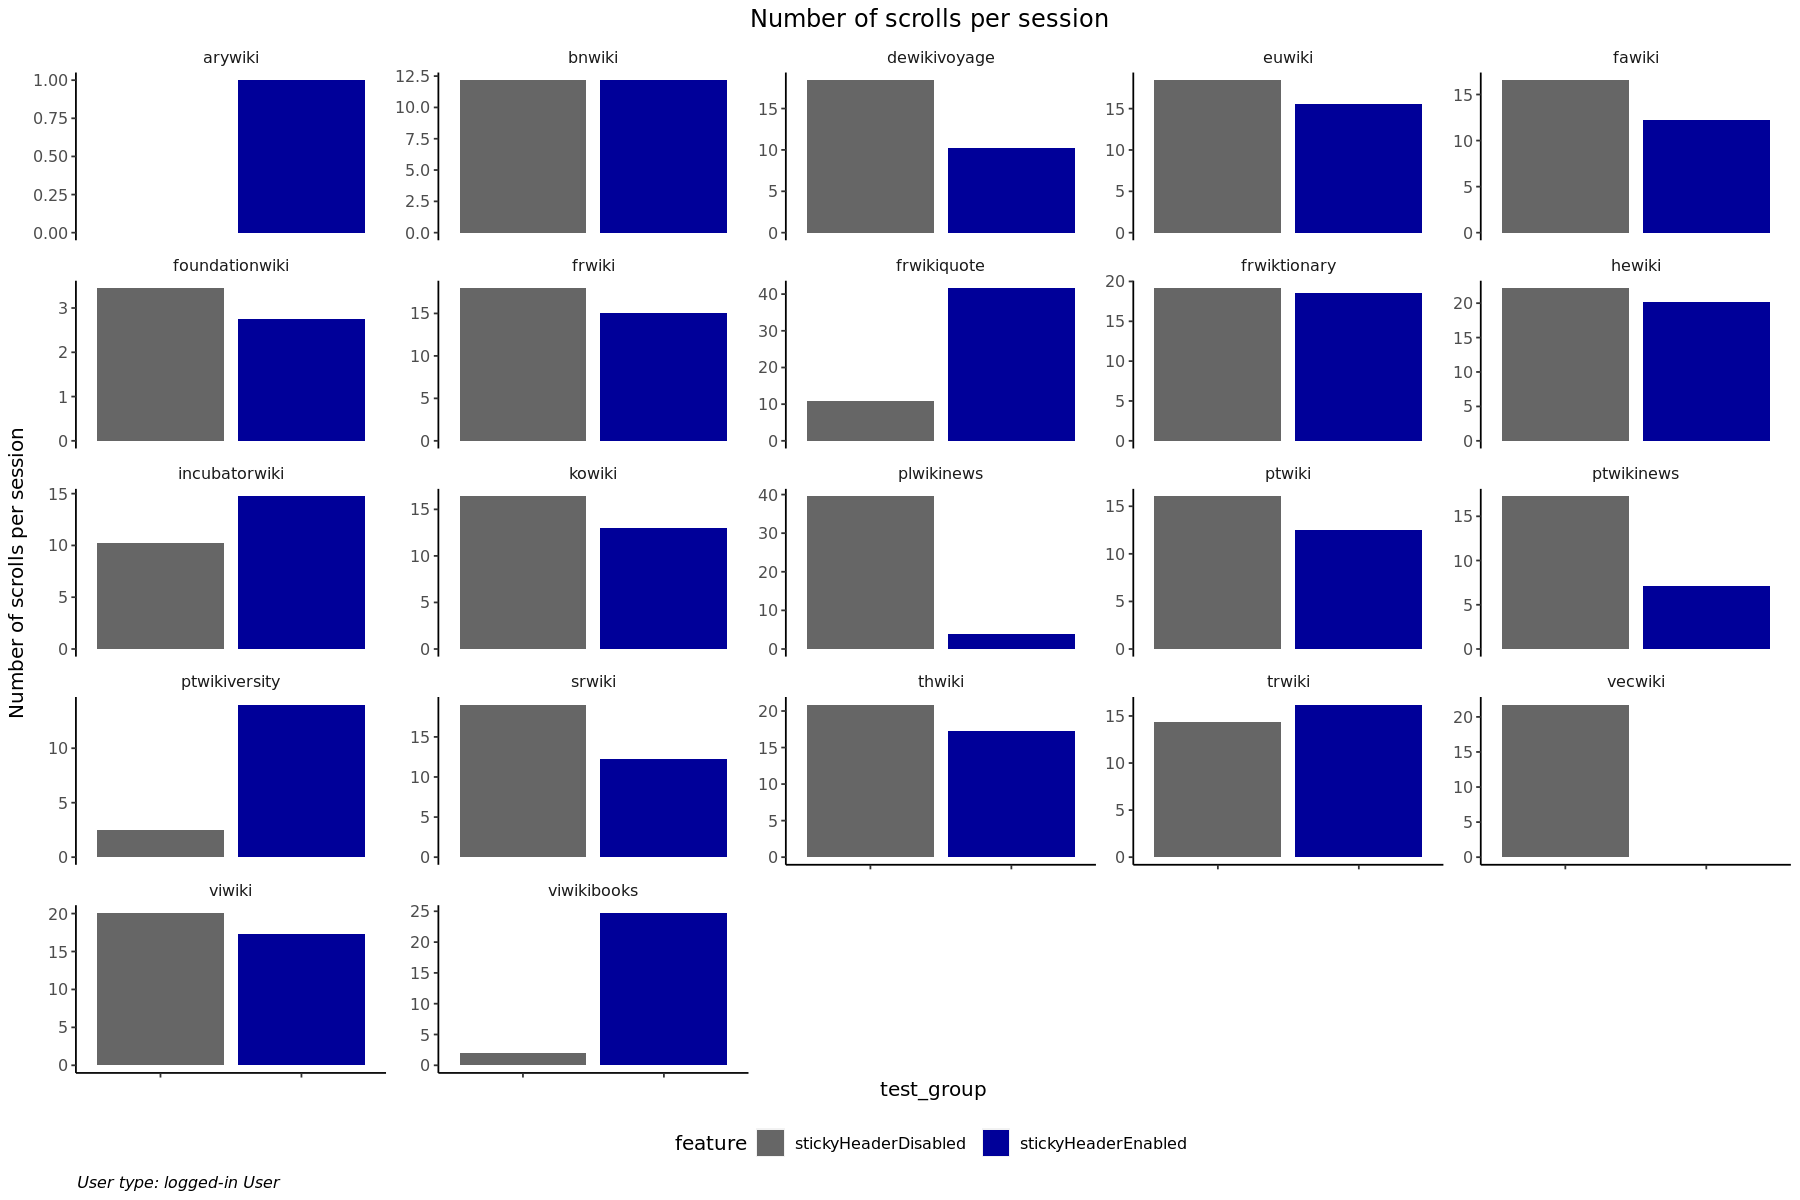

In [47]:
barchart_scroll_per_session_overall  <- df_scrolls  %>%
        select(wiki, test_group, scrolls_per_session) %>%
        ggplot(aes(x = test_group, y= scrolls_per_session, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls per session" ,
             title = "Number of scrolls per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scroll_per_session_overall

### Data Analysis

#### Metrics: scrolles per session

In [56]:
filter(df_scrolls, sessions<=10)

wiki           test_group           pageviews scrolls clicks sessions
1  arywiki        stickyHeaderEnabled    5         1      1      1      
2  foundationwiki stickyHeaderDisabled 120        31     21      9      
3  foundationwiki stickyHeaderEnabled  103        22     24      8      
4  frwikiquote    stickyHeaderDisabled 356       108     36     10      
5  plwikinews     stickyHeaderDisabled 571       158     19      4      
6  plwikinews     stickyHeaderEnabled  118        12      5      3      
7  ptwikiversity  stickyHeaderDisabled  33        10      5      4      
8  ptwikiversity  stickyHeaderEnabled  237        84     41      6      
9  vecwiki        stickyHeaderDisabled 275        87     10      4      
10 viwikibooks    stickyHeaderDisabled  38         2      4      1      
   scrolls_per_pv scrolls_per_session
1  0.2000          1.0000            
2  0.2583          3.4444            
3  0.2136          2.7500            
4  0.3034         10.8000            
5  0.2767         39.5000            
6  0.1017          4.0000            
7  0.3030          2.5000            
8  0.3544         14.0000            
9  0.3164         21.7500            
10 0.0526          2.0000

In [64]:
df_test_session <- df_scrolls %>%
    select(wiki, test_group,sessions, scrolls, scrolls_per_session) %>%
    #filter((wiki!='arywiki')&(wiki!='viwikibooks')&(wiki!='plwikinews')&(wiki!='ptwikinews')&(wiki!='ptwikiversity')) %>%
    #filter((wiki!='arywiki')&(wiki!='viwikibooks')) %>% 
    pivot_wider(names_from = test_group, values_from = c(sessions, scrolls, scrolls_per_session), values_fill = 0)

In [68]:
filter(df_test_session,sessions_stickyHeaderDisabled<=10)

wiki           sessions_stickyHeaderEnabled sessions_stickyHeaderDisabled
1 arywiki         1                            0                           
2 foundationwiki  8                            9                           
3 frwikiquote    19                           10                           
4 plwikinews      3                            4                           
5 ptwikiversity   6                            4                           
6 vecwiki         0                            4                           
7 viwikibooks    20                            1                           
  scrolls_stickyHeaderEnabled scrolls_stickyHeaderDisabled
1   1                           0                         
2  22                          31                         
3 790                         108                         
4  12                         158                         
5  84                          10                         
6   0                          87                         
7 495                           2                         
  scrolls_per_session_stickyHeaderEnabled
1  1.0000                                
2  2.7500                                
3 41.5789                                
4  4.0000                                
5 14.0000                                
6  0.0000                                
7 24.7500                                
  scrolls_per_session_stickyHeaderDisabled
1  0.0000                                 
2  3.4444                                 
3 10.8000                                 
4 39.5000                                 
5  2.5000                                 
6 21.7500                                 
7  2.0000

In [69]:
x <- filter(df_test_session,sessions_stickyHeaderDisabled>10)$scrolls_per_session_stickyHeaderDisabled
y <- filter(df_test_session,sessions_stickyHeaderDisabled>10)$scrolls_per_session_stickyHeaderEnabled
result_2 <- t.test(x, y, alternative = "greater", paired = TRUE, var.equal = FALSE,
              conf.level = 0.95 )  

In [70]:
result_2


	Paired t-test

data:  x and y
t = 3.135, df = 14, p-value = 0.003653
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 1.301816      Inf
sample estimates:
mean of the differences 
                2.97102 


__Note:__ 

p-value < 0.05. We can reject null hypothsis. It means scrolls per sessions in treatment group is less than control group significantly. 

We exclude the 7 wikis which has less than 10 sessions in analysis. They are arywiki, foundationwiki, frwikiquote,
plwikinews, ptwikiversity,	vecwiki, viwikibooks.

In [80]:
df_test_session <- df_test_session %>%
  mutate(
        pct_change = round((scrolls_per_session_stickyHeaderEnabled-scrolls_per_session_stickyHeaderDisabled)/scrolls_per_session_stickyHeaderDisabled * 100 , 2)
        )
 


In [86]:
df_test_session <- df_test_session %>%
  mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'foundationwiki' ~ 'Wikimedia Foundation',
        wiki == 'ptwikinews' ~'Portuguese Wikinews',
        wiki == 'thwiki' ~'Thai Wikipedia',
        wiki == 'viwiki' ~'Vietnamese Wikipedia',
        wiki == 'viwikibooks' ~'Vietnamese Wikibooks',
        wiki == 'plwikinews' ~'Polish Wikinews',
        wiki == 'arywiki' ~'Moroccan Arabic Wikipedia',
        wiki == 'frwikiquote' ~'French Wikiquote',
        wiki == 'incubatorwiki' ~'Wikimedia Incubator' )
 )

In [87]:
filter(df_test_session,sessions_stickyHeaderDisabled>10)

wiki          sessions_stickyHeaderEnabled sessions_stickyHeaderDisabled
1  bnwiki          360                          325                        
2  dewikivoyage     52                           35                        
3  euwiki          326                          421                        
4  fawiki         2645                         2727                        
5  frwiki        12458                        11615                        
6  frwiktionary    363                          251                        
7  hewiki         2696                         2493                        
8  incubatorwiki   101                          156                        
9  kowiki         1197                          962                        
10 ptwiki         2971                         2485                        
11 ptwikinews       18                           21                        
12 srwiki          424                          499                        
13 thwiki          154                          257                        
14 trwiki         1644                         2056                        
15 viwiki          259                          305                        
   scrolls_stickyHeaderEnabled scrolls_stickyHeaderDisabled
1    4382                        3957                      
2     532                         645                      
3    5091                        7765                      
4   32408                       45153                      
5  187123                      208519                      
6    6730                        4803                      
7   54258                       55227                      
8    1487                        1598                      
9   15590                       15761                      
10  37119                       39826                      
11    129                         362                      
12   5201                        9491                      
13   2668                        5363                      
14  26640                       29550                      
15   4500                        6131                      
   scrolls_per_session_stickyHeaderEnabled
1  12.1722                                
2  10.2308                                
3  15.6166                                
4  12.2526                                
5  15.0203                                
6  18.5399                                
7  20.1254                                
8  14.7228                                
9  13.0242                                
10 12.4938                                
11  7.1667                                
12 12.2665                                
13 17.3247                                
14 16.2044                                
15 17.3745                                
   scrolls_per_session_stickyHeaderDisabled pct_change wiki_name           
1  12.1754                                   -0.03     Bengali Wikipedia   
2  18.4286                                  -44.48     German Wikivoyage   
3  18.4442                                  -15.33     Basque Wikipedia    
4  16.5578                                  -26.00     Persian Wikipedia   
5  17.9526                                  -16.33     French Wikipedia    
6  19.1355                                   -3.11     French Wikitionary  
7  22.1528                                   -9.15     Hebrew Wikipedia    
8  10.2436                                   43.73     Wikimedia Incubator 
9  16.3836                                  -20.50     Korean Wikipedia    
10 16.0266                                  -22.04     Portuguese Wikipedia
11 17.2381                                  -58.43     Portuguese Wikinews 
12 19.0200                                  -35.51     Serbian Wikipedia   
13 20.8677                                  -16.98     Thai Wikipedia      
14 14.3726                                   12.75     Turkish Wikipedia   

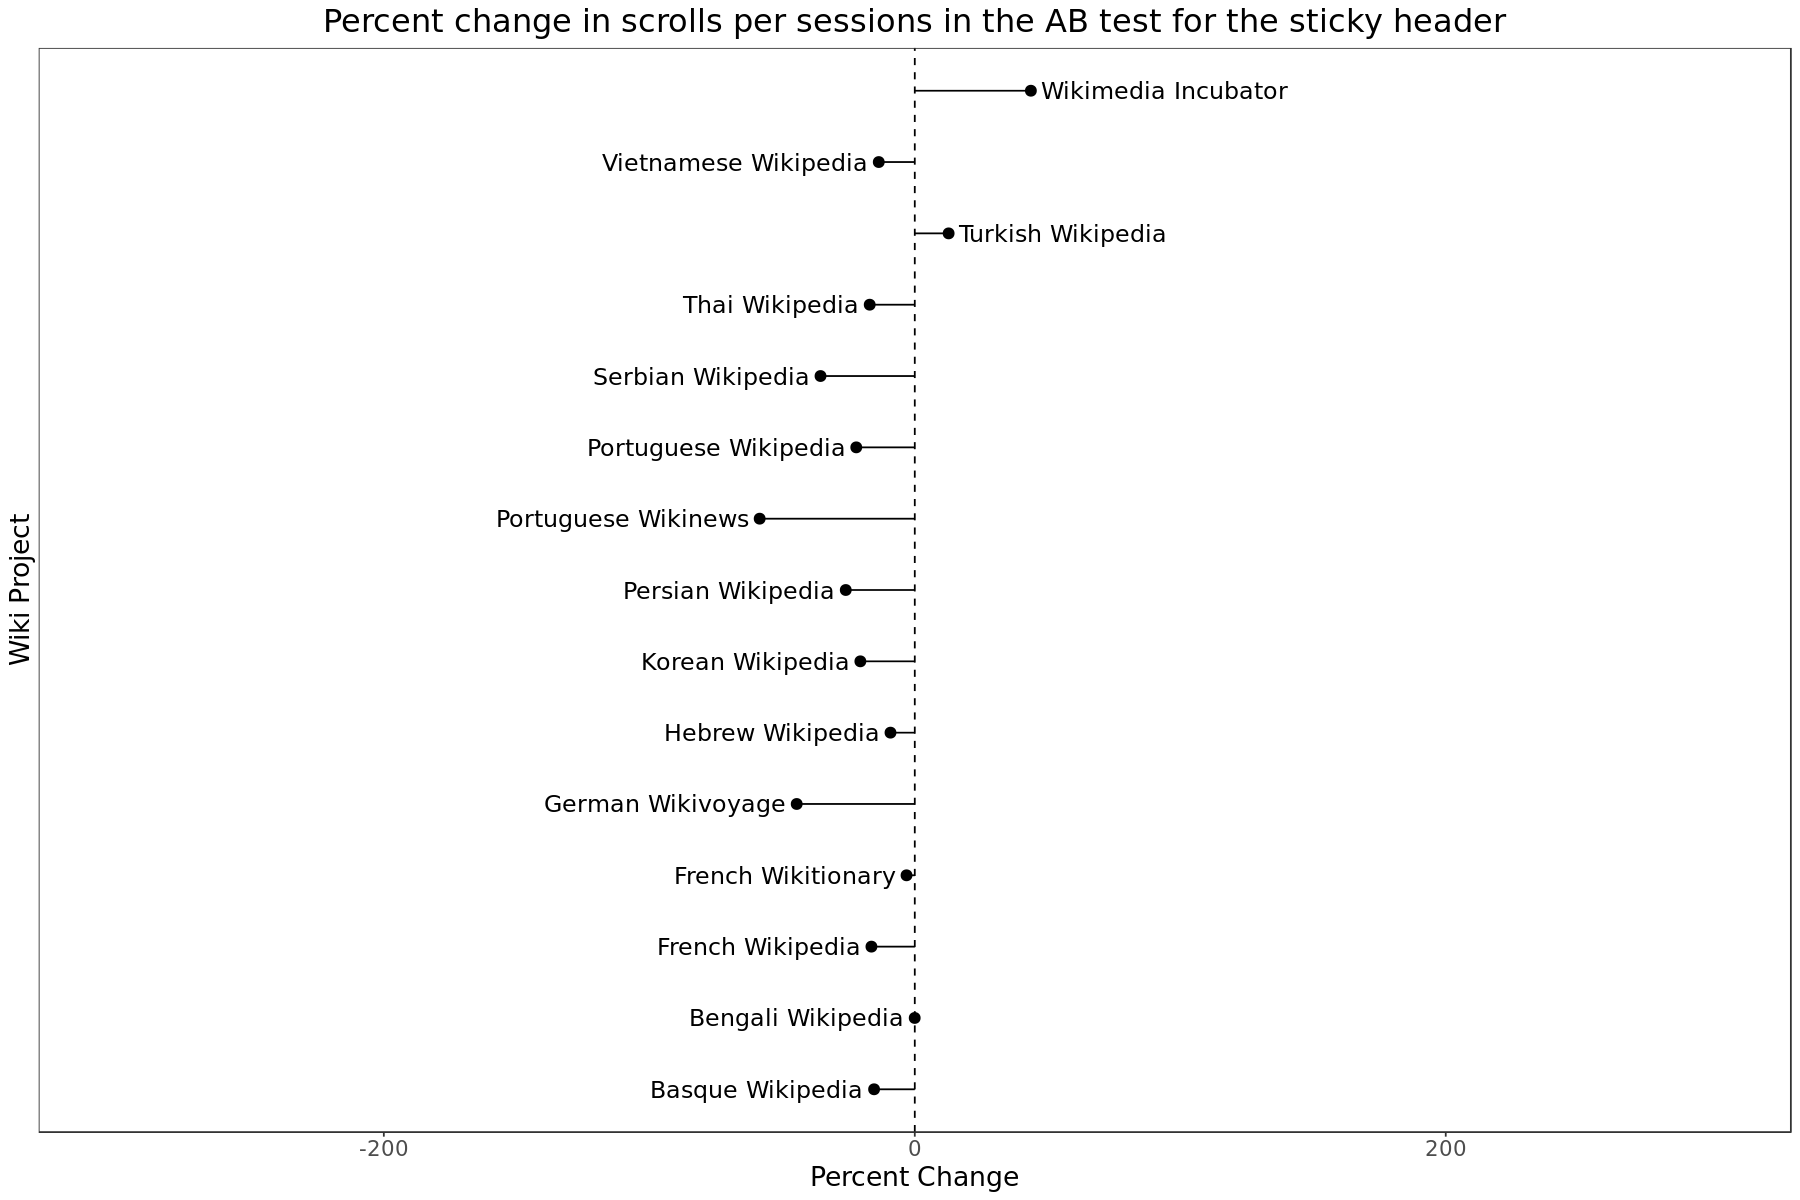

In [88]:
pct_g <- df_test_session %>%
  filter(sessions_stickyHeaderDisabled>10) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in scrolls per sessions in the AB test for the sticky header") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Metrics: scrolles per pageview__

In [72]:
df_test_pv <- df_scrolls %>%
    select(wiki, test_group,sessions, pageviews, scrolls_per_pv) %>%
    pivot_wider(names_from = test_group, values_from = c(sessions, pageviews, scrolls_per_pv), values_fill = 0)

In [73]:
df_test_pv

wiki           sessions_stickyHeaderEnabled sessions_stickyHeaderDisabled
1  arywiki            1                            0                        
2  bnwiki           360                          325                        
3  dewikivoyage      52                           35                        
4  euwiki           326                          421                        
5  fawiki          2645                         2727                        
6  foundationwiki     8                            9                        
7  frwiki         12458                        11615                        
8  frwikiquote       19                           10                        
9  frwiktionary     363                          251                        
10 hewiki          2696                         2493                        
11 incubatorwiki    101                          156                        
12 kowiki          1197                          962                        
13 plwikinews         3                            4                        
14 ptwiki          2971                         2485                        
15 ptwikinews        18                           21                        
16 ptwikiversity      6                            4                        
17 srwiki           424                          499                        
18 thwiki           154                          257                        
19 trwiki          1644                         2056                        
20 vecwiki            0                            4                        
21 viwiki           259                          305                        
22 viwikibooks       20                            1                        
   pageviews_stickyHeaderEnabled pageviews_stickyHeaderDisabled
1       5                             0                        
2   13492                         14278                        
3    1864                          4554                        
4   19462                         31404                        
5  130810                        160699                        
6     103                           120                        
7  812686                        791438                        
8    3726                           356                        
9   39100                         32302                        
10 229952                        195397                        
11   7648                         10815                        
12 102065                         70811                        
13    118                           571                        
14 152123                        153145                        
15    742                          1618                        
16    237                            33                        
17  29540                         41612                        
18   8306                         22450                        
19 136364                        147574                        
20      0                           275                        
21  19655                         17591                        
22   2329                            38                        
   scrolls_per_pv_stickyHeaderEnabled scrolls_per_pv_stickyHeaderDisabled
1  0.2000                             0.0000                             
2  0.3248                             0.2771                             
3  0.2854                             0.1416                             
4  0.2616                             0.2473                             
5  0.2477                             0.2810                             
6  0.2136                             0.2583                             
7  0.2303                             0.2635                             
8  0.2120                             0.3034                             
9  0.1721                             0.1487                             
10 0.2360           

In [75]:
x <- filter(df_test_pv,sessions_stickyHeaderDisabled>10)$scrolls_per_pv_stickyHeaderDisabled
y <- filter(df_test_pv,sessions_stickyHeaderDisabled>10)$scrolls_per_pv_stickyHeaderEnabled
result_1 <- t.test(x, y, alternative = "greater", paired = TRUE, var.equal = FALSE,
              conf.level = 0.95 ) 

In [76]:
result_1


	Paired t-test

data:  x and y
t = 0.26203, df = 14, p-value = 0.3986
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.02563414         Inf
sample estimates:
mean of the differences 
                0.00448 


__Note:__ 

p-value > 0.05. We can reject null hypothsis. It means scrolls per pv in treatment group is not significantly less than that in control group.

# What is the clickthrough rate (per pageview or per session) of each item on the sticky header

### Data Exploration

In [65]:
query_qa <- "
SELECT event.isAnon, event.skinversion,  event.name,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking
WHERE wiki NOT IN ('testwiki','test2wiki') 
AND year=2022 and month=1 and day=20
AND event.name in ( 
-- event name on top header
'ui.dropdown-p-personal','pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 
'pt-mycontris', 'pt-logout', 'ui.dropdown-p-lang',
'ca-history','ca-talk', 'pt-userpage',
-- event name on sticky header
'ui.dropdown-p-personal-sticky-header','pt-watchlist-sticky-header', 'pt-mytalk-sticky-header', 
'pt-sandbox-sticky-header','pt-preferences-sticky-header', 'pt-betafeatures-sticky-header', 
'pt-mycontris-sticky-header', 'pt-logout-sticky-header','ui.dropdown-p-lang-btn-sticky-header' ,
'history-sticky-header', 'talk-sticky-header', 'pt-userpage-sticky-header'
)
AND event.action='click'
GROUP BY event.isAnon, event.skinversion, event.name
ORDER BY event.isAnon, event.name, event.skinversion
LIMIT 100000
"

In [66]:
df_qa <- wmfdata::query_hive(query_qa)

Don't forget to authenticate with Kerberos using kinit



In [67]:
df_qa

isanon skinversion name                                 clicks
1  false  1           ca-history                           20374 
2  false  2           ca-history                            1924 
3  false  1           ca-talk                               8380 
4  false  2           ca-talk                                796 
5  false  2           history-sticky-header                   22 
6  false  2           pt-betafeatures                         57 
7  false  2           pt-betafeatures-sticky-header            4 
8  false  1           pt-logout                                5 
9  false  2           pt-logout                              222 
10 false  2           pt-logout-sticky-header                  3 
11 false  1           pt-mycontris                           155 
12 false  2           pt-mycontris                           861 
13 false  2           pt-mycontris-sticky-header              26 
14 false  1           pt-mytalk                              129 
15 false  2           pt-mytalk                              124 
16 false  2           pt-mytalk-sticky-header                  1 
17 false  1           pt-preferences                           1 
18 false  2           pt-preferences                         106 
19 false  2           pt-preferences-sticky-header             1 
20 false  1           pt-sandbox                               3 
21 false  2           pt-sandbox                             222 
22 false  2           pt-sandbox-sticky-header                 7 
23 false  1           pt-userpage                           1887 
24 false  2           pt-userpage                              2 
25 false  2           pt-userpage-sticky-header               16 
26 false  1           pt-watchlist                           161 
27 false  2           pt-watchlist                           733 
28 false  2           pt-watchlist-sticky-header              16 
29 false  2           talk-sticky-header                      21 
30 false  2           ui.dropdown-p-lang-btn-sticky-header   301 
31 false  2           ui.dropdown-p-personal                9889 
32 false  2           ui.dropdown-p-personal-sticky-header   316 
33 true   1           ca-history                              15 
34 true   2           ca-history                             913 
35 true   1           ca-talk                                 23 
36 true   2           ca-talk                                658 
37 true   2           ui.dropdown-p-personal                2899 
38 true   2           ui.dropdown-p-personal-sticky-header     1

Note: we only need to look into skinversion==2 and event.isAnon==false. Users with skinverion==1 will not see the new feature. 

In [62]:
query_qa <- "
SELECT event.isAnon, event.skinversion,  count(1) AS inits
FROM event.DesktopWebUIActionsTracking
WHERE wiki NOT IN ('testwiki','test2wiki') 
AND year=2022 and month=1 and day=20
AND event.action='init'
GROUP BY event.isAnon, event.skinversion
ORDER BY event.isAnon,  event.skinversion
LIMIT 100000
"

In [63]:
df_qa <- wmfdata::query_hive(query_qa)

Don't forget to authenticate with Kerberos using kinit



In [64]:
df_qa

isanon skinversion inits  
1 false  1           4152307
2 false  2            352680
3 true   1            135567
4 true   2           2639805

In [26]:
query_pageview <- 
"
SELECT  TO_DATE(meta.dt) AS date_time, meta.domain,
 `group` AS test_group, COUNT(1) AS pageviews, count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki!='testwiki' and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  TO_DATE(meta.dt), meta.domain, `group`
"



In [27]:
df <- wmfdata::query_hive(query_pageview)

Don't forget to authenticate with Kerberos using kinit



In [28]:
df

date_time  domain                    test_group           pageviews
1   2022-01-06 bn.wikipedia.org          stickyHeaderDisabled   505    
2   2022-01-06 eu.wikipedia.org          stickyHeaderDisabled  2056    
3   2022-01-06 fr.wikipedia.org          stickyHeaderDisabled 67128    
4   2022-01-06 fr.wikipedia.org          stickyHeaderEnabled  64012    
5   2022-01-06 he.wikipedia.org          stickyHeaderDisabled 13656    
6   2022-01-06 incubator.wikimedia.org   stickyHeaderDisabled  1141    
7   2022-01-06 ko.wikipedia.org          stickyHeaderDisabled  4258    
8   2022-01-06 ko.wikipedia.org          stickyHeaderEnabled   9051    
9   2022-01-06 sr.wikipedia.org          stickyHeaderDisabled  2697    
10  2022-01-07 de.wikivoyage.org         stickyHeaderEnabled    141    
11  2022-01-07 fr.wiktionary.org         stickyHeaderEnabled   2742    
12  2022-01-07 ko.wikipedia.iwiki.eu.org stickyHeaderDisabled     4    
13  2022-01-07 pt.wikiversity.org        stickyHeaderDisabled     3    
14  2022-01-07 pt.wikiversity.org        stickyHeaderEnabled     59    
15  2022-01-07 tr.wikipedia.org          stickyHeaderDisabled  8454    
16  2022-01-07 tr.wikipedia.org          stickyHeaderEnabled   7123    
17  2022-01-07 vec.wikipedia.org         stickyHeaderEnabled     20    
18  2022-01-08 bn.wikipedia.org          stickyHeaderEnabled    794    
19  2022-01-08 de.wikivoyage.org         stickyHeaderDisabled   206    
20  2022-01-08 eu.wikipedia.org          stickyHeaderEnabled   1044    
21  2022-01-08 fa.wikipedia.org          stickyHeaderDisabled 10992    
22  2022-01-08 fa.wikipedia.org          stickyHeaderEnabled  10907    
23  2022-01-08 fr.wiktionary.org         stickyHeaderDisabled  6530    
24  2022-01-08 he.wikipedia.org          stickyHeaderEnabled  14256    
25  2022-01-08 incubator.wikimedia.org   stickyHeaderEnabled   1774    
26  2022-01-08 pt.wikipedia.org          stickyHeaderDisabled 12844    
27  2022-01-08 pt.wikipedia.org          stickyHeaderEnabled  12376    
28  2022-01-08 sr.wikipedia.org          stickyHeaderEnabled   3211    
29  2022-01-08 vec.wikipedia.org         stickyHeaderDisabled    16    
30  2022-01-09 bn.wikipedia.org          stickyHeaderDisabled   814    
⋮   ⋮          ⋮                         ⋮                    ⋮        
896 2022-01-28 pt.wikipedia.org          stickyHeaderEnabled  14046    
897 2022-01-28 sr.wikipedia.org          stickyHeaderEnabled   1795    
898 2022-01-28 th.wikipedia.org          stickyHeaderDisabled  4742    
899 2022-01-28 vec.wikipedia.org         stickyHeaderDisabled     8    
900 2022-01-28 vi.wikibooks.org          stickyHeaderEnabled    294    
901 2022-01-28 vi.wikipedia.org          stickyHeaderDisabled  2815    
902 2022-01-29 ary.wikipedia.org         stickyHeaderDisabled     2    
903 2022-01-29 ary.wikipedia.org         stickyHeaderEnabled      5    
904 2022-01-29 bn.wikipedia.org          stickyHeaderDisabled   921    
905 2022-01-29 eu.wikipedia.org          stickyHeaderDisabled  1639    
906 2022-01-29 fr.wikipedia.org          stickyHeaderDisabled 60916    
907 2022-01-29 fr.wikipedia.org          stickyHeaderEnabled  57251    
908 2022-01-29 fr.wikiquote.org          stickyHeaderDisabled     1    
909 2022-01-29 fr.wikiquote.org          stickyHeaderEnabled    491    
910 2022-01-29 he.wikipedia.org          stickyHeaderDisabled 13594    
911 2022-01-29 incubator.wikimedia.org   stickyHeaderDisabled  1127    
912 2022-01-29 ko.wikipedia.org          stickyHeaderDisabled  6021    
913 2022-01-29 ko.wikipedia.org          stickyHeaderEnabled   4636    
914 2022-01-29 pl.wikinews.org           stickyHeaderDisabled     7    
915 2022-01-29 sr.wikipedia.org          stickyHeaderDisabled  2799    
916 2022-01-30 de.wikivoyage.org         stickyHeaderEnabled    118    
917 2022-01-30 foundation.wikimedia.org  stickyHeaderEnabled     12    
918 2022-01-30 fr.wiktionary.org         stickyHeaderEnabled   2799    
919 2022-01-30 pt.wikiversity.org        sti

__Note__: we could define CTR as clicks/inits, OR clicks/pageviews, OR clicks/sessions.   


Inits: only newskin loggedin users see the new feature, so choose data with skinversion==2 and isanon==false.  


Pageviews/sessions: only user who enabled sticky header see the new feature, so choose test_group=stickyHeaderEnabled in 'mediawiki_web_ab_test_enrollment'.  

### Data Analysis

In [644]:
query_clicks <- "
WITH t_ab AS (
SELECT 
 web_session_id,
 year, month, day, wiki,meta.domain AS domain,
 `group` AS test_group,
 min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id,
 year, month, day, wiki,meta.domain,
 `group`
)
-- clicks from test group
SELECT CONCAT(t1.year, '-', LPAD(t1.month,2,'0'),'-', LPAD(t1.day,2,'0')) AS event_date, wiki, 
event.name AS event_name,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t1
INNER JOIN t_ab AS t2 
ON  t1.wiki=t2.wiki AND t1.event.token = t2.web_session_id
WHERE t1.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t2.test_group='stickyHeaderEnabled'
AND t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
AND event.name in ( 
-- event name on top header
'ui.dropdown-p-personal','pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 
'pt-mycontris', 'pt-logout', 'ui.dropdown-p-lang',
'ca-history','ca-talk', 'pt-userpage',
-- event name on sticky header
'ui.dropdown-p-personal-sticky-header','pt-watchlist-sticky-header', 'pt-mytalk-sticky-header', 
'pt-sandbox-sticky-header','pt-preferences-sticky-header', 'pt-betafeatures-sticky-header', 
'pt-mycontris-sticky-header', 'pt-logout-sticky-header','ui.dropdown-p-lang-btn-sticky-header' ,
'history-sticky-header', 'talk-sticky-header', 'pt-userpage-sticky-header'
)
AND event.action='click' AND event.skinversion=2 and NOT event.isanon
GROUP BY t1.year, t1.month,t1.day, t1.wiki, event.name
"
query_inits <- "
WITH t_ab AS (
SELECT 
 web_session_id,
 year, month, day, wiki,meta.domain AS domain,
 `group` AS test_group,
 min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month=1 and day BETWEEN 6 AND 30
GROUP BY  web_session_id,
 year, month, day, wiki,meta.domain,
 `group`
)
SELECT CONCAT(t1.year, '-', LPAD(t1.month,2,'0'),'-', LPAD(t1.day,2,'0')) AS event_date, t1.wiki, count(1) AS inits
FROM event.DesktopWebUIActionsTracking AS t1
INNER JOIN t_ab AS t2 
ON  t1.wiki=t2.wiki AND t1.event.token = t2.web_session_id
WHERE t1.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t2.test_group='stickyHeaderEnabled'
AND t1.year=2022 and t1.month=1 and t1.day BETWEEN 6 AND 30
AND event.action='init' AND event.skinversion=2 and NOT event.isanon
GROUP BY  t1.year, t1.month,t1.day, t1.wiki
"
query_pv <- "

SELECT  CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) AS event_date, wiki, 
  COUNT(1) AS pageviews, count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki') 
AND year=2022 and month=1 and day BETWEEN 6 AND 30
AND `group`='stickyHeaderEnabled'
GROUP BY  year, month, day, wiki
"

In [645]:
df_clicks <- wmfdata::query_hive(query_clicks)

Don't forget to authenticate with Kerberos using kinit



In [649]:
df_inits <- wmfdata::query_hive(query_inits)

Don't forget to authenticate with Kerberos using kinit



In [650]:
head(df_inits)

event_date wiki         inits 
1 2022-01-06 bnwiki          821
2 2022-01-06 dewikivoyage    326
3 2022-01-06 euwiki         4342
4 2022-01-06 fawiki        39011
5 2022-01-06 frwiki       283567
6 2022-01-06 frwiktionary   7111

In [651]:
df_pv <- wmfdata::query_hive(query_pv)

Don't forget to authenticate with Kerberos using kinit



In [652]:
head(df_pv)

event_date wiki          pageviews sessions
1 2022-01-06 bnwiki          540       93    
2 2022-01-06 fawiki        11590      848    
3 2022-01-06 hewiki        13670     1087    
4 2022-01-06 ptwikiversity    65        3    
5 2022-01-06 srwiki         2016      226    
6 2022-01-06 vecwiki           3        3

In [653]:
df_clicks <- df_clicks %>% 
 mutate(
  feature = case_when( 
       str_detect(event_name, 'sticky-header')  ~ "sticky_header",
       TRUE ~ "top_header"),
  link_name = case_when(
       str_detect(event_name, 'dropdown-p-personal')  ~ "personal dropdown",
       str_detect(event_name, 'pt-watchlist')  ~ "watchlist",
       str_detect(event_name, 'pt-mytalk')  ~ "mytalk",
       str_detect(event_name, 'pt-sandbox')  ~ "sandbox",
       str_detect(event_name, 'pt-preferences')  ~ "preferences",
       str_detect(event_name, 'pt-betafeatures')  ~ "beta features",
       str_detect(event_name, 'pt-mycontris')  ~ "my contributions",
       str_detect(event_name, 'ui.dropdown-p-lang')  ~ "language dropdown",
       str_detect(event_name, 'history')  ~ "history",
       str_detect(event_name, 'pt-userpage')  ~ "user page",
       str_detect(event_name, 'talk')  ~ "talk tab",
       str_detect(event_name,'pt-logout') ~ "logout"
         )
      )

In [654]:
head(df_clicks)

event_date wiki   event_name                           clicks feature      
1 2022-01-06 bnwiki ca-history                           2      top_header   
2 2022-01-06 bnwiki ca-talk                              4      top_header   
3 2022-01-06 bnwiki pt-mycontris                         2      top_header   
4 2022-01-06 bnwiki pt-mytalk                            1      top_header   
5 2022-01-06 bnwiki talk-sticky-header                   2      sticky_header
6 2022-01-06 bnwiki ui.dropdown-p-lang-btn-sticky-header 6      sticky_header
  link_name        
1 history          
2 talk tab         
3 my contributions 
4 mytalk           
5 talk tab         
6 language dropdown

In [658]:
df_ctr_daily <-  merge(df_clicks , df_inits, by.x=c("wiki", "event_date"), by.y=c("wiki","event_date"), all.x = TRUE)
df_ctr_daily  <-  merge(df_ctr_daily  , df_pv, by.x=c("wiki", "event_date"), by.y=c("wiki","event_date"), all.x = TRUE)

In [659]:
df_ctr_daily <- df_ctr_daily %>%
 mutate(click_per_pv=round(clicks/pageviews , 4), 
        click_per_session=round(clicks/sessions,4), 
        click_per_init=round(clicks/inits,4))

In [660]:
head(df_ctr_daily)

wiki    event_date event_name                           clicks feature      
1 arywiki 2022-01-23 ca-history                            1     top_header   
2 bnwiki  2022-01-06 ca-history                            2     top_header   
3 bnwiki  2022-01-06 ui.dropdown-p-personal-sticky-header  1     sticky_header
4 bnwiki  2022-01-06 ca-talk                               4     top_header   
5 bnwiki  2022-01-06 ui.dropdown-p-lang-btn-sticky-header  6     sticky_header
6 bnwiki  2022-01-06 ui.dropdown-p-personal               37     top_header   
  link_name         inits pageviews sessions click_per_pv click_per_session
1 history            35    34        3       0.0294       0.3333           
2 history           821   540       93       0.0037       0.0215           
3 personal dropdown 821   540       93       0.0019       0.0108           
4 talk tab          821   540       93       0.0074       0.0430           
5 language dropdown 821   540       93       0.0111       0.0645           
6 personal dropdown 821   540       93       0.0685       0.3978           
  click_per_init
1 0.0286        
2 0.0024        
3 0.0012        
4 0.0049        
5 0.0073        
6 0.0451

In [661]:
write_csv(df_ctr_daily, "ctr_daily.csv")

In [950]:
df_ctr_overall <- df_clicks %>% 
  group_by(wiki, feature,link_name) %>% 
  summarize(total_clicks=sum(clicks), .groups='drop')

In [951]:
head(df_ctr_overall)

wiki    feature       link_name         total_clicks
1 arywiki top_header    history             1         
2 bnwiki  sticky_header beta features       2         
3 bnwiki  sticky_header history             6         
4 bnwiki  sticky_header language dropdown  92         
5 bnwiki  sticky_header logout              3         
6 bnwiki  sticky_header personal dropdown 116

In [952]:
df_pv_overall <- df_pv %>%
      group_by(wiki) %>% 
      summarize(total_pv=sum(pageviews),total_sessions=sum(sessions), .groups='drop')

In [953]:
head(df_pv_overall)

wiki           total_pv total_sessions
1 arywiki            64      20         
2 bnwiki          23638    2648         
3 dewikivoyage     3662     292         
4 euwiki          31614    2562         
5 fawiki         258896   24033         
6 foundationwiki    506      96

In [954]:
df_ctr_overall <- df_ctr_overall %>%
    left_join(df_pv_overall, by="wiki")

In [955]:
df_ctr_overall <- df_ctr_overall %>%
     mutate(click_per_pv=round(total_clicks/total_pv , 8), click_per_session=round(total_clicks/total_sessions,8))

In [956]:
filter(df_ctr_overall, feature=='sticky_header')

wiki          feature       link_name         total_clicks total_pv
1   bnwiki        sticky_header beta features        2          23638  
2   bnwiki        sticky_header history              6          23638  
3   bnwiki        sticky_header language dropdown   92          23638  
4   bnwiki        sticky_header logout               3          23638  
5   bnwiki        sticky_header personal dropdown  116          23638  
6   bnwiki        sticky_header sandbox              6          23638  
7   bnwiki        sticky_header talk tab             9          23638  
8   bnwiki        sticky_header user page            9          23638  
9   dewikivoyage  sticky_header language dropdown   23           3662  
10  dewikivoyage  sticky_header personal dropdown   24           3662  
11  euwiki        sticky_header beta features       19          31614  
12  euwiki        sticky_header history             27          31614  
13  euwiki        sticky_header language dropdown  295          31614  
14  euwiki        sticky_header logout               3          31614  
15  euwiki        sticky_header personal dropdown  192          31614  
16  euwiki        sticky_header preferences          3          31614  
17  euwiki        sticky_header sandbox              6          31614  
18  euwiki        sticky_header talk tab             1          31614  
19  euwiki        sticky_header user page            1          31614  
20  fawiki        sticky_header beta features        7         258896  
21  fawiki        sticky_header history             52         258896  
22  fawiki        sticky_header language dropdown 1273         258896  
23  fawiki        sticky_header logout              39         258896  
24  fawiki        sticky_header my contributions     1         258896  
25  fawiki        sticky_header mytalk              14         258896  
26  fawiki        sticky_header personal dropdown  982         258896  
27  fawiki        sticky_header preferences         14         258896  
28  fawiki        sticky_header sandbox              6         258896  
29  fawiki        sticky_header talk tab           123         258896  
30  fawiki        sticky_header user page           13         258896  
⋮   ⋮             ⋮             ⋮                 ⋮            ⋮       
89  ptwiki        sticky_header sandbox             12         343597  
90  ptwiki        sticky_header talk tab           230         343597  
91  ptwiki        sticky_header user page           99         343597  
92  ptwiki        sticky_header watchlist           30         343597  
93  ptwikinews    sticky_header my contributions     2           1660  
94  ptwikinews    sticky_header mytalk               1           1660  
95  ptwikinews    sticky_header personal dropdown   25           1660  
96  ptwikiversity sticky_header language dropdown   28            601  
97  ptwikiversity sticky_header personal dropdown  176            601  
98  srwiki        sticky_header history             16          56737  
99  srwiki        sticky_header language dropdown  290          56737  
100 srwiki        sticky_header logout               9          56737  
101 srwiki        sticky_header mytalk               1          56737  
102 srwiki        sticky_header personal dropdown  141          56737  
103 srwiki        sticky_header talk tab            14          56737  
104 srwiki        sticky_header user page           22          56737  
105 srwiki        sticky_header watchlist            2          56737  
106 trwiki        sticky_header history             55         221032  
107 trwiki        sticky_header language dropdown 1468         221032  
108 trwiki        sticky_header logout               9         221032  
109 trwiki        sticky_header my contributions   305         221032  
110 trwiki        sticky_header mytalk               5         221032  
111 trwiki        sticky_header personal dropdown 1162         221032  
112 trwiki        sticky_header preferences 

In [957]:
write_csv(df_ctr_overall, "Data_out/ctr_overall.csv")

In [679]:
link_name_str <- 'watchlist'

In [680]:
df_ctr_overall  %>%
        select(wiki, feature, link_name, click_per_pv) %>%
        filter((link_name==link_name_str) & (feature=='sticky_header'))

wiki         feature       link_name click_per_pv
1 fawiki       sticky_header watchlist 0.00005021  
2 frwiki       sticky_header watchlist 0.00053235  
3 frwiktionary sticky_header watchlist 0.00016930  
4 hewiki       sticky_header watchlist 0.00032451  
5 kowiki       sticky_header watchlist 0.00004256  
6 ptwiki       sticky_header watchlist 0.00008731  
7 srwiki       sticky_header watchlist 0.00003525  
8 trwiki       sticky_header watchlist 0.00014025

In [93]:
summary(filter(df_ctr_overall, link_name=='language dropdown'))
summary(filter(df_ctr_overall, link_name=='personal dropdown'))
summary(filter(df_ctr_overall, (link_name!='personal dropdown')&(link_name!='language dropdown')))

ERROR: Error in summary(df_ctr_overall): object 'df_ctr_overall' not found


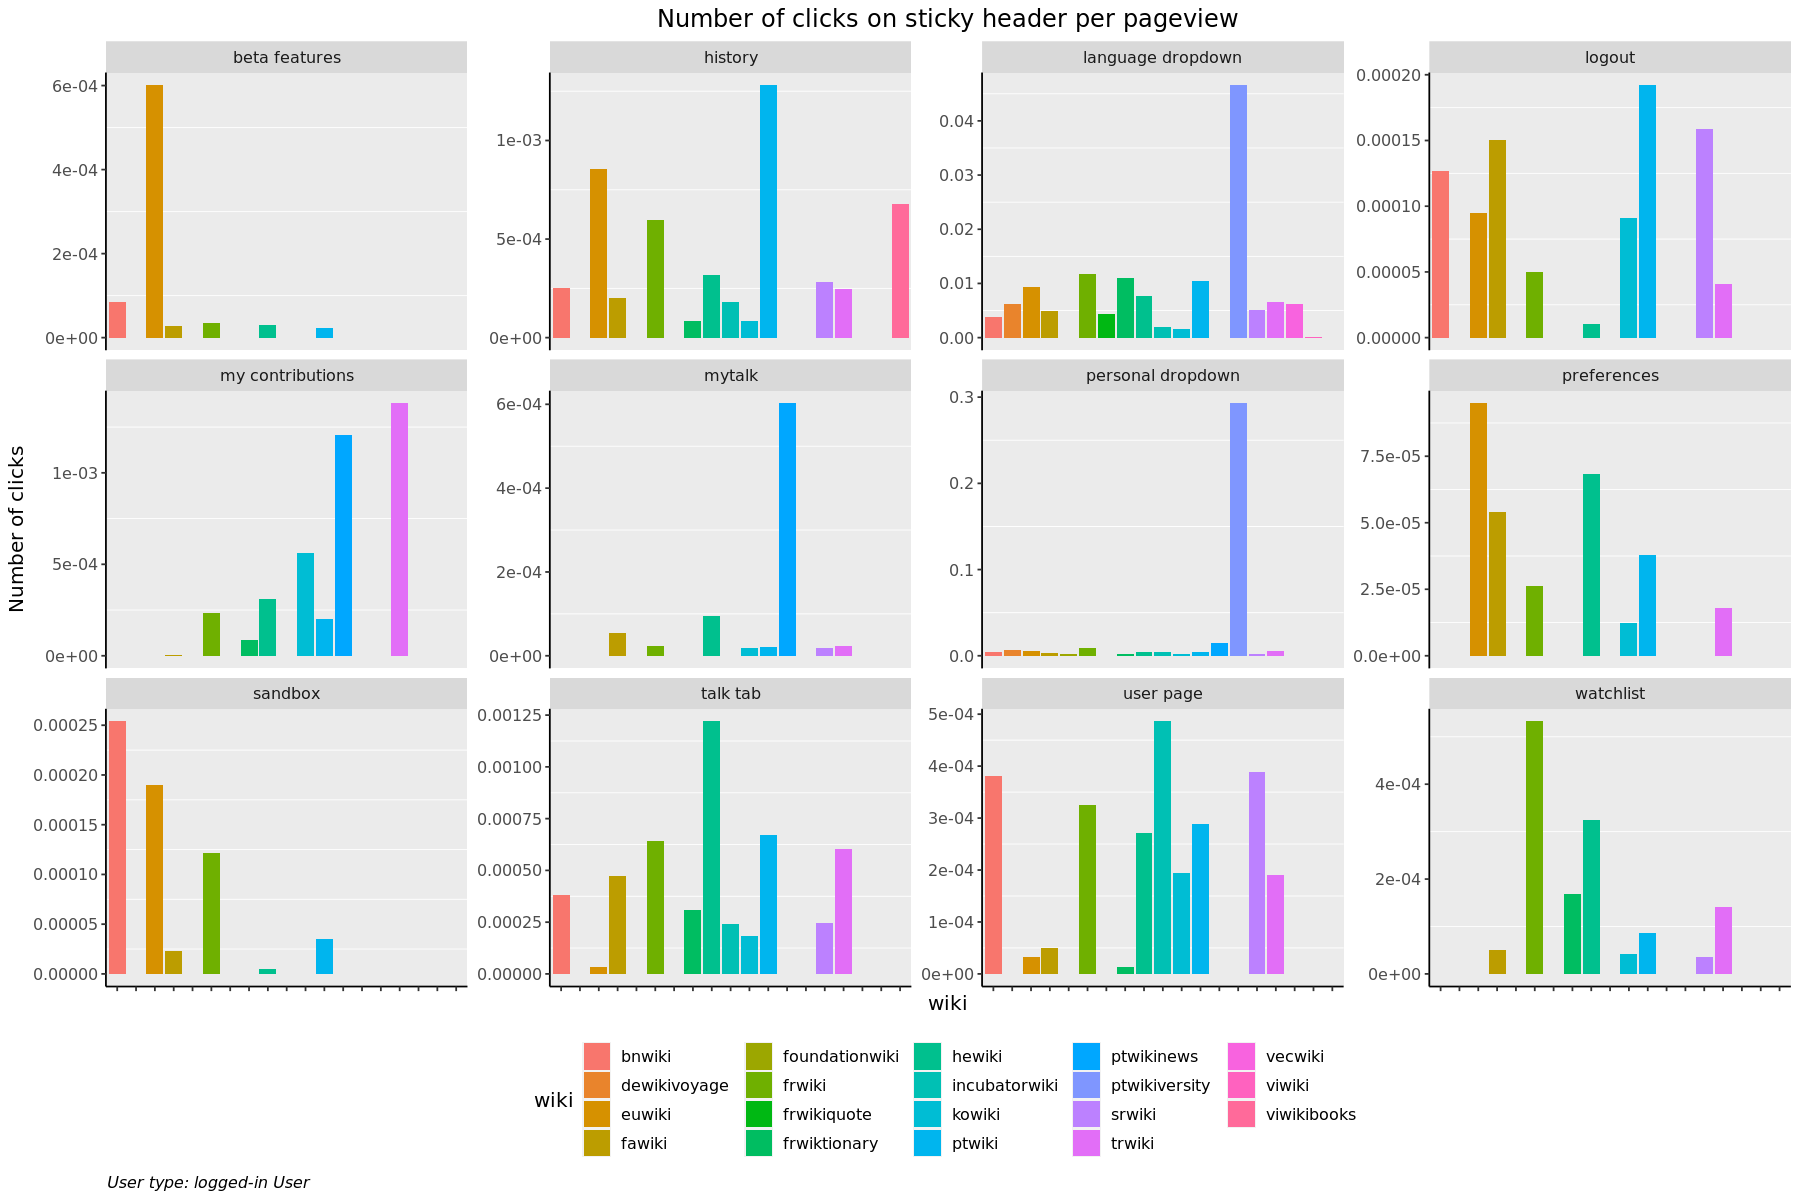

In [683]:
barchart_ctr_overall_1  <- df_ctr_overall  %>%
        select(wiki, feature, link_name, click_per_pv) %>%
        filter((feature=='sticky_header')) %>%
        ggplot(aes(x = wiki, y= click_per_pv, fill=wiki)) +
        geom_bar(stat="identity", position = 'dodge') +
       # geom_text(aes(label = paste(click_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~link_name, scale = 'free_y') +
        labs (
              y = "Number of clicks" ,
             title = "Number of clicks on sticky header per pageview" ,
             caption = "User type: logged-in User" ) +
         theme(
            panel.grid.major = element_blank(), 
            #panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
 barchart_ctr_overall_1

__Note__: 
- Personal dropdown is the most clicked link per pageview because it's the menu to click most of the other links.
- Language dropdonw is the second most clicked link per pageview
- Other links have a low click through rate. 

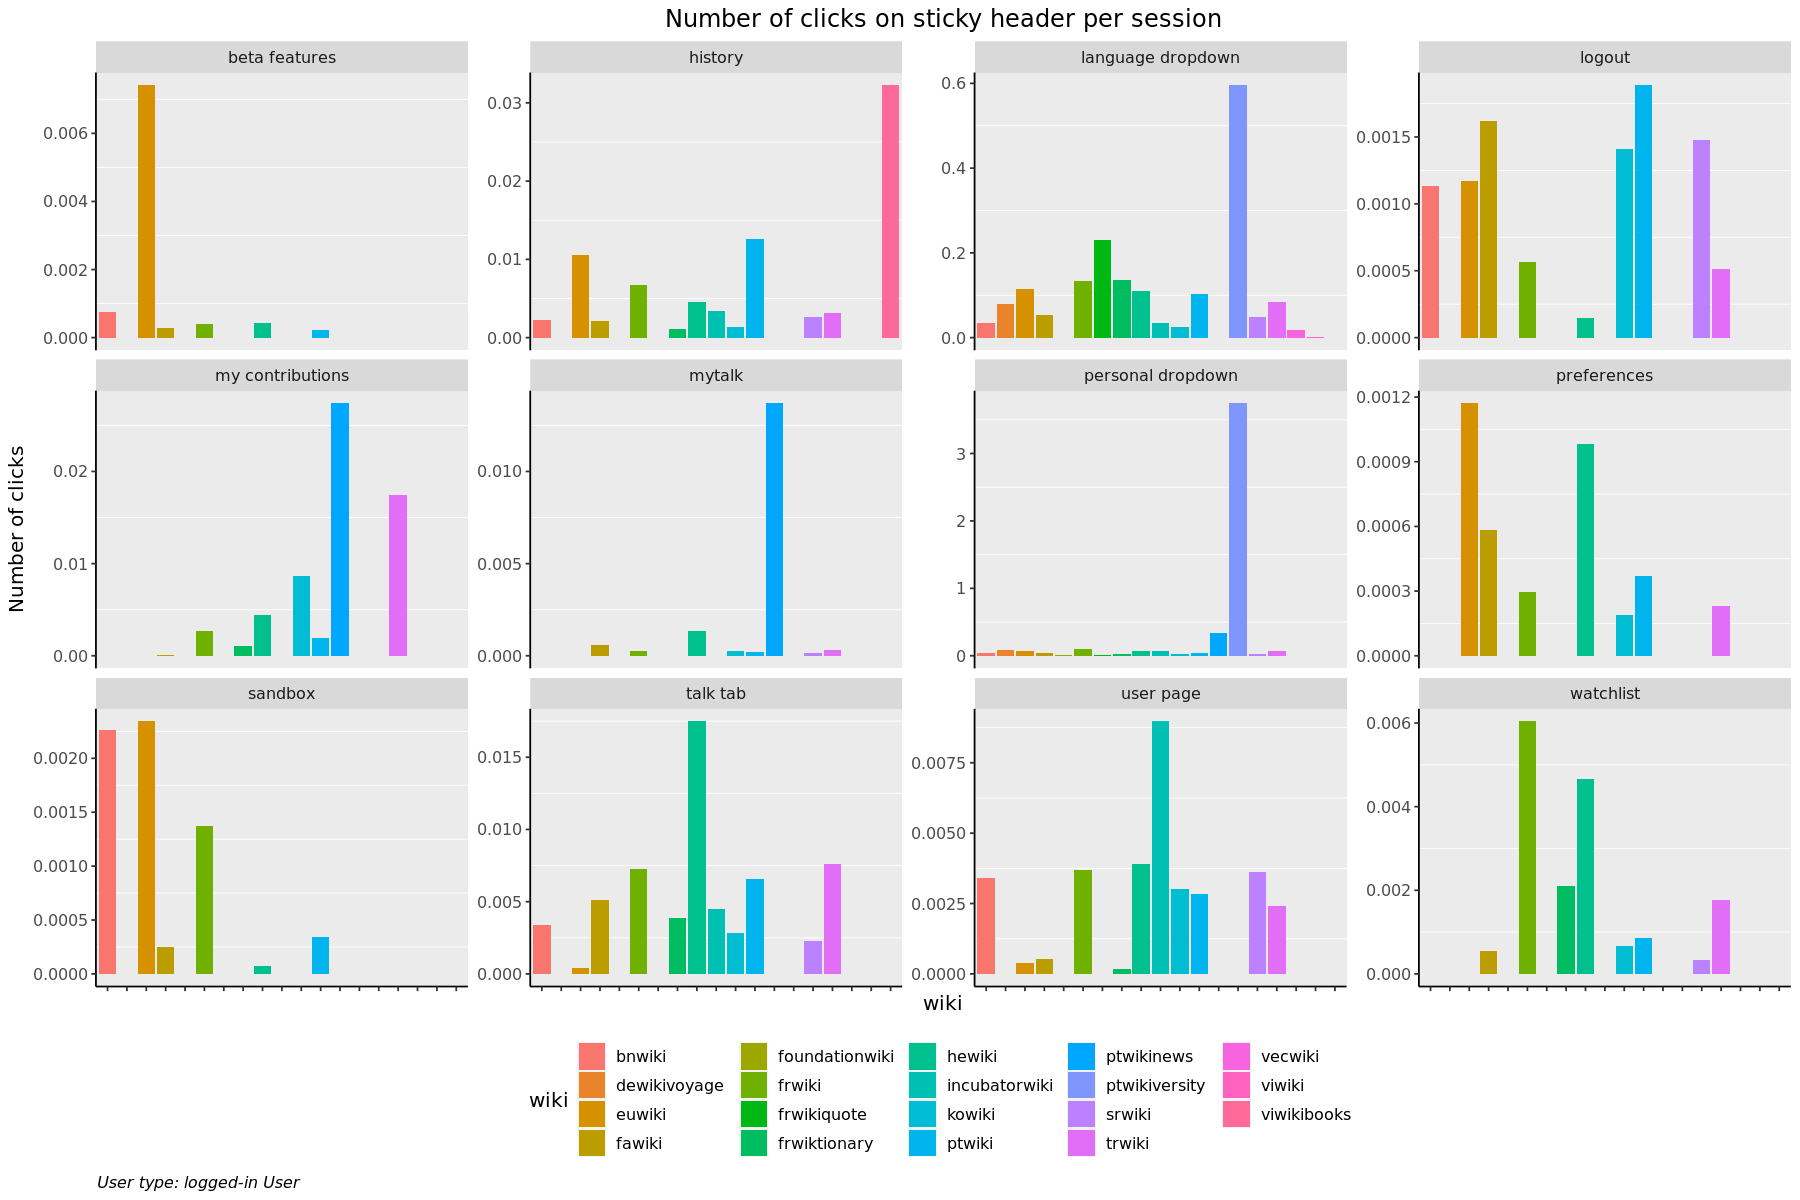

In [684]:
barchart_ctr_overall_2  <- df_ctr_overall  %>%
        select(wiki, feature, link_name, click_per_session) %>%
        filter((feature=='sticky_header')) %>%
        ggplot(aes(x = wiki, y= click_per_session, fill=wiki)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(click_per_session)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~link_name, scale = 'free_y') +
        labs (
              y = "Number of clicks" ,
             title = "Number of clicks on sticky header per session" ,
             caption = "User type: logged-in User" ) +
         theme(
            panel.grid.major = element_blank(), 
            #panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            #strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
 barchart_ctr_overall_2

__Note__:  
- Personal dropdown is the most clicked link per session because it's the menu to click most of the other links.
- Language dropdown is the second most clicked link per session
- Other links have a low click through rate. 

# Question: What is the ratio of clicks of sticky header items to the corresponding items at the top of the page

### Data Analysis

In [685]:
head(df_ctr_overall)

wiki    feature       link_name         total_clicks total_pv.x
1 arywiki top_header    history             1             64     
2 bnwiki  sticky_header beta features       2          23638     
3 bnwiki  sticky_header history             6          23638     
4 bnwiki  sticky_header language dropdown  92          23638     
5 bnwiki  sticky_header logout              3          23638     
6 bnwiki  sticky_header personal dropdown 116          23638     
  total_sessions.x click_per_pv click_per_session total_pv.y total_sessions.y
1   20             0.01562500   0.05000000           64        20            
2 2648             0.00008461   0.00075529        23638      2648            
3 2648             0.00025383   0.00226586        23638      2648            
4 2648             0.00389204   0.03474320        23638      2648            
5 2648             0.00012691   0.00113293        23638      2648            
6 2648             0.00490735   0.04380665        23638      2648            
  total_pv total_sessions
1    64      20          
2 23638    2648          
3 23638    2648          
4 23638    2648          
5 23638    2648          
6 23638    2648

In [686]:
df_ctr_overall_w <- df_ctr_overall %>%
 select(wiki, feature, link_name, total_clicks) %>%
 pivot_wider(names_from = feature, values_from = total_clicks, values_fill = 0)

In [687]:
df_ctr_overall_w <- df_ctr_overall_w %>%
    mutate(sticky_click_ratio= round(sticky_header*100/(top_header+sticky_header), 2) )

In [688]:
head(df_ctr_overall_w)

wiki    link_name         top_header sticky_header sticky_click_ratio
1 arywiki history              1         0             0.00            
2 bnwiki  beta features       24         2             7.69            
3 bnwiki  history            265         6             2.21            
4 bnwiki  language dropdown    0        92           100.00            
5 bnwiki  logout              35         3             7.89            
6 bnwiki  personal dropdown 2117       116             5.19

In [958]:
head(df_ctr_overall)

wiki    feature       link_name         total_clicks total_pv total_sessions
1 arywiki top_header    history             1             64      20          
2 bnwiki  sticky_header beta features       2          23638    2648          
3 bnwiki  sticky_header history             6          23638    2648          
4 bnwiki  sticky_header language dropdown  92          23638    2648          
5 bnwiki  sticky_header logout              3          23638    2648          
6 bnwiki  sticky_header personal dropdown 116          23638    2648          
  click_per_pv click_per_session
1 0.01562500   0.05000000       
2 0.00008461   0.00075529       
3 0.00025383   0.00226586       
4 0.00389204   0.03474320       
5 0.00012691   0.00113293       
6 0.00490735   0.04380665

In [690]:
df_ctr_overall$feature <- factor(df_ctr_overall$feature ,levels = c("top_header", "sticky_header"))

In [691]:
fun_barchart <- function(link_name_str) {
    barchart_ctr_overall  <- df_ctr_overall  %>%
        select(wiki, feature, link_name, total_clicks) %>%
        filter(link_name==link_name_str) %>%
        ggplot(aes(x = feature, y= total_clicks, fill=feature)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of clicks" ,
             title = paste("Number of clicks on top header and sticky header -- ",link_name_str) ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      return(barchart_ctr_overall)
}

In [692]:
link_name_list <- c( 'personal dropdown', 'watchlist', 'mytalk', 'sandbox',
       'preferences',  'my contributions',
        'history', 'user page',
       'talk tab', 'logout', 'beta features', 'language dropdown')


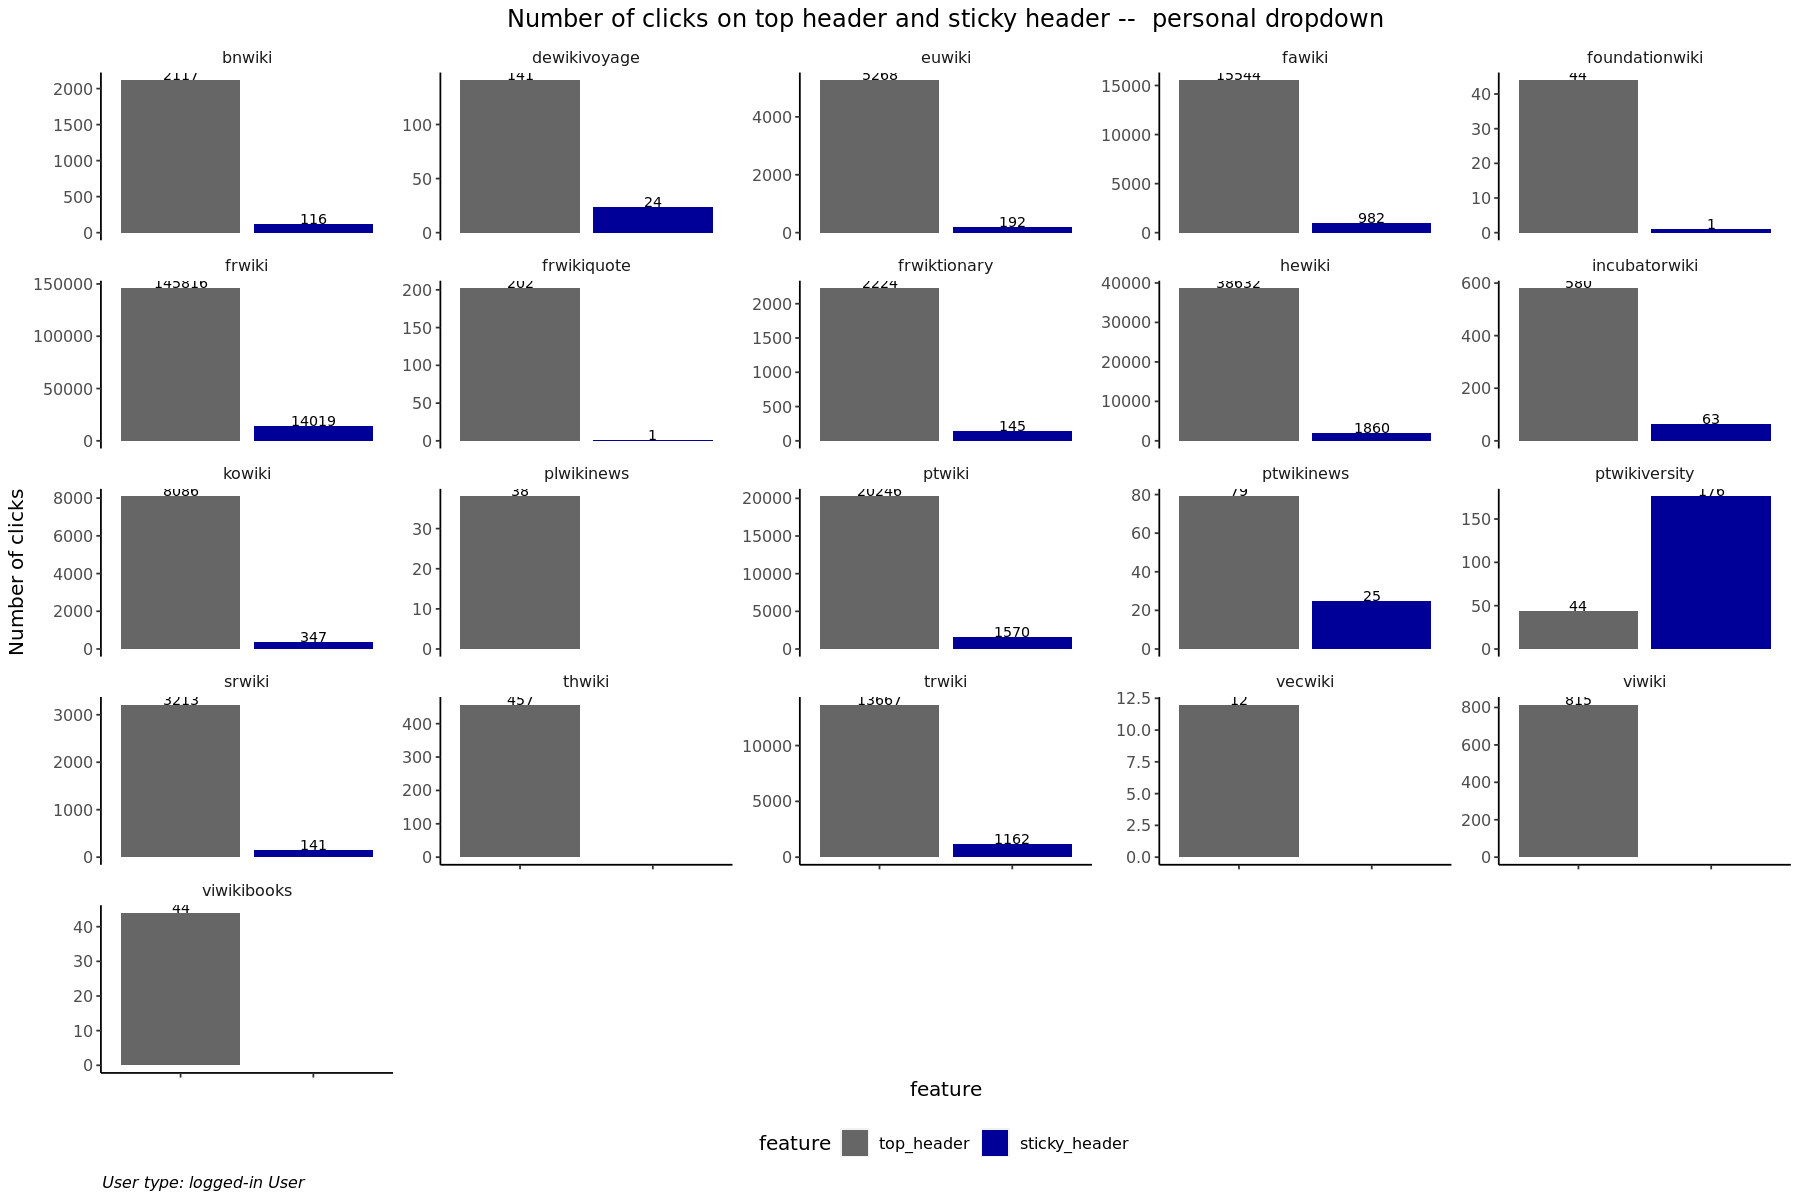

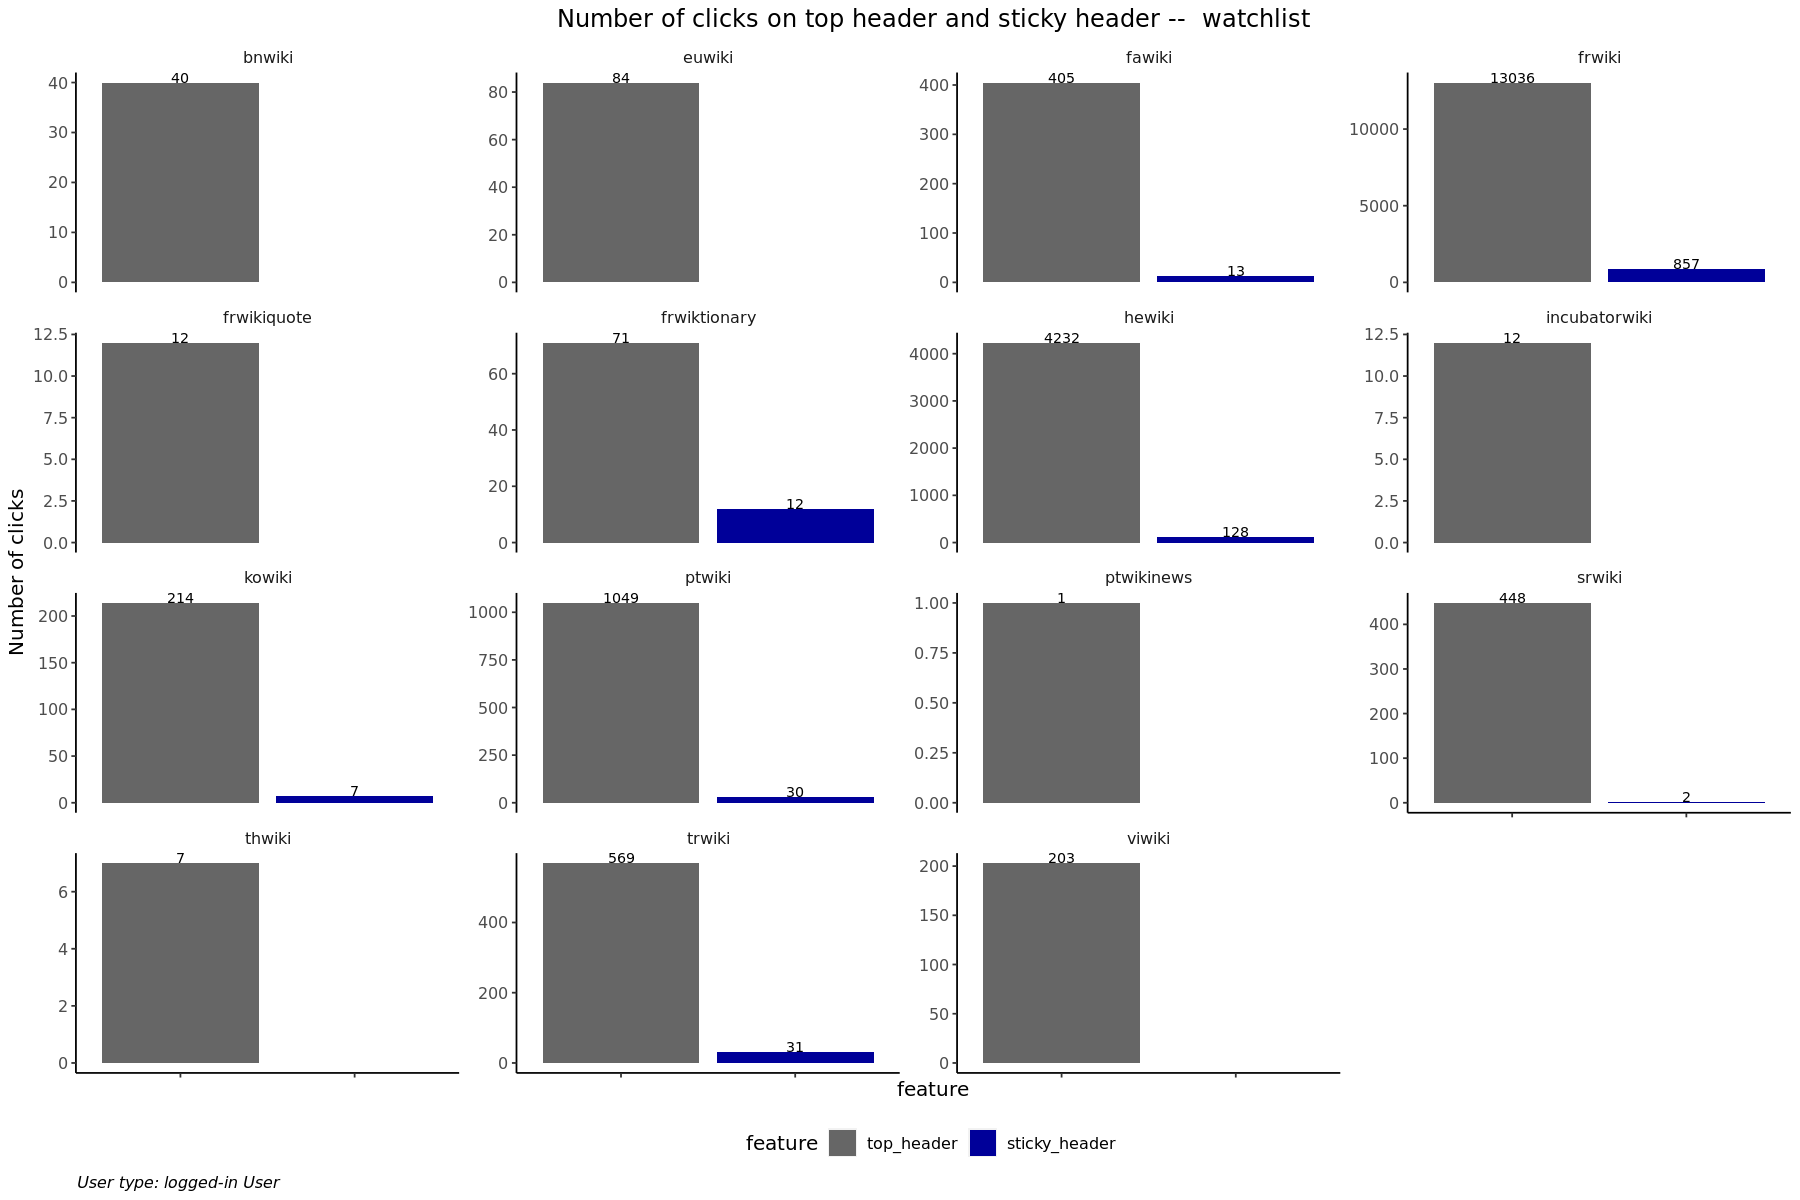

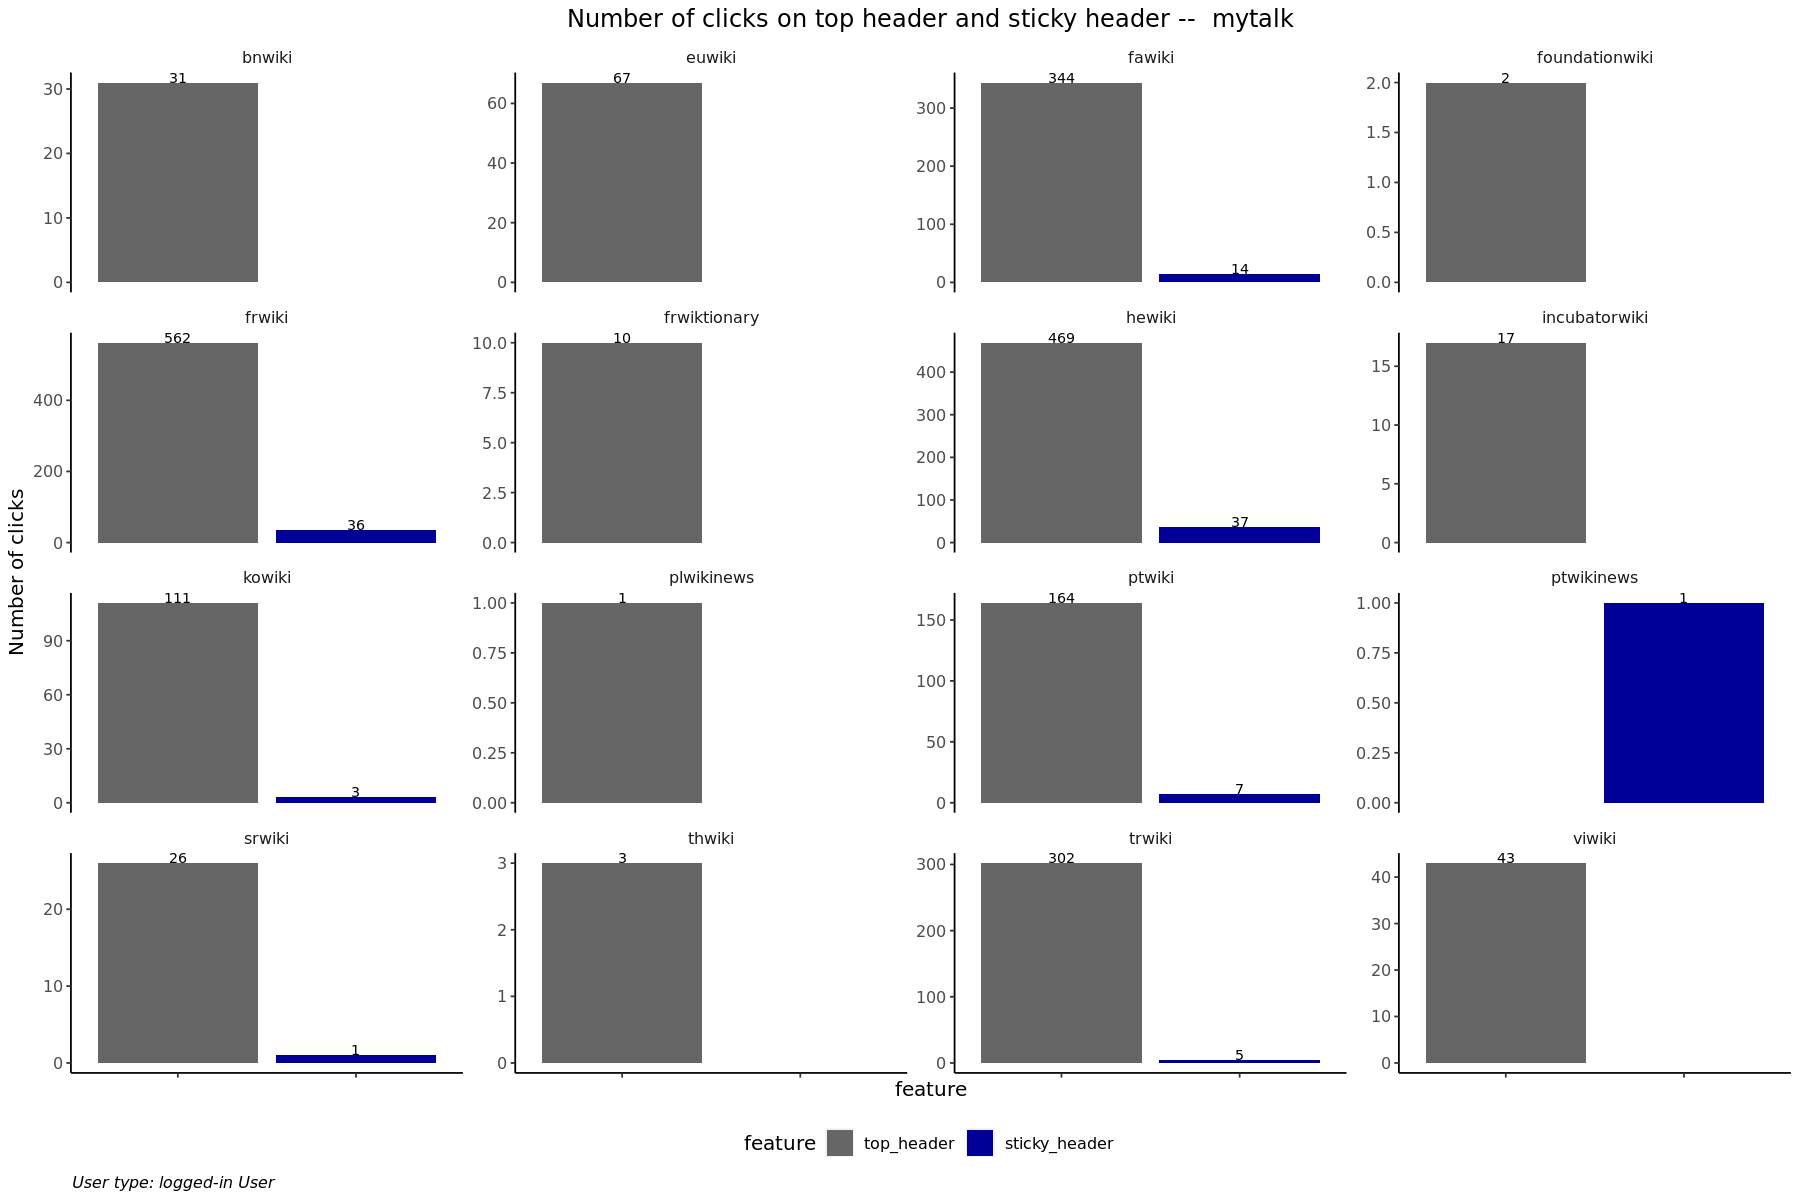

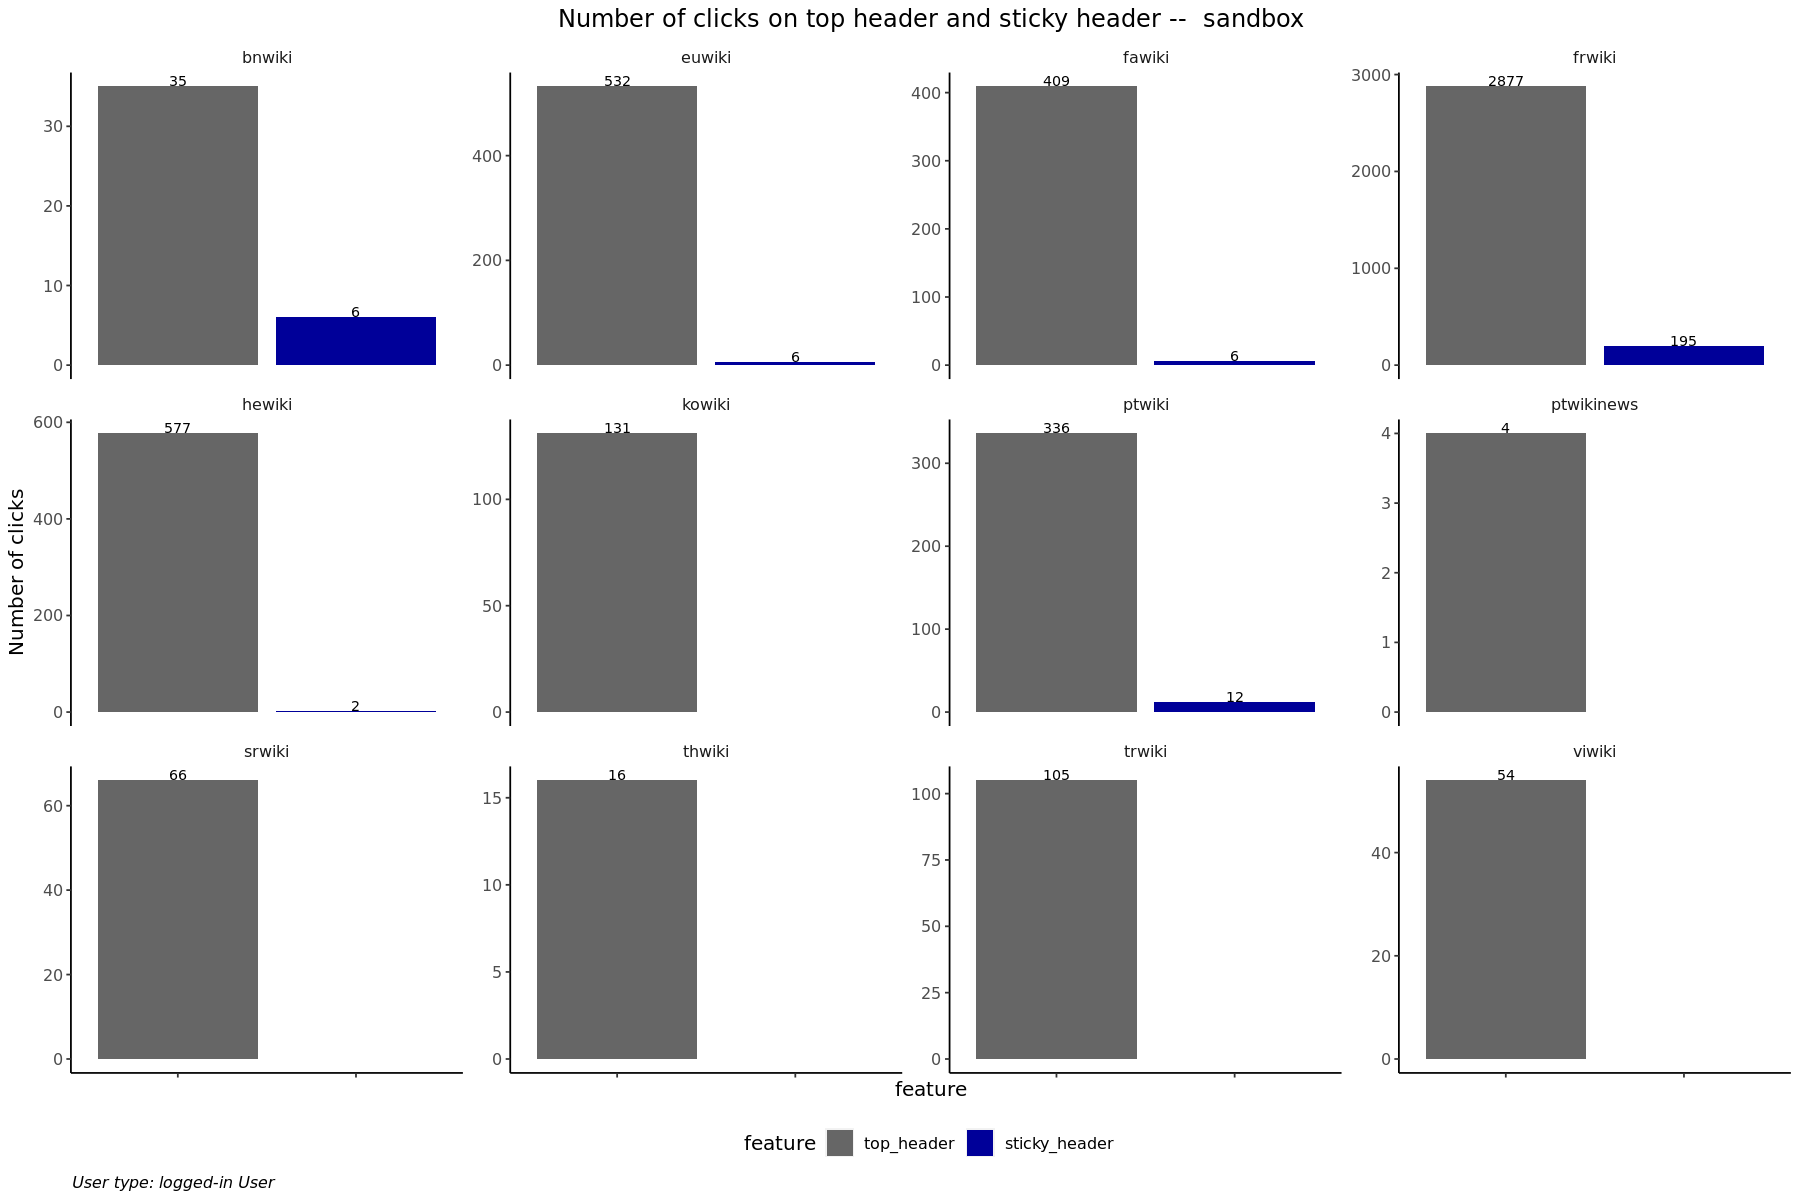

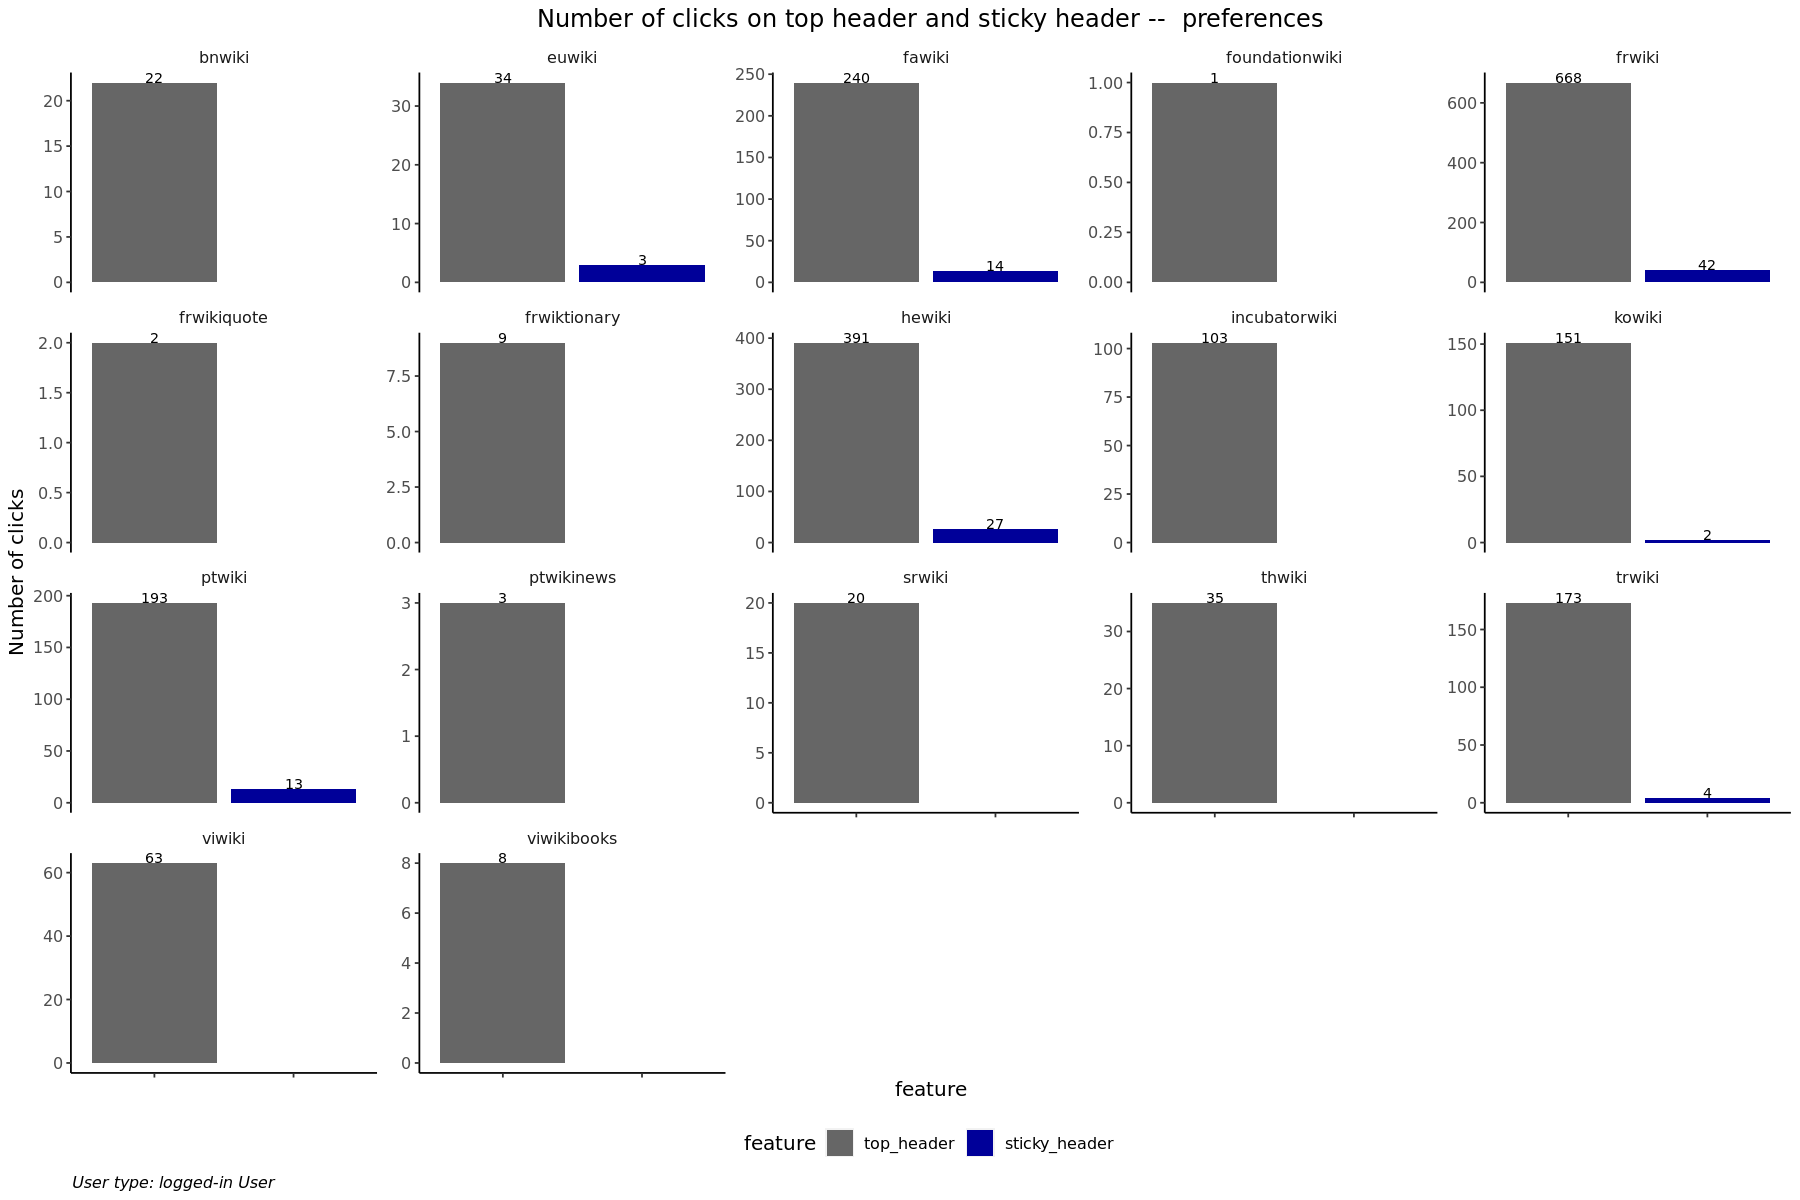

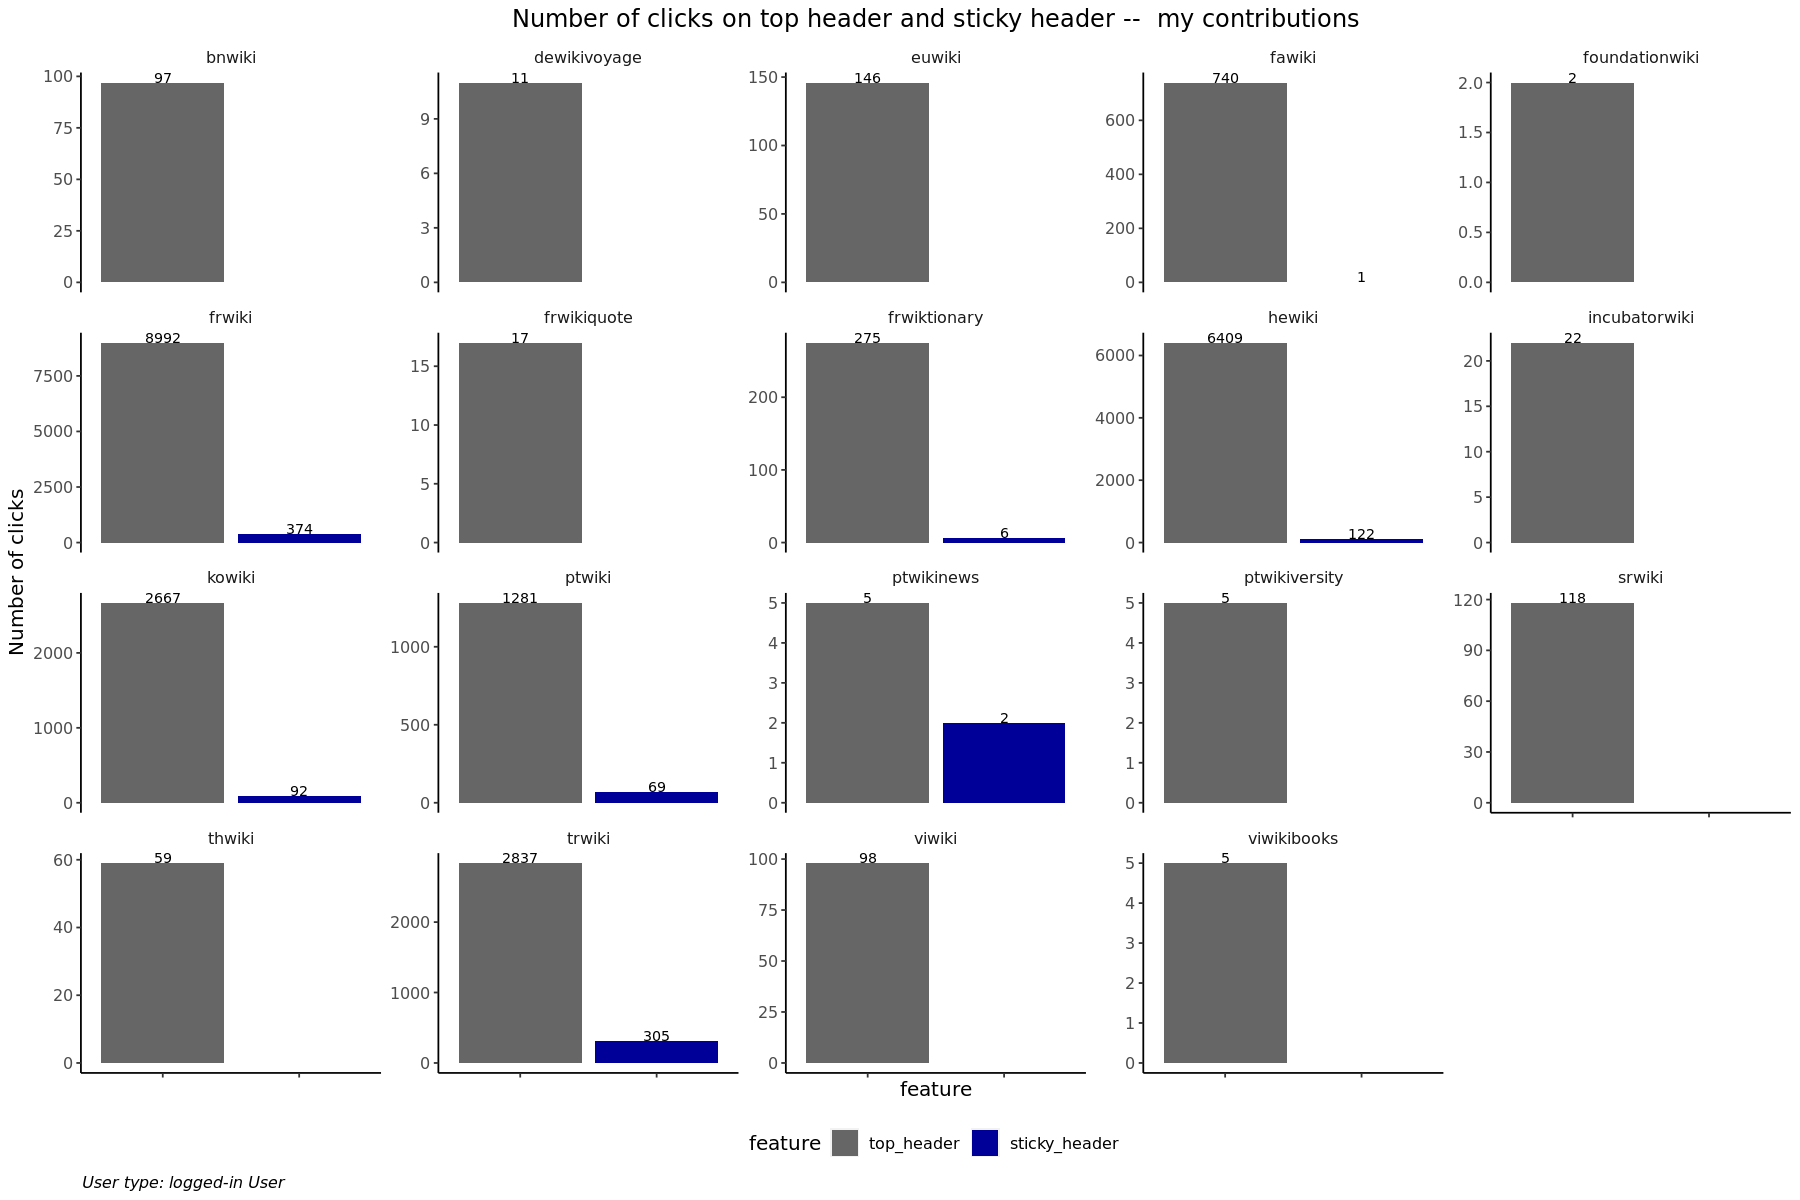

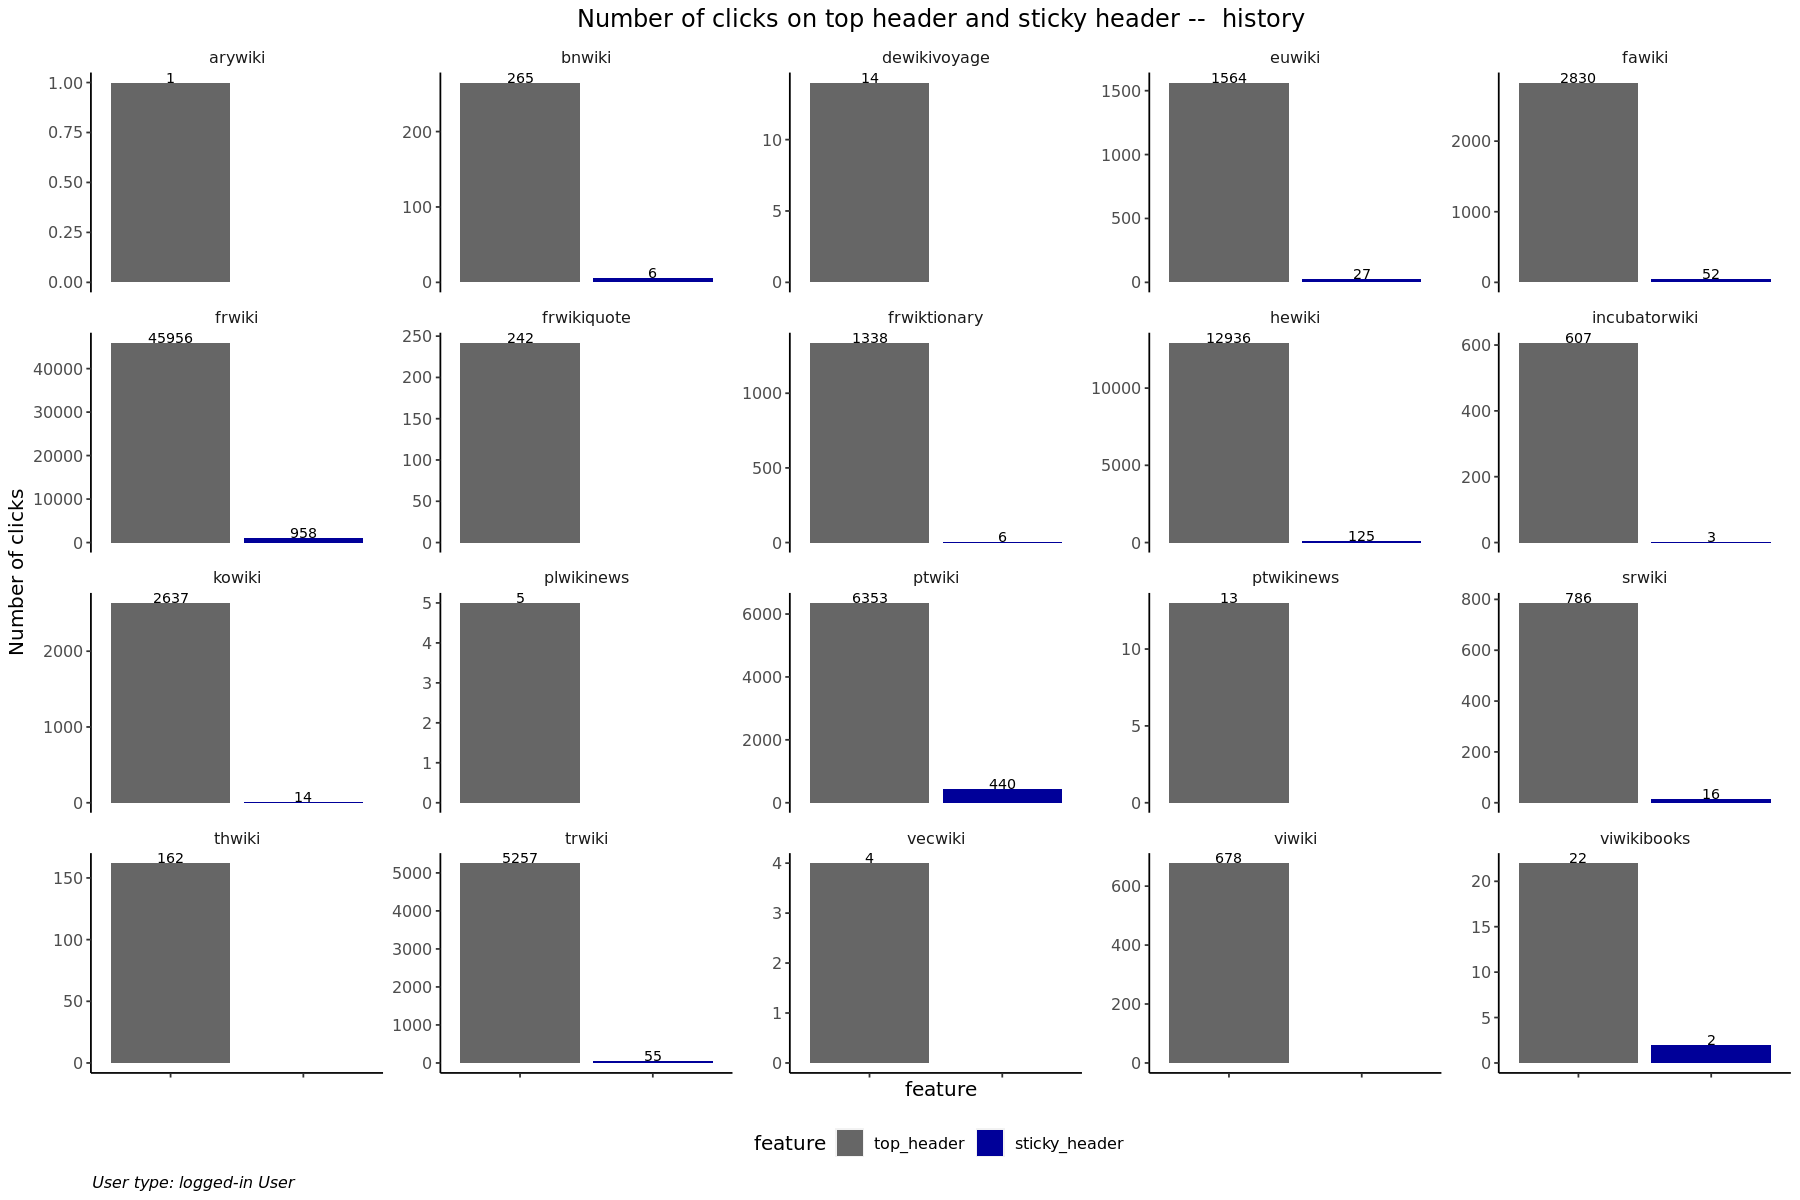

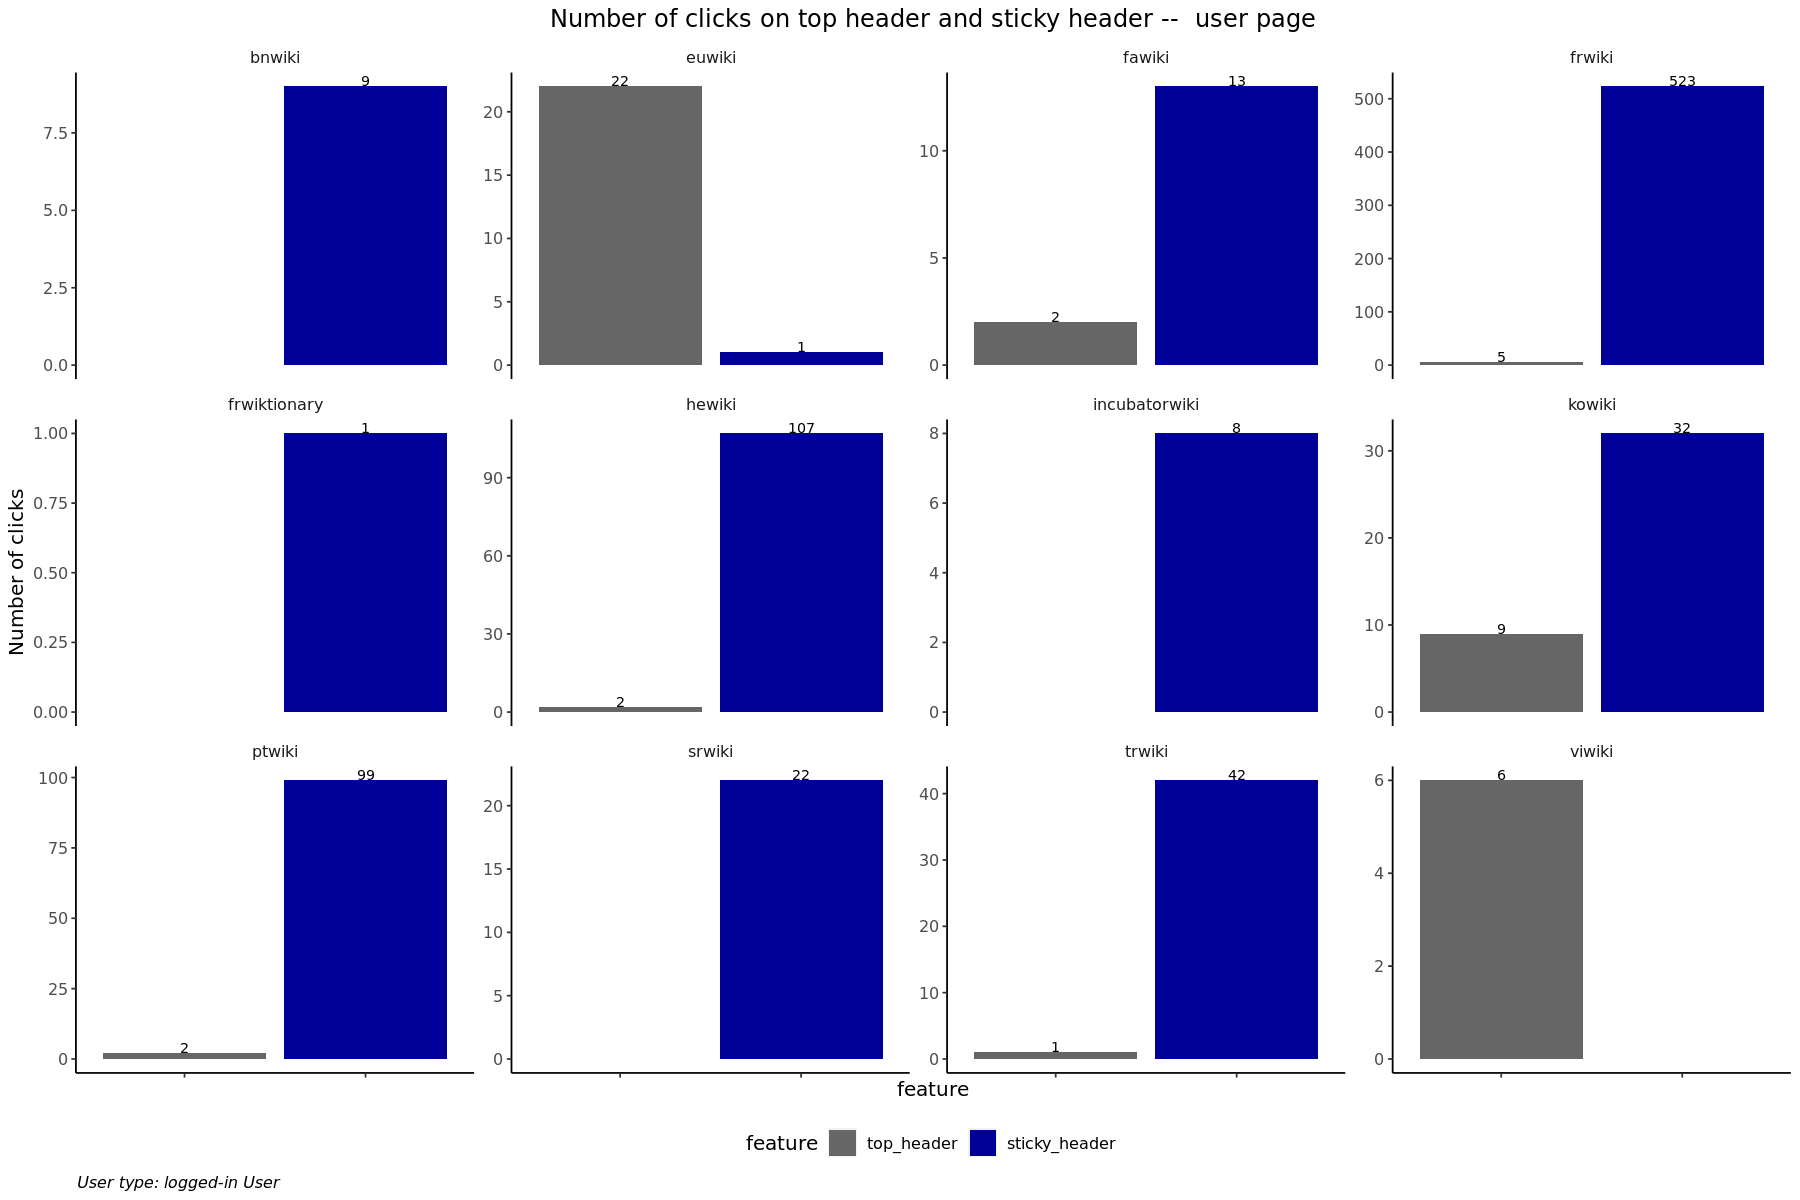

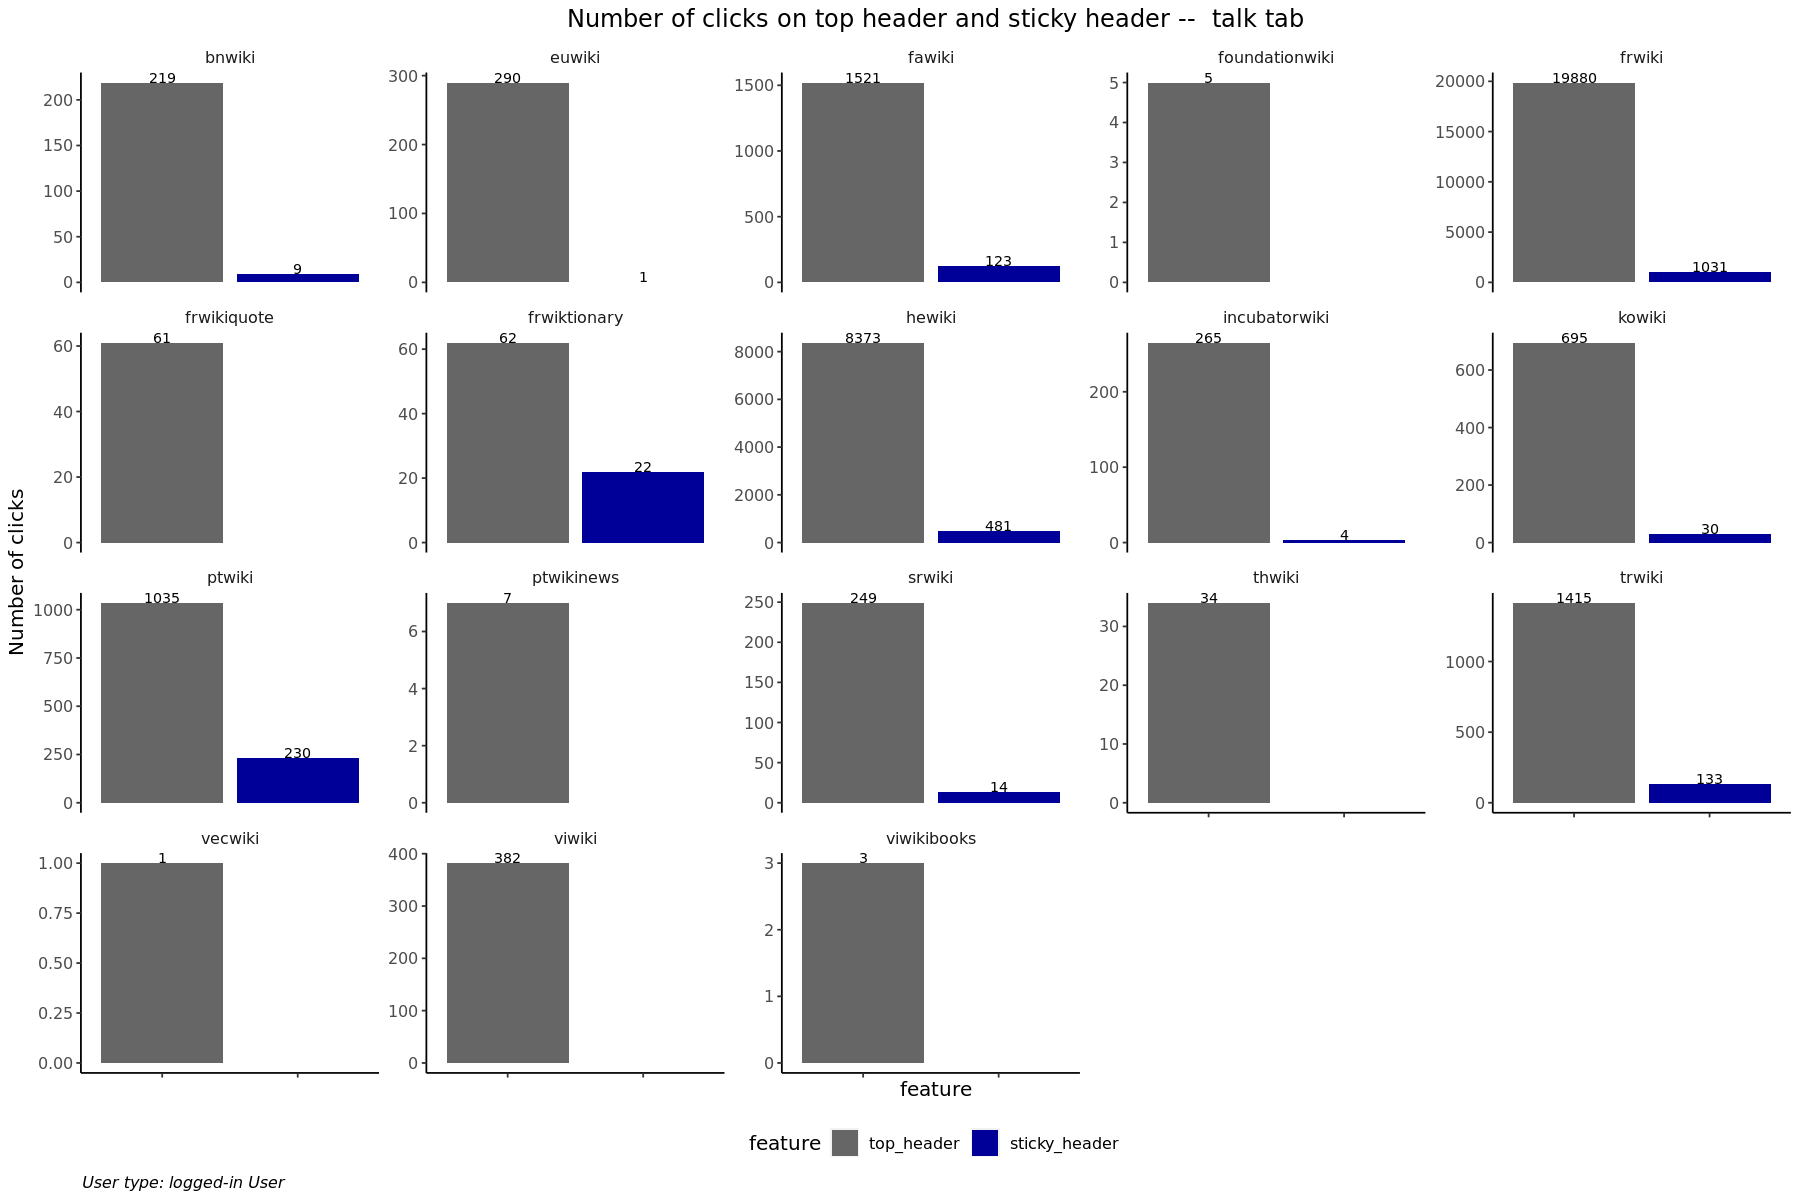

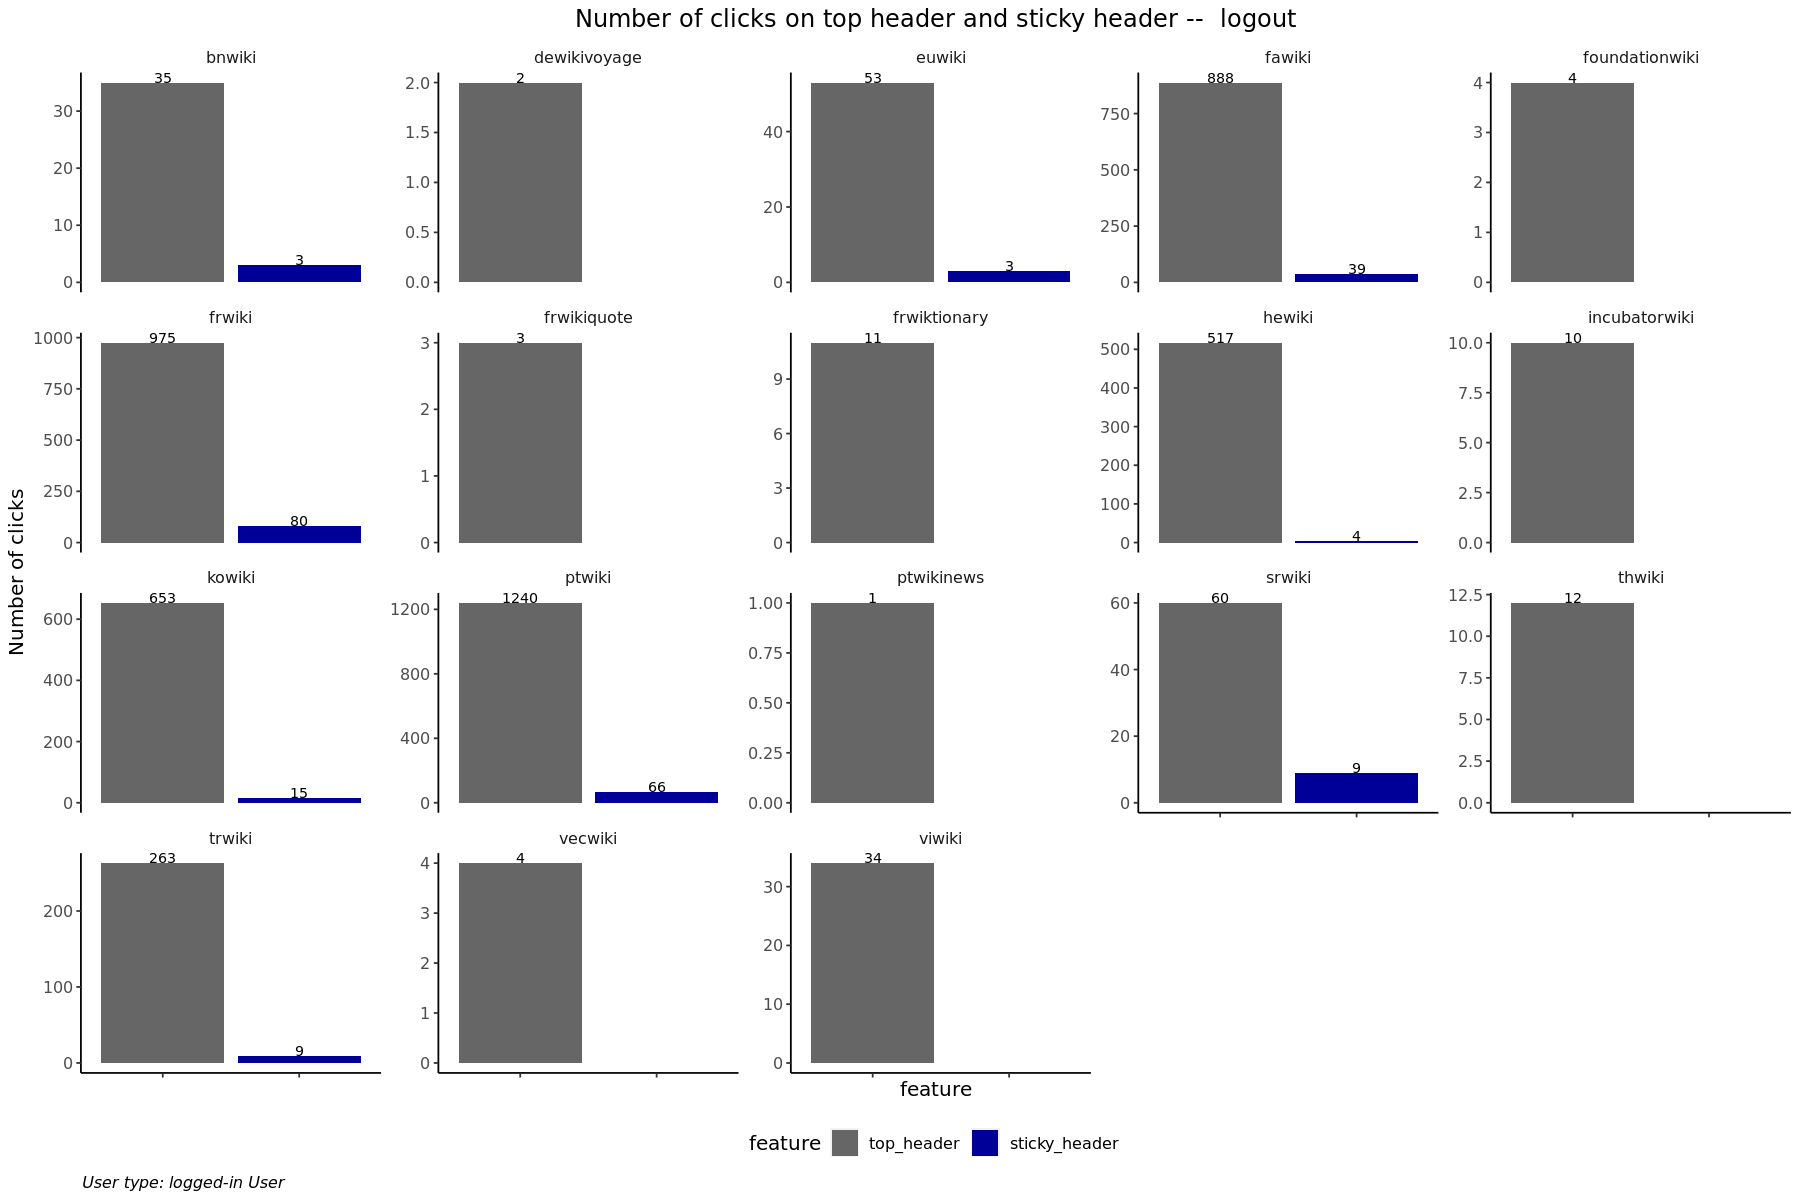

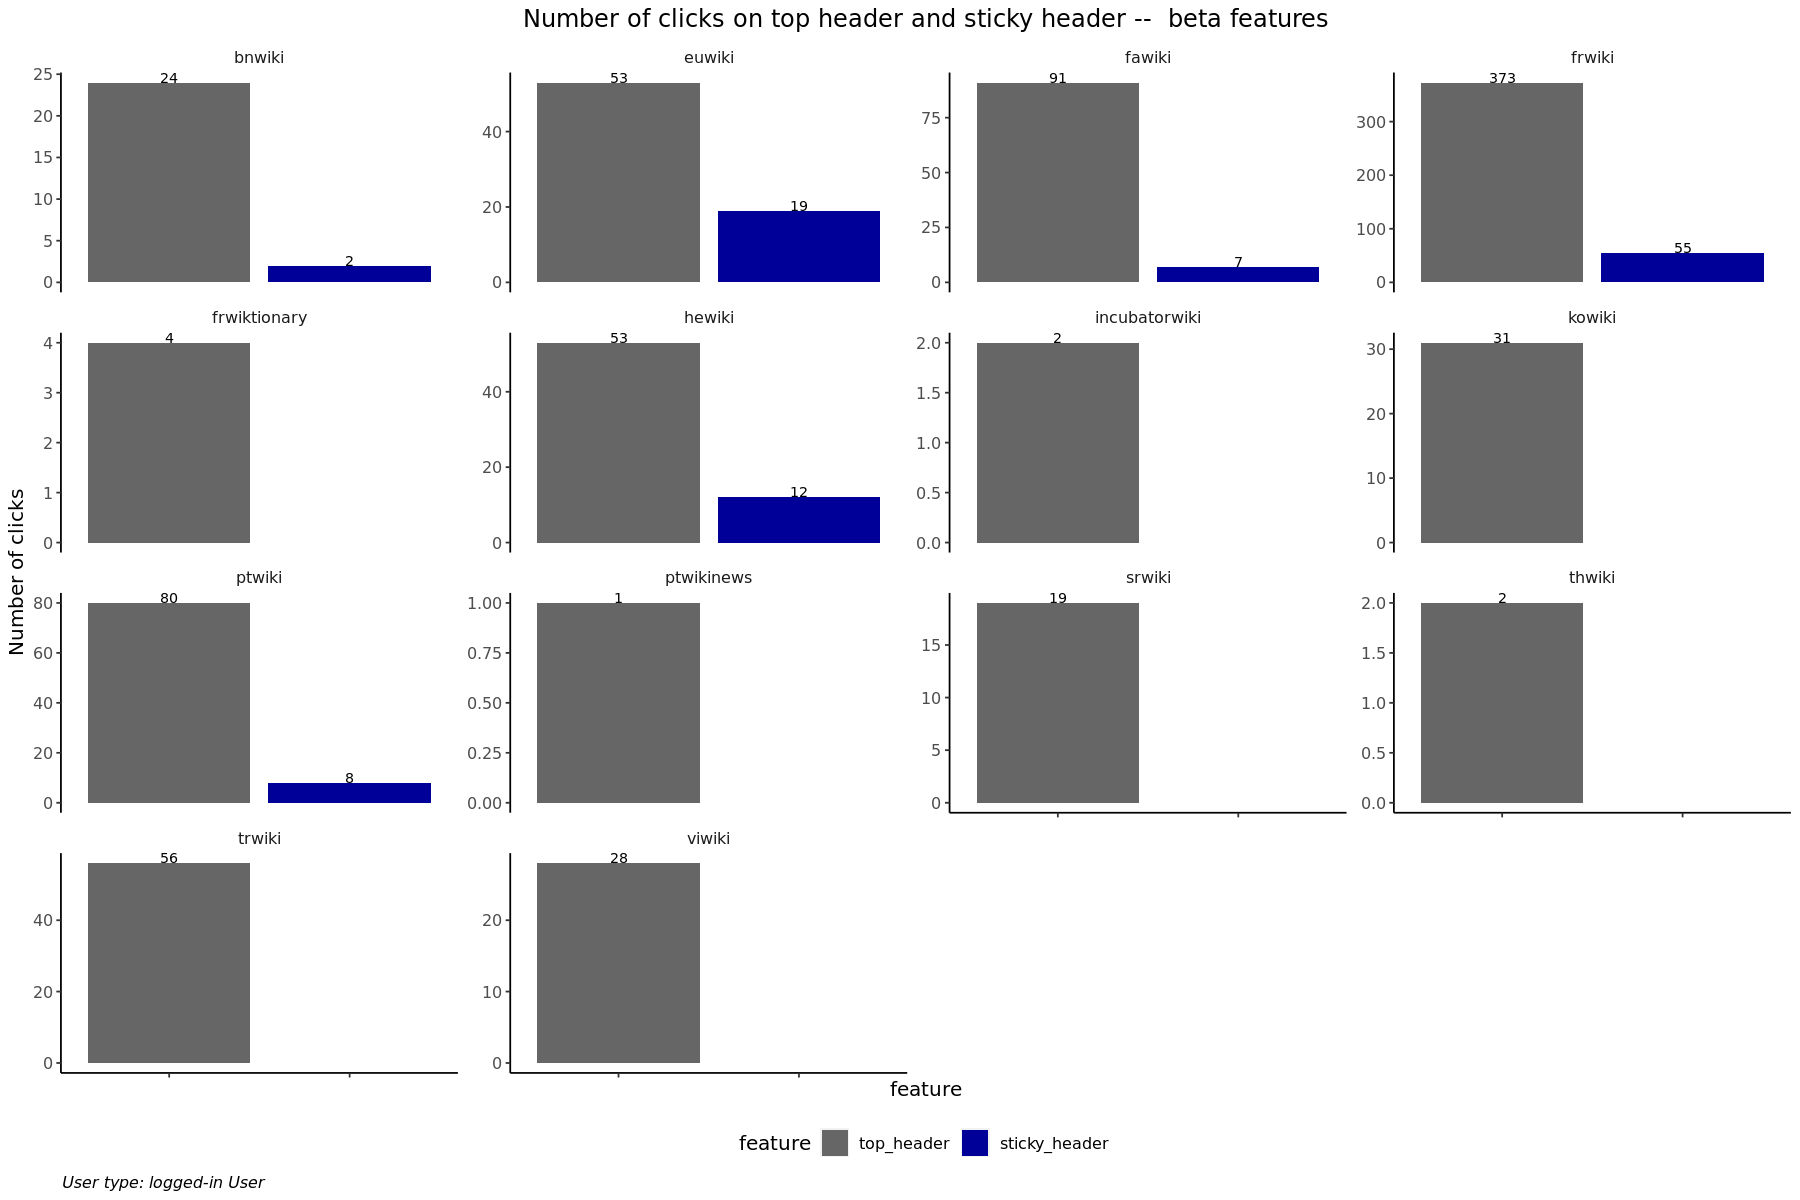

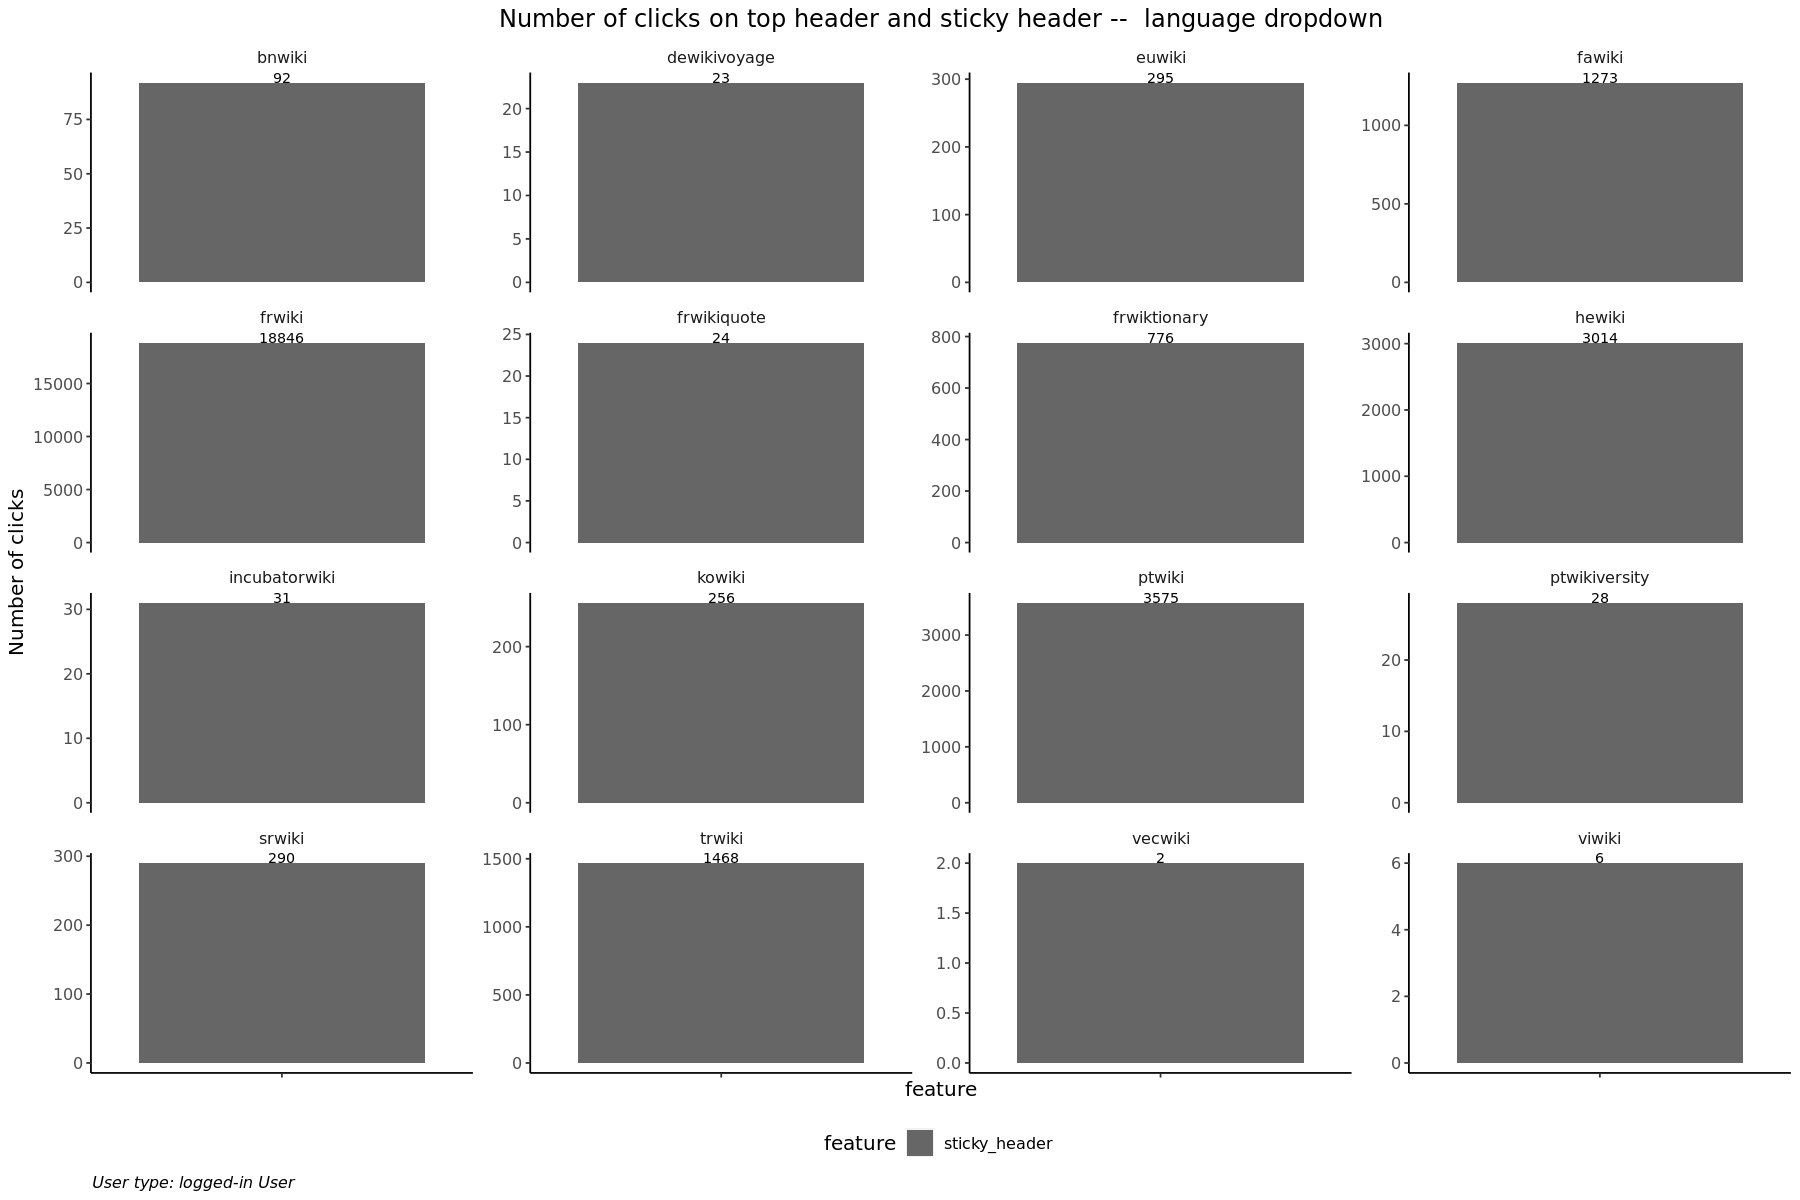

In [693]:
for(i in link_name_list) {
         p<-fun_barchart(i)
         print(p)
 }

__Note:__ 
The clicks on language drop down at the top header are not captured in schema

Next step:

Investigate clicks on language drop down at the top header.

### By click name

In [694]:
head(df_ctr_overall_w)

wiki    link_name         top_header sticky_header sticky_click_ratio
1 arywiki history              1         0             0.00            
2 bnwiki  beta features       24         2             7.69            
3 bnwiki  history            265         6             2.21            
4 bnwiki  language dropdown    0        92           100.00            
5 bnwiki  logout              35         3             7.89            
6 bnwiki  personal dropdown 2117       116             5.19

In [695]:
df_sticky_ratio <-  df_ctr_overall_w %>%
   group_by(link_name) %>%
   summarize(total_top_clicks = sum(top_header), total_sticky_clicks = sum(sticky_header)) %>%
   mutate(sticky_click_ratio= round(total_sticky_clicks*100/(total_top_clicks+total_sticky_clicks), 2) )

In [696]:
df_sticky_ratio

link_name         total_top_clicks total_sticky_clicks sticky_click_ratio
1  beta features        817             103                11.20            
2  history            81670            1704                 2.04            
3  language dropdown      0           29999               100.00            
4  logout              4765             228                 4.57            
5  my contributions   23786             971                 3.92            
6  mytalk              2152             104                 4.61            
7  personal dropdown 257269           20824                 7.49            
8  preferences         2116             105                 4.73            
9  sandbox             5142             227                 4.23            
10 talk tab           34497            2078                 5.68            
11 user page             49             857                94.59            
12 watchlist          20383            1080                 5.03

__Note__:  
- Sticky header user page link has the highest click ratio. 94% of clicks on user page is from sticky header
- The other links on sticky header have lower click ratio than top header, range from 2.04% to 11.2% 
- Language dropdown does not capture any clicks on top header. Need to check whether the instrumentation is enabled.